## Rohlik orders forecasts
This notebook contains a time series forecasting task with Rohlik dataset EDA and data preprocessing and as an engine using LSTM model with Tensorflow 2 backend. 

<br><b>Approach:</b>
<br>As Rohlík orders dataset contains data from multiple warehouses, thus it contains multiple timelines, the approach is to process and predict each warehouse as a separate timeline. The preprocessing, fiting and evaluation steps are the same for each warehouse.

<br>This approach yields very good MAPE value, which is calculated as a mean of all warehouse timeline results.

In [168]:
! pip -q install pandas matplotlib numpy seaborn
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Reshape, LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input, LayerNormalization, GRU, Conv1D, MaxPooling1D, MultiHeadAttention, GlobalAveragePooling1D, Activation, SpatialDropout1D, Lambda
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import joblib
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import interpolate


TIME_STEPS = 7
EPOCHS = 100
BATCH_SIZE = 16
#WAREHOUSE = ["Budapest_1", "Prague_1"] # Train only particular warehouse timelines (For testing purposes)
WAREHOUSE = [None]  # Train on all warehouses (whole dataset)

# Temporal features
LAG_DAYS = [1, 7, 28, 56, 84, 168, 364]  # this somehow yields better results
ROLLING_WINDOW = [7, 28, 56, 168, 364]  # this somehow yields better results
#LAG_DAYS = [63, 119, 168, 364]  # this lag bridges the whole test dataset with past data
#ROLLING_WINDOW = [63, 168, 364]  # this lag bridges the whole test dataset with past data


pd.set_option('display.max_columns', None)  # see all columns in pandas

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional - Dataset Validation

Evaluate the correctness of the data from multiple sources. Check both .csvs if their values in the overlapping columns match and then merge them into one dataset.
<br>After that we get train_df and test_df dataframes.

In [170]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nAll values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [171]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'blackout', 'mov_change', 'warehouse', 'holiday', 'shutdown', 'date', 'winter_school_holidays', 'frankfurt_shutdown', 'shops_closed', 'holiday_name', 'precipitation', 'school_holidays', 'snow', 'mini_shutdown'}
No differences found in column: blackout
No differences found in column: mov_change
No differences found in column: holiday
No differences found in column: shutdown
No differences found in column: winter_school_holidays
No differences found in column: frankfurt_shutdown
No differences found in column: shops_closed
No differences found in column: holiday_name
No differences found in column: precipitation
No differences found in column: school_holidays
No differences found in column: snow
No differences found in column: mini_shutdown

All values match across the datasets, datasets merged.
{'warehouse', 'holiday', 'winter_school_holidays', 'date', 'shops_closed', 'holiday_name', 'school_holidays'}
No differences found in column: holiday
No differences found in column: winter_schoo

In [172]:
# Sort the datasets by 'date' and 'warehouse' ascendingly

train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data
There are some features in the training set that are not availiable in the testing set, so we do not use them.
<br>The "orders" column we keep as it is our target.

In [173]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['blackout', 'mov_change', 'shutdown', 'frankfurt_shutdown', 'warehouse_limited', 'precipitation', 'user_activity_1', 'user_activity_2', 'snow', 'mini_shutdown']


In [174]:
train_df = train_df.drop(columns=unavailable_features)

Columns that have unchanging values or very little movement, sometimes redundant features.
<br> We look as binary features that might be alway 0 or 1.
<br> "school_holidays" and "shops_closed" are redundant in some warehouses
<br> We can drop these columns as they are redundant but in this run we leave it.

In [175]:
# Run the code to identify and drop unchanging columns

for warehouse in train_df['warehouse'].unique():
    unchanging_columns = []
    print(f"\nWarehouse: {warehouse}")
    for feature in train_df.columns:
        if feature in ['warehouse', 'date']:
            continue

        values = train_df[train_df['warehouse'] == warehouse][feature].nunique()
        if values == 1:
            print(f"Feature {feature} has {values} unique values")
            print(f"Value: {train_df[train_df['warehouse'] == warehouse][feature].unique()}")
            if feature not in unchanging_columns:
                unchanging_columns.append(feature)
        if values == 2:
            print(f"Feature {feature} has {values} unique values")
            true_count = sum(train_df[train_df['warehouse'] == warehouse][feature] == 1)
            total_count = len(train_df[train_df['warehouse'] == warehouse])
            print(f"{true_count} items True of {total_count}")

    print(f"    Unchanging columns in {warehouse}: {unchanging_columns}")



Warehouse: Brno_1
Feature holiday has 2 unique values
45 items True of 1193
Feature shops_closed has 2 unique values
20 items True of 1193
Feature winter_school_holidays has 2 unique values
28 items True of 1193
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Brno_1: ['school_holidays']

Warehouse: Budapest_1
Feature holiday has 2 unique values
9 items True of 1154
Feature shops_closed has 1 unique values
Value: [0]
Feature winter_school_holidays has 2 unique values
6 items True of 1154
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Budapest_1: ['shops_closed', 'school_holidays']

Warehouse: Prague_1
Feature holiday has 2 unique values
45 items True of 1193
Feature shops_closed has 2 unique values
20 items True of 1193
Feature winter_school_holidays has 2 unique values
84 items True of 1193
Feature school_holidays has 1 unique values
Value: [0]
    Unchanging columns in Prague_1: ['school_holidays']

Warehouse: Prague_

In [113]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


### Line-up all warehouse timelines in the same time format.
This is experimental function with a purpose:

-   When we examine the dataset, we can see that some warehouses do not operate at sundays. 
-   Some warehouses are missing a lot of days rom first months as they were just setting up oin new markets.
-   There are missing days on other warehouses sometimes.
-   <b>This function introduces</b> a new feature <b>"off_day"</b>, which is 1 whenever we have missing day in the dataset.
- Currently diabled, uncomment last line bellow to experiment.

In [114]:
def process_warehouses(train_df, handle_off_days='interpolate'):
    """
    Process each warehouse and handle off days based on the specified method.
    
    Parameters:
    train_df (DataFrame): The input DataFrame containing warehouse data.
    handle_off_days (str): The method to handle off days, either 'interpolate' or 'zeros'.
    
    Returns:
    DataFrame: The processed DataFrame with all warehouses combined.
    """
    combined_df_list = []
    start_dates_info = []

    for warehouse in train_df['warehouse'].unique():
        wh = train_df[train_df['warehouse'] == warehouse]
        
        # Fix specific warehouses with unconisitent data at the start
        if warehouse == 'Frankfurt_1':
            first_month_end = wh['date'].min() + pd.DateOffset(days=4)
            wh = wh[wh['date'] > first_month_end]
        if warehouse == 'Munich_1':
            first_month_end = wh['date'].min() + pd.DateOffset(weeks=5)
            wh = wh[wh['date'] > first_month_end]
            
        wh.set_index('date', inplace=True)
        date_range = pd.date_range(start=wh.index.min(), end=wh.index.max(), freq='D')
        wh_reindexed = wh.reindex(date_range).reset_index()
        wh_reindexed.rename(columns={'index': 'date'}, inplace=True)
        
        # Add off_day column
        wh_reindexed['off_day'] = wh_reindexed['orders'].isna().astype(int)
        
        # Here we have to fill in the missing features for the off days, mostly 0s here, we do not count holidays, etc. for missing days for now.
        wh_reindexed['warehouse'] = warehouse
        wh_reindexed['holiday_name'] = wh_reindexed['holiday_name'].fillna('')
        wh_reindexed['holiday'] = wh_reindexed['holiday'].fillna(0)
        wh_reindexed['shops_closed'] = wh_reindexed['shops_closed'].fillna(0)
        wh_reindexed['winter_school_holidays'] = wh_reindexed['winter_school_holidays'].fillna(0)
        wh_reindexed['school_holidays'] = wh_reindexed['school_holidays'].fillna(0)
        
        if handle_off_days == 'interpolate':
            wh_reindexed['orders'] = wh_reindexed['orders'].interpolate(method='linear')
        elif handle_off_days == 'zeros':
            wh_reindexed['orders'] = wh_reindexed['orders'].fillna(0.0)
        
        # the 'id' column is for the test dataset mostly
        wh_reindexed['id'] = wh_reindexed.apply(lambda row: f"{row['warehouse']}_{row['date'].strftime('%Y-%m-%d')}", axis=1)
        wh_reindexed['day_of_week'] = wh_reindexed['date'].dt.dayofweek + 1  # Monday=1, Sunday=7
        
        # Cut off data to start on the earliest Monday - all warehouses start on timeline on Monday, so they hawe weekly overlap.
        start_date = wh_reindexed['date'].min()
        end_date = wh_reindexed['date'].max()
        start_monday = start_date - pd.Timedelta(days=start_date.weekday())
        end_sunday = end_date + pd.Timedelta(days=(6 - end_date.weekday()))
        wh_reindexed = wh_reindexed[(wh_reindexed['date'] >= start_monday) & (wh_reindexed['date'] <= end_sunday)]
        
        # get info about the start date 
        start_dates_info.append(f"{warehouse}: Start Date: {start_monday.strftime('%Y-%m-%d')} (Day {start_monday.weekday() + 1})")

        # get all new dataframes into a list
        combined_df_list.append(wh_reindexed)
        
        # Plot
        plt.figure(figsize=(20, 10))
        plt.plot(wh_reindexed['date'], wh_reindexed['orders'], marker='x', linestyle='-', markersize=3, linewidth=0.5, label='Orders')

        # start of the first week and end of the last week
        plt.axvline(x=start_monday, color='r', linestyle='--', linewidth=0.5, label='Start of first week')
        plt.axvline(x=end_sunday, color='g', linestyle='--', linewidth=0.5, label='End of last week')
        
        # Highlight the off days
        off_days = wh_reindexed[wh_reindexed['off_day'] == 1]
        plt.scatter(off_days['date'], off_days['orders'], color='red', s=15, label='Off days', marker='o')
        
        # Mark the weekdays on off days
        for idx, row in wh_reindexed.iterrows():
            if row['off_day'] == 1:
                plt.text(row['date'], row['orders'], str(row['day_of_week']), color='black', ha='center', va='bottom', fontsize=10)

        plt.title(f"Volume for warehouse {warehouse}")
        plt.xlabel('Date')
        plt.ylabel('Orders')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

        # Drop day_of_week column , we will be adding it later as a feature
        wh_reindexed.drop(columns=['day_of_week'], inplace=True)

    # Print start dates for each warehouse
    print("Start Dates for Each Warehouse:")
    for info in start_dates_info:
        print(info)

    # Combine all warehouses into one DataFrame
    train_df_reindexed = pd.concat(combined_df_list, ignore_index=True)
    
    return train_df_reindexed

# Uncomment to use this function
#train_df = process_warehouses(train_df, handle_off_days='zeros') # zero or interpolate - zero makes more sense but still confuses the model durin training. Interpolate is purely experimental.

We are merging train and test datasets and process it as one dataset, so we can apply temporal features on both datasets. We will get lag days on the test dataset. Later we split dataset back to train and test for training and prediction.

In [115]:
# merge the two datasets
train_df = pd.concat([train_df, test_df], axis=0)

In our test dataset is not a lot of holidays that had inpact on "orders" in previous years so we are not going to use it. 
<br>It could be used with one-hot encoding and a bit experimentuing.

In [116]:
train_df = train_df.drop(columns=['holiday_name'])

In [117]:
train_df = train_df.sort_values(by=['date', 'warehouse'], ignore_index=True)

In [118]:
train_df.head(7)

warehouse       date  orders  holiday  shops_closed  \
0      Brno_1 2020-12-05  6447.0        0             0   
1  Budapest_1 2020-12-05  4623.0        0             0   
2    Prague_1 2020-12-05  6895.0        0             0   
3    Prague_2 2020-12-05  4154.0        0             0   
4    Prague_3 2020-12-05  4091.0        0             0   
5      Brno_1 2020-12-06  5338.0        0             0   
6  Budapest_1 2020-12-06  4197.0        0             0   

   winter_school_holidays  school_holidays                     id  
0                       0                0      Brno_1_2020-12-05  
1                       0                0  Budapest_1_2020-12-05  
2                       0                0    Prague_1_2020-12-05  
3                       0                0    Prague_2_2020-12-05  
4                       0                0    Prague_3_2020-12-05  
5                       0                0      Brno_1_2020-12-06  
6                       0                0  Budapest_1_2020-12-06

In [119]:
# only get data of one warehouse for the dataset - for testing purposes
if WAREHOUSE != [None]:
    train_df = train_df[train_df['warehouse'].isin(WAREHOUSE)]
    print("ran")

### Produce date features
This function processes the date column and produces multiple time features from it.

In [120]:
from math import pi
def process_date(df):
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract date-related features
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Calculate days since the start date
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    
    # Create cyclic features
    df['year_sin'] = np.sin(2 * pi * df['year'] / df['year'].max())
    df['year_cos'] = np.cos(2 * pi * df['year'] / df['year'].max())
    df['month_sin'] = np.sin(2 * pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * pi * df['day'] / 31)
    
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, categorical_features, binary_features

### Produce temporal features
Create lag and rolling window features.

In [121]:
def create_lag_features(df, col, lag_days):
    df = df.copy()
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df[col].rolling(window, min_periods=1).mean()
        df[std_feature] = df[col].rolling(window, min_periods=1).std()
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [122]:
# apply process_date function and save the categorical and binary features for later use.

train_df, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
#binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'off_day']

We keep track of important parameters and settings during the training phase, as it is good habbit when later deploying machine learning models for inference.
<br>Here we are tracking features that will be passed through the scalers.

In [123]:
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders', 'id', 'date'})
print(x_scaler_features)
print(categorical_features)

['day', 'day_sin', 'month_cos', 'year_sin', 'year_cos', 'days_since_start', 'month', 'day_cos', 'month_sin', 'day_of_year']
['day_of_week', 'quarter', 'year']


In [124]:
if "off_day" in binary_features:
    train_df['off_day'] = train_df['off_day'].fillna(0)

In [125]:
# Review dataset before proecssing
train_df.head(7)

warehouse       date  orders  holiday  shops_closed  \
0      Brno_1 2020-12-05  6447.0        0             0   
1  Budapest_1 2020-12-05  4623.0        0             0   
2    Prague_1 2020-12-05  6895.0        0             0   
3    Prague_2 2020-12-05  4154.0        0             0   
4    Prague_3 2020-12-05  4091.0        0             0   
5      Brno_1 2020-12-06  5338.0        0             0   
6  Budapest_1 2020-12-06  4197.0        0             0   

   winter_school_holidays  school_holidays                     id  quarter  \
0                       0                0      Brno_1_2020-12-05        4   
1                       0                0  Budapest_1_2020-12-05        4   
2                       0                0    Prague_1_2020-12-05        4   
3                       0                0    Prague_2_2020-12-05        4   
4                       0                0    Prague_3_2020-12-05        4   
5                       0                0      Brno_1_2020-12-06        4   
6                       0                0  Budapest_1_2020-12-06        4   

   year  month  day  day_of_week  day_of_year  is_weekend  days_since_start  \
0  2020     12    5            5          340           1                 0   
1  2020     12    5            5          340           1                 0   
2  2020     12    5            5          340           1                 0   
3  2020     12    5            5          340           1                 0   
4  2020     12    5            5          340           1                 0   
5  2020     12    6            6          341           1                 1   
6  2020     12    6            6          341           1                 1   

   year_sin  year_cos     month_sin  month_cos   day_sin   day_cos  
0 -0.012417  0.999923 -2.449294e-16        1.0  0.848644  0.528964  
1 -0.012417  0.999923 -2.449294e-16        1.0  0.848644  0.528964  
2 -0.012417  0.999923 -2.449294e-16        1.0  0.848644  0.528964  
3 -0.012417  0.999923 -2.449294e-16        1.0  0.848644  0.528964  
4 -0.012417  0.999923 -2.449294e-16        1.0  0.848644  0.528964  
5 -0.012417  0.999923 -2.449294e-16        1.0  0.937752  0.347305  
6 -0.012417  0.999923 -2.449294e-16        1.0  0.937752  0.347305

### Correlation Matrix

In [156]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

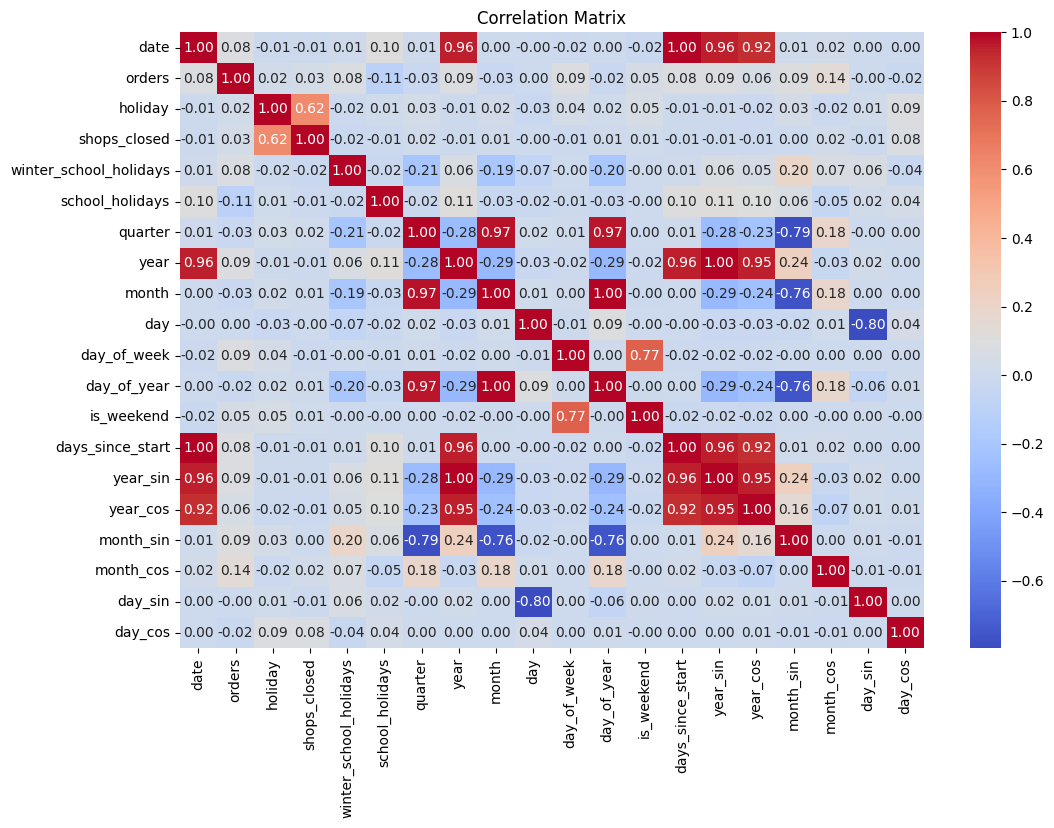

orders                    1.000000
month_cos                 0.142166
month_sin                 0.093846
day_of_week               0.086522
year_sin                  0.085921
year                      0.085920
days_since_start          0.080793
date                      0.080793
winter_school_holidays    0.077211
year_cos                  0.055939
is_weekend                0.046594
shops_closed              0.034824
holiday                   0.018006
day                       0.002689
day_sin                  -0.002125
day_cos                  -0.019233
day_of_year              -0.024332
month                    -0.025271
quarter                  -0.029323
school_holidays          -0.105071
Name: orders, dtype: float64


In [157]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Preprocessing
This is preprocessing function that applies:
<br>lag features
<br>one-hot encoding of categorical features
<br>feature-target split
<br>feature, target scaling
<br>return the final dataframe

In [232]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, redundant_features=[], inference=False, fill_method='ffill'):
    warehouse = df['warehouse'].iloc[0]
    redundant_df = df[redundant_features]
    df = df.drop(columns=redundant_features)
    
    if not inference:
        # Create lag and rolling features
        df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)
        
        x_scaler_features = x_scaler_features + lag_features + window_features
        
        # Handle NaN values in lag and rolling features
        if fill_method == 'ffill':
            df[lag_features + window_features] = df[lag_features + window_features].ffill().bfill()
        elif fill_method == 'zero':
            df[lag_features + window_features] = df[lag_features + window_features].fillna(0)

    # One-hot encoding for categorical features
    if not inference:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, f'onehot_scaler_{warehouse}.joblib')
    else:
        encoder = joblib.load(f'onehot_scaler_{warehouse}.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

    # Prepare features for scaling
    X = df.drop(columns=['orders'])
    y = df['orders']

    # Initialize and fit/transform scalers
    if not inference:
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_scaled = x_scaler.fit_transform(X[x_scaler_features])
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        joblib.dump(x_scaler, f'x_scaler_{warehouse}.joblib')
        joblib.dump(y_scaler, f'y_scaler_{warehouse}.joblib')
    else:
        x_scaler = joblib.load(f'x_scaler_{warehouse}.joblib')
        X_scaled = x_scaler.transform(X[x_scaler_features])
        y_scaler = joblib.load(f'y_scaler_{warehouse}.joblib')
        y_scaled = y_scaler.transform(y.values.reshape(-1, 1))

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)

    # Combine all features
    final_df = pd.concat([
        X_scaled_df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        df[binary_features],  # Binary features (unchanged)
        redundant_df  # Add redundant features back for the test data export
    ], axis=1)
    print(final_df.shape, y_scaled.shape)
    return final_df, y_scaled


### Outliers
Function to fix outliers - orders that are very high or very low. 
<br>Plot the outliers.
<br>Settings of the z-score and window that is outliers calculated with.

In [234]:
def z_score_outlier_detection(data, window=14, threshold=3):
    data = data.sort_index()
    rolling_mean = data.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = data.rolling(window=window, center=True, min_periods=1).std()
    z_scores = (data - rolling_mean) / rolling_std
    outliers = (np.abs(z_scores) > threshold) & (data != 0)
    lower_bound = rolling_mean - (threshold * rolling_std)
    upper_bound = rolling_mean + (threshold * rolling_std)
    return outliers, lower_bound, upper_bound


def weighted_trend_interpolation(data, outliers, window_size=10, weight=0.5):
    fixed_data = data.copy()
    for idx in np.where(outliers)[0]:
        start_idx = max(0, idx - window_size)
        end_idx = min(len(data), idx + window_size + 1)

        prev_values = data.iloc[start_idx:idx].dropna()
        next_values = data.iloc[idx + 1:end_idx].dropna()

        #print(f"Previous values: {prev_values}\n")
        #print(f"Next values: {next_values}\n")

        if len(prev_values) == 0:
            correction = next_values.mean()
        elif len(next_values) == 0:
            correction = prev_values.mean()
        else:
            mean_prev = prev_values.mean()
            mean_next = next_values.mean()

            if mean_next > mean_prev:
                trend = 'up'
            else:
                trend = 'down'

            # Calculate new value based on trend and retain some of the original intensity
            if trend == 'up':
                correction = mean_prev + (next_values.mean() - mean_prev) / 2
            else:
                correction = mean_prev - (mean_prev - next_values.mean()) / 2

        if np.isnan(correction):  # Handle cases where both prev_values and next_values are NaN
            correction = data.iloc[idx]

        fixed_data.iloc[idx] = weight * data.iloc[idx] + (1 - weight) * correction
        
        #print(f"Outlier at index {idx}: {data.iloc[idx]} -> {fixed_data.iloc[idx]}")
    return fixed_data


def plot_outlier_comparison(df, window=28, z_threshold=3, window_size=10, weight=0.5):
    warehouse_data = df['orders']

    z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
    fixed_warehouse_data = weighted_trend_interpolation(warehouse_data, z_outliers, window_size, weight)
    
    # Plot the original data and outliers
    plt.figure(figsize=(20, 10))
    plt.plot(warehouse_data.index, warehouse_data, label='Orders', alpha=0.7)
    plt.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
    plt.scatter(warehouse_data.index[z_outliers], warehouse_data[z_outliers], color='blue', label='Z-Score Outliers', marker='s')
    
    # Plot fixed outliers
    plt.scatter(warehouse_data.index[z_outliers], fixed_warehouse_data[z_outliers], color='green', label='Fixed Outliers', marker='x')
    plt.title(f'{df["warehouse"].iloc[0]} - Outlier Comparison')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{df['warehouse'].iloc[0]}:")
    print(f"Z-Score Outliers: {sum(z_outliers)}")
    
    # Update the DataFrame with fixed values
    df.loc[:, 'orders'] = fixed_warehouse_data
    
    return df


In [ ]:
# Outliers calculation for when ye do use the "off_day" feature instead of the previous block. 
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def z_score_outlier_detection(data, window=14, threshold=3):
    # Exclude rows where 'off_day' == 1
    mask = data['off_day'] != 1
    data_filtered = data[mask].copy()
    data_filtered['orders'] = data_filtered['orders'].sort_index()
    
    rolling_mean = data_filtered['orders'].rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = data_filtered['orders'].rolling(window=window, center=True, min_periods=1).std()
    z_scores = (data_filtered['orders'] - rolling_mean) / rolling_std
    outliers_filtered = (np.abs(z_scores) > threshold) & (data_filtered['orders'] != 0)
    lower_bound_filtered = rolling_mean - (threshold * rolling_std)
    upper_bound_filtered = rolling_mean + (threshold * rolling_std)
    
    # Create full-length arrays with NaN for excluded indices
    outliers = pd.Series(np.nan, index=data.index)
    lower_bound = pd.Series(np.nan, index=data.index)
    upper_bound = pd.Series(np.nan, index=data.index)
    
    outliers[mask] = outliers_filtered
    lower_bound[mask] = lower_bound_filtered
    upper_bound[mask] = upper_bound_filtered
    
    return outliers, lower_bound, upper_bound

def weighted_trend_interpolation(data, outliers, window_size=10, weight=0.5):
    fixed_data = data['orders'].copy()
    for idx in np.where(outliers)[0]:
        start_idx = max(0, idx - window_size)
        end_idx = min(len(data), idx + window_size + 1)

        prev_values = data['orders'].iloc[start_idx:idx].dropna()
        next_values = data['orders'].iloc[idx + 1:end_idx].dropna()

        if len(prev_values) == 0:
            correction = next_values.mean()
        elif len(next_values) == 0:
            correction = prev_values.mean()
        else:
            mean_prev = prev_values.mean()
            mean_next = next_values.mean()

            if mean_next > mean_prev:
                trend = 'up'
            else:
                trend = 'down'

            # Calculate new value based on trend and retain some of the original intensity
            if trend == 'up':
                correction = mean_prev + (next_values.mean() - mean_prev) / 2
            else:
                correction = mean_prev - (mean_prev - next_values.mean()) / 2

        if np.isnan(correction):  # Handle cases where both prev_values and next_values are NaN
            correction = data['orders'].iloc[idx]

        fixed_data.iloc[idx] = weight * data['orders'].iloc[idx] + (1 - weight) * correction
        
    return fixed_data

def plot_outlier_comparison(df, window=28, z_threshold=3, window_size=10, weight=0.5):
    warehouse_data = df[['orders', 'off_day']]
    non_off_day_data = warehouse_data[warehouse_data['off_day'] != 1]

    z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
    fixed_warehouse_data = weighted_trend_interpolation(warehouse_data, z_outliers, window_size, weight)
    
    # Plot the original data and outliers
    plt.figure(figsize=(20, 10))
    plt.plot(non_off_day_data.index, non_off_day_data['orders'], label='Orders', alpha=0.7)
    plt.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
    plt.scatter(warehouse_data.index[z_outliers.dropna().index], warehouse_data['orders'][z_outliers.dropna().index], color='blue', label='Z-Score Outliers', marker='s')
    
    # Plot fixed outliers
    plt.scatter(warehouse_data.index[z_outliers.dropna().index], fixed_warehouse_data[z_outliers.dropna().index], color='green', label='Fixed Outliers', marker='x')
    plt.title(f'{df["warehouse"].iloc[0]} - Outlier Comparison')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{df['warehouse'].iloc[0]}:")
    print(f"Z-Score Outliers: {sum(z_outliers.dropna())}")
    
    # Update the DataFrame with fixed values
    df.loc[:, 'orders'] = fixed_warehouse_data
    
    return df
"""

'\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndef z_score_outlier_detection(data, window=14, threshold=3):\n    # Exclude rows where \'off_day\' == 1\n    mask = data[\'off_day\'] != 1\n    data_filtered = data[mask].copy()\n    data_filtered[\'orders\'] = data_filtered[\'orders\'].sort_index()\n    \n    rolling_mean = data_filtered[\'orders\'].rolling(window=window, center=True, min_periods=1).mean()\n    rolling_std = data_filtered[\'orders\'].rolling(window=window, center=True, min_periods=1).std()\n    z_scores = (data_filtered[\'orders\'] - rolling_mean) / rolling_std\n    outliers_filtered = (np.abs(z_scores) > threshold) & (data_filtered[\'orders\'] != 0)\n    lower_bound_filtered = rolling_mean - (threshold * rolling_std)\n    upper_bound_filtered = rolling_mean + (threshold * rolling_std)\n    \n    # Create full-length arrays with NaN for excluded indices\n    outliers = pd.Series(np.nan, index=data.index)\n    lower_bound = pd.Series(np.nan,

In [235]:
train_df.isna().sum()

warehouse                   0
date                        0
orders                    397
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
quarter                     0
year                        0
month                       0
day                         0
day_of_week                 0
day_of_year                 0
is_weekend                  0
days_since_start            0
year_sin                    0
year_cos                    0
month_sin                   0
month_cos                   0
day_sin                     0
day_cos                     0
dtype: int64

### Get train and test dataframe
Put all above together in a loop that produces:

- Reduces outliers
- Train dataframe dictionary for every warehouse a dataframe
- Test dataframe with lag features and scaled 


Processing warehouse: Brno_1


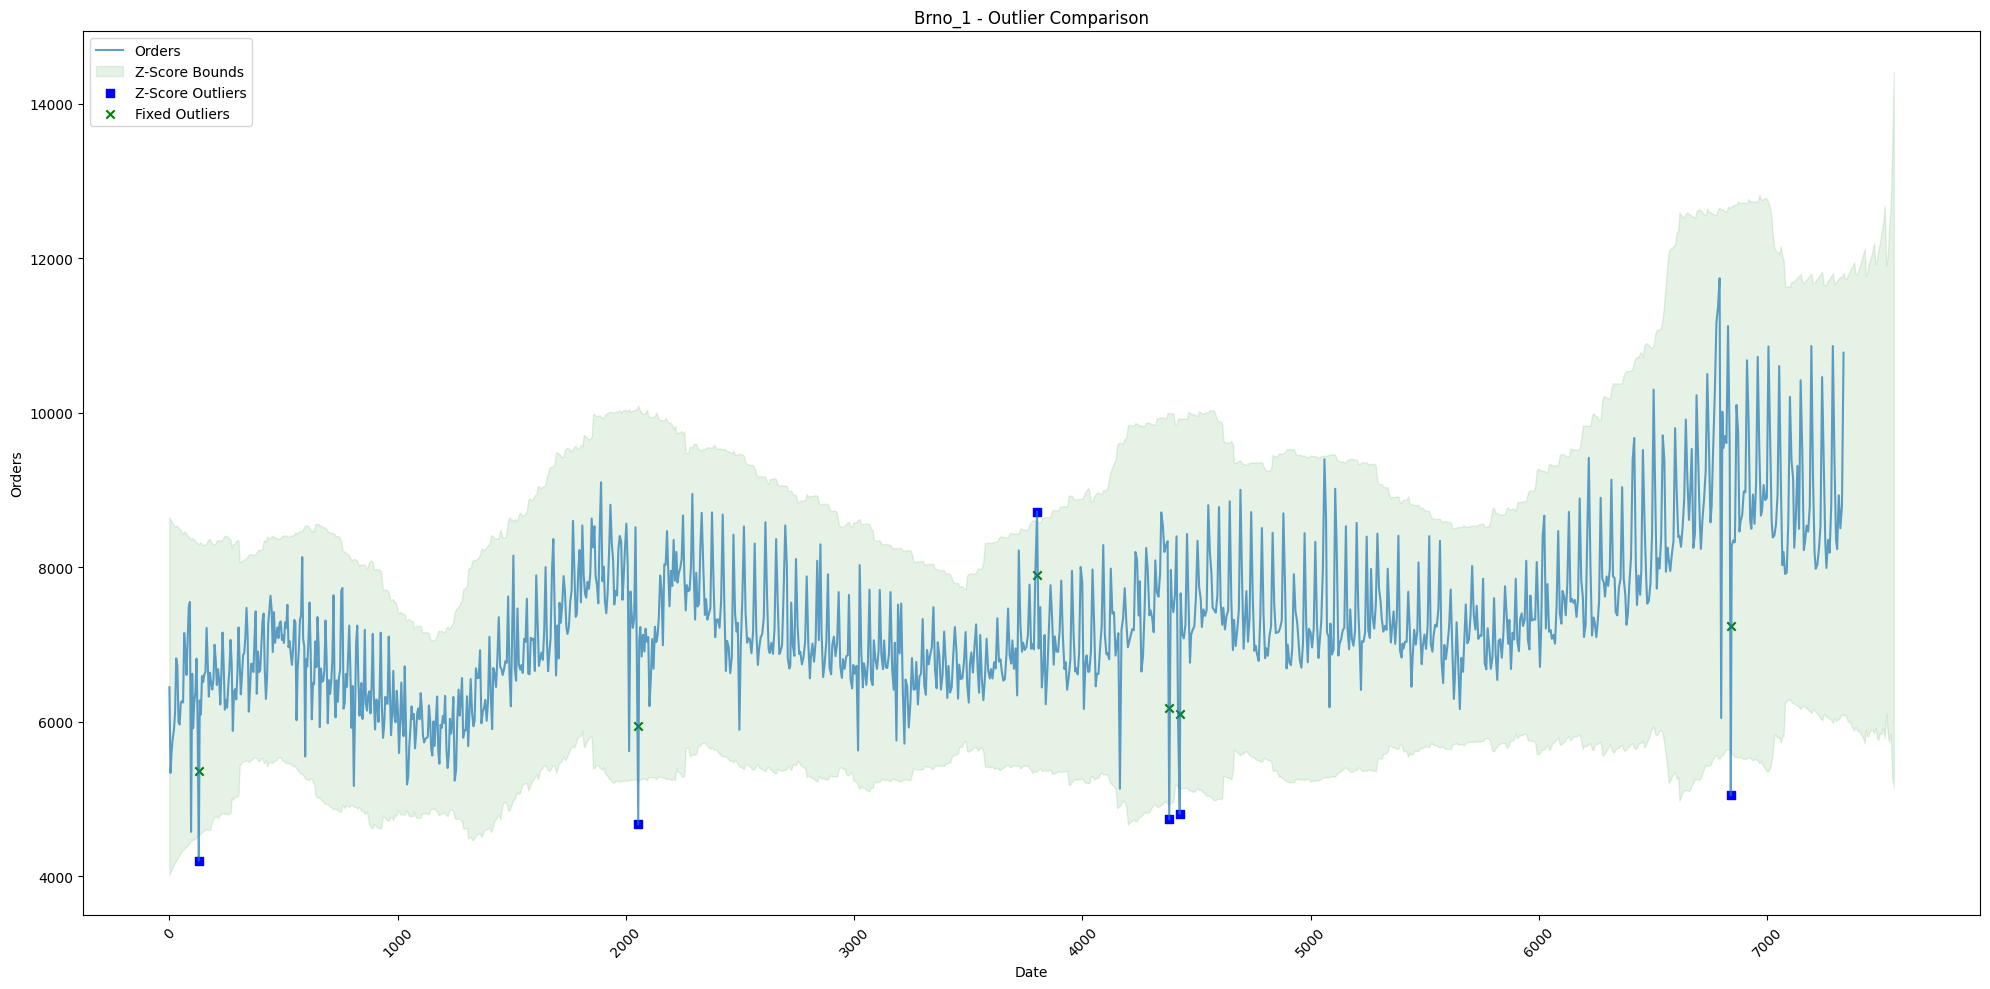


Brno_1:
Z-Score Outliers: 6
(1254, 51) (1254, 1)
Processed:
train data shape: (1193, 51), (1193,)
test data shape: (61, 51)
y nans: 0


Processing warehouse: Budapest_1


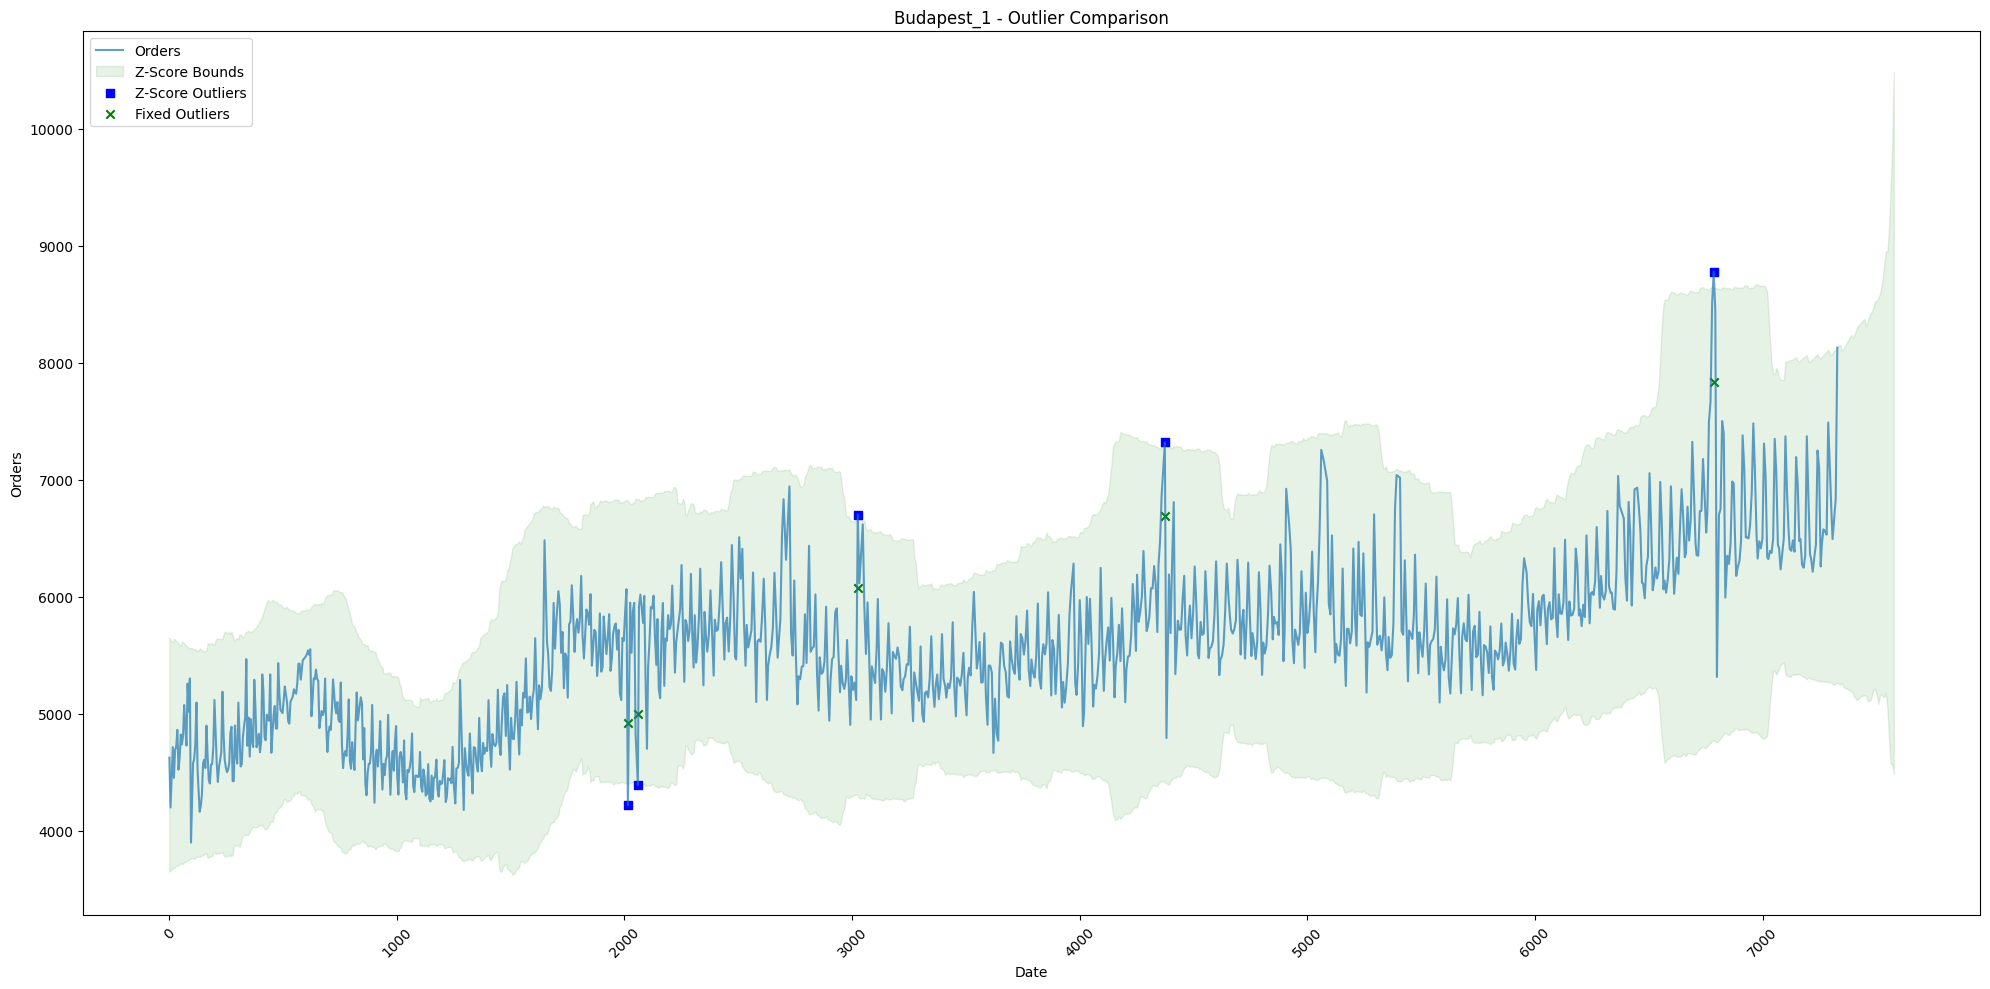


Budapest_1:
Z-Score Outliers: 5
(1211, 51) (1211, 1)
Processed:
train data shape: (1154, 51), (1154,)
test data shape: (57, 51)
y nans: 0


Processing warehouse: Prague_1


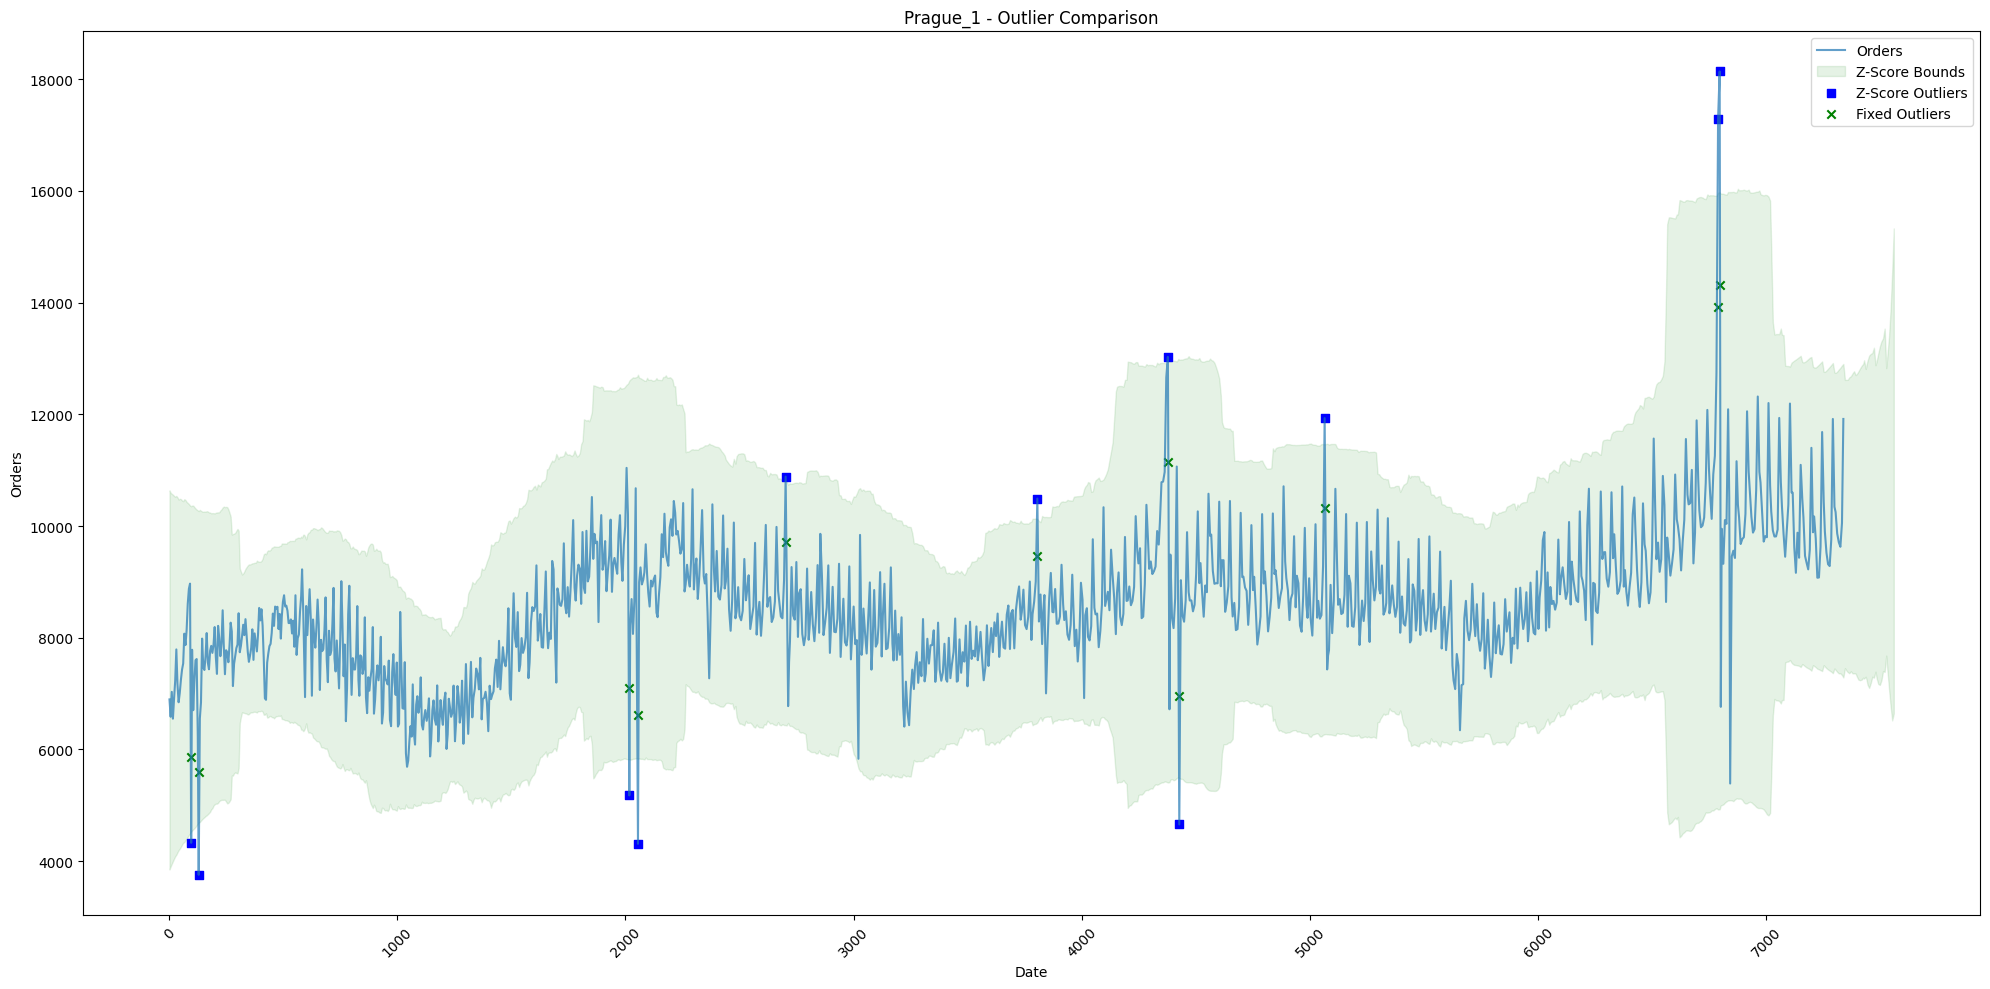


Prague_1:
Z-Score Outliers: 11
(1254, 51) (1254, 1)
Processed:
train data shape: (1193, 51), (1193,)
test data shape: (61, 51)
y nans: 0


Processing warehouse: Prague_2


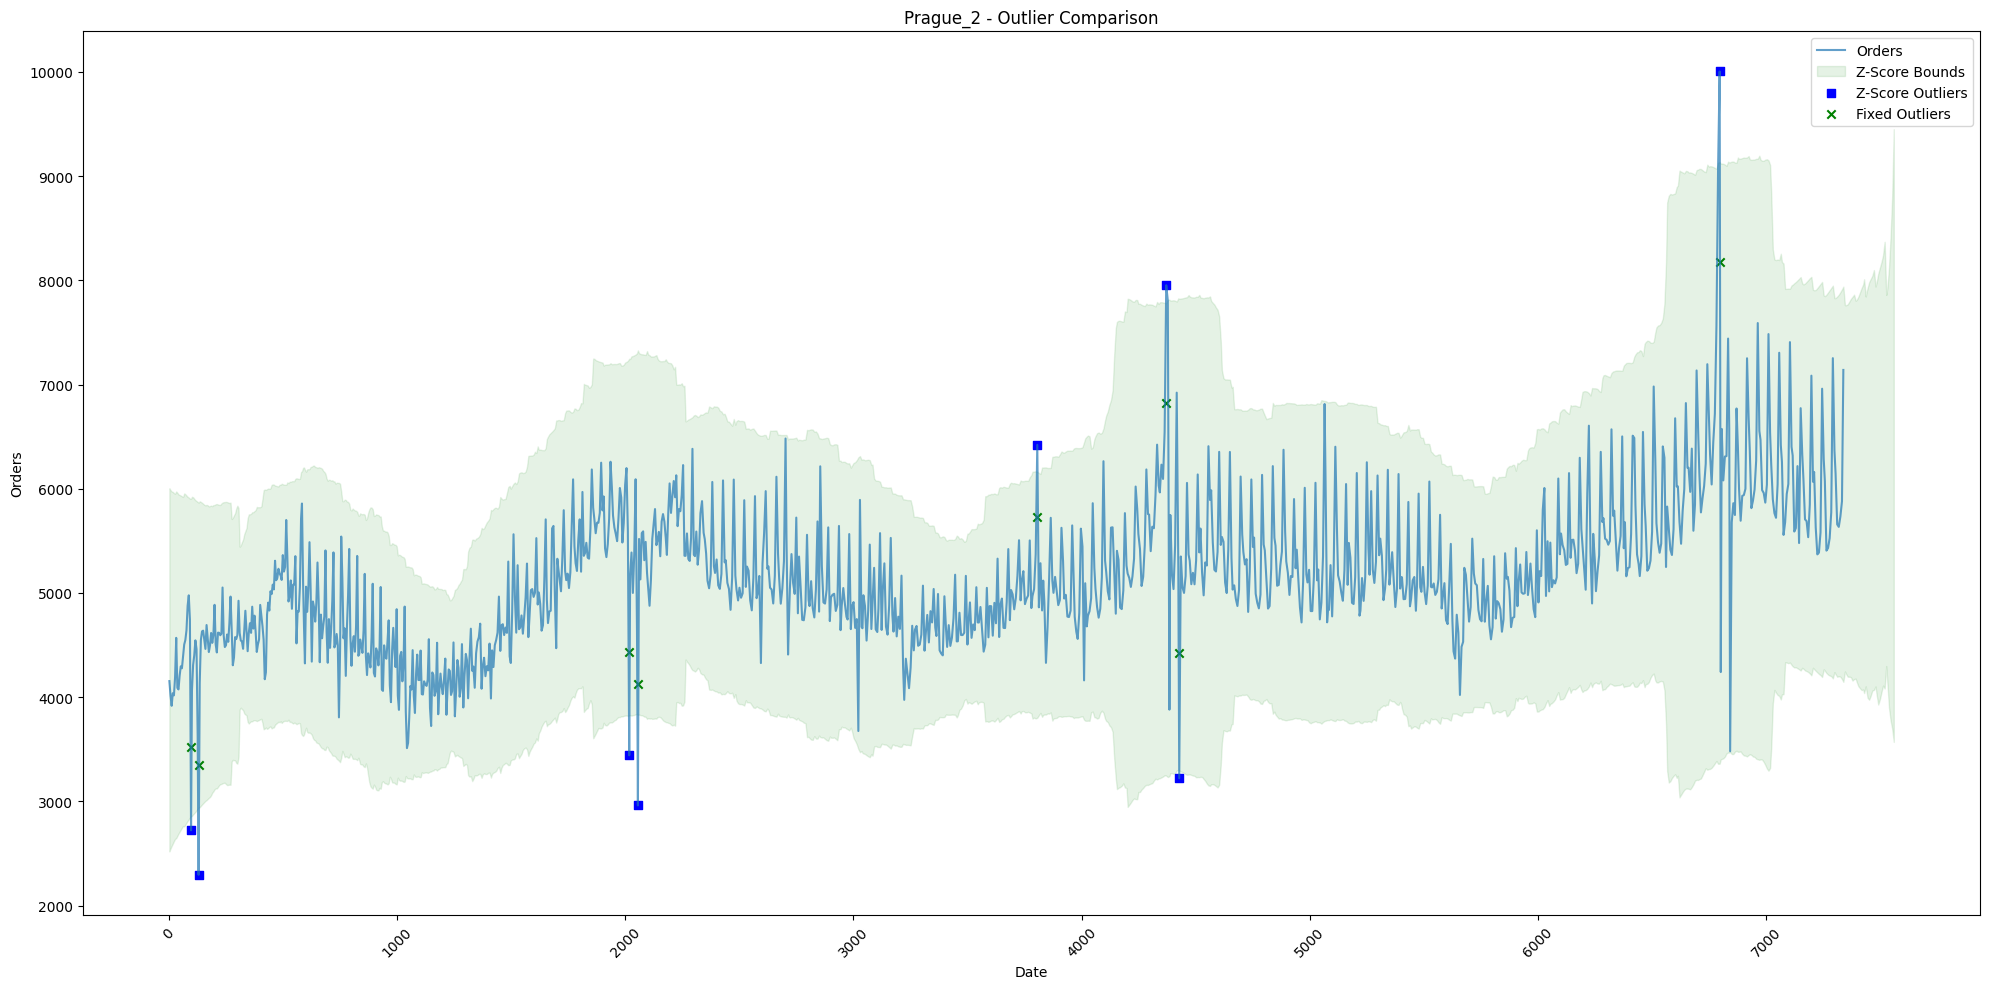


Prague_2:
Z-Score Outliers: 8
(1254, 51) (1254, 1)
Processed:
train data shape: (1193, 51), (1193,)
test data shape: (61, 51)
y nans: 0


Processing warehouse: Prague_3


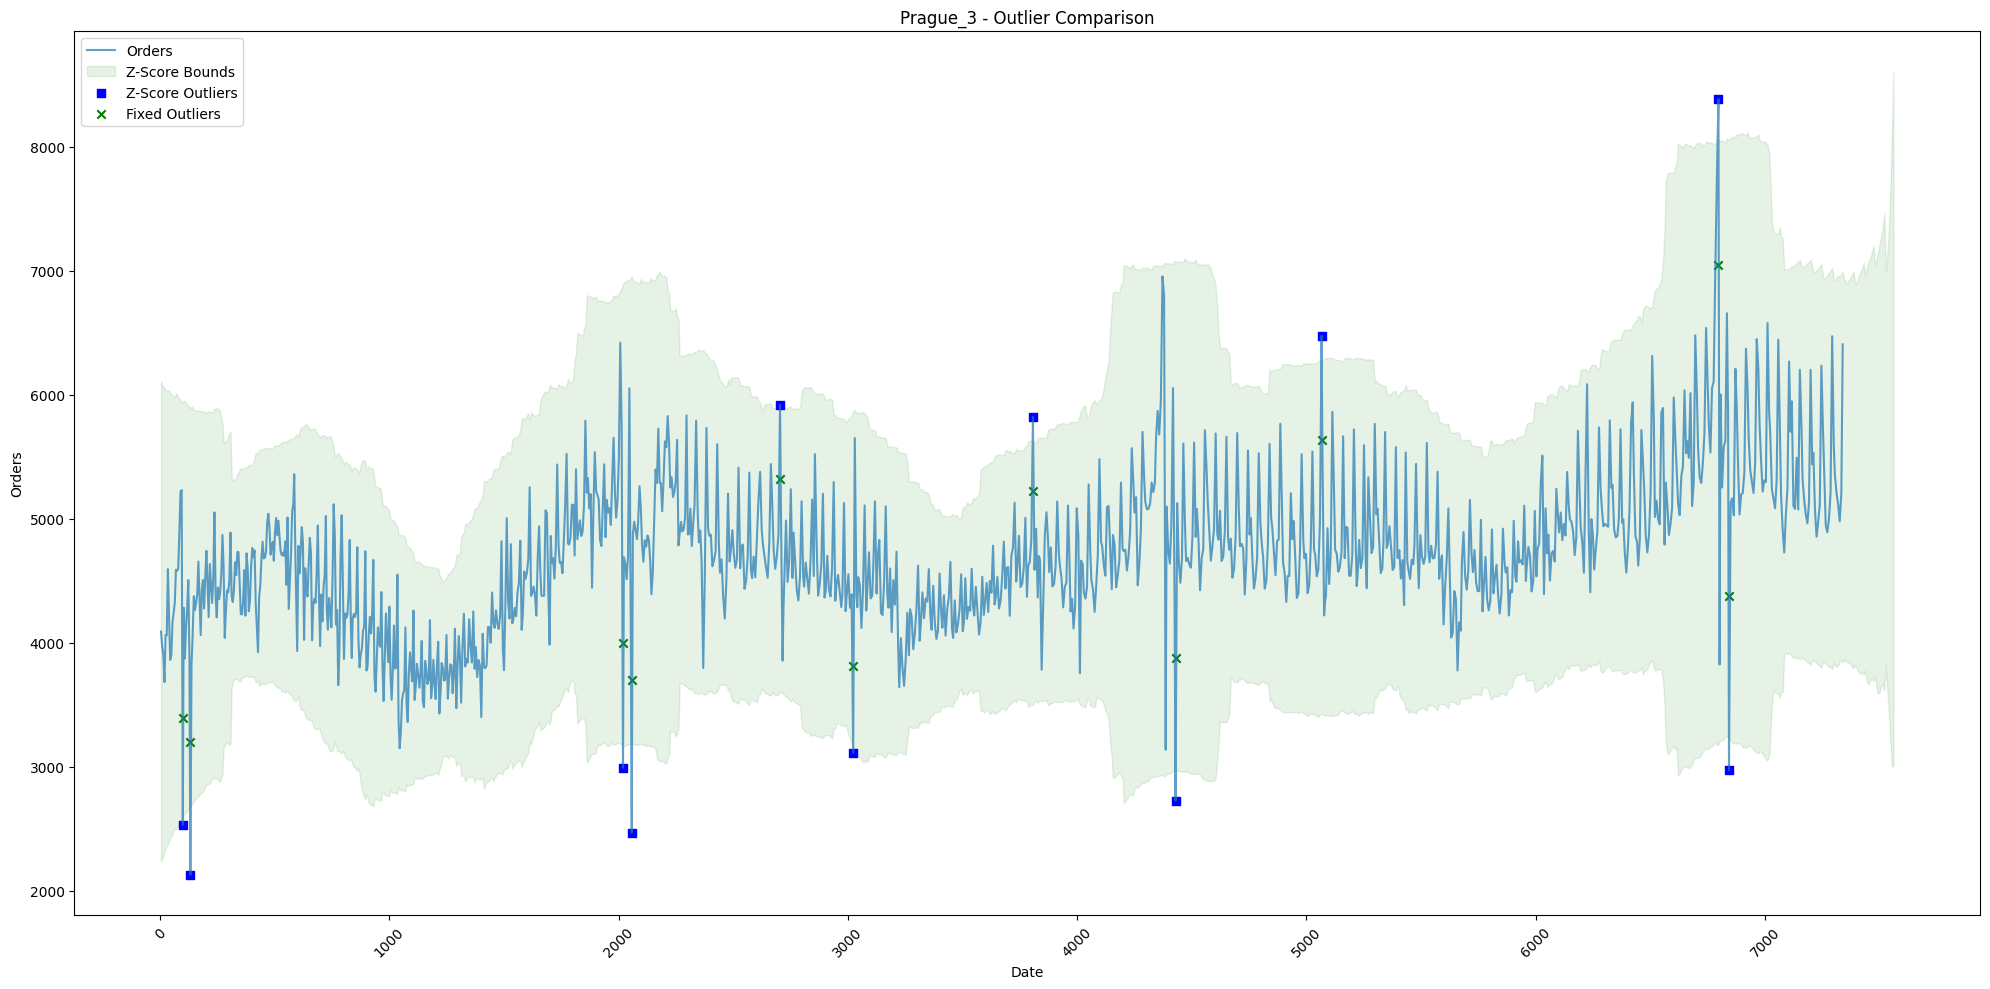


Prague_3:
Z-Score Outliers: 11
(1254, 51) (1254, 1)
Processed:
train data shape: (1193, 51), (1193,)
test data shape: (61, 51)
y nans: 0


Processing warehouse: Munich_1


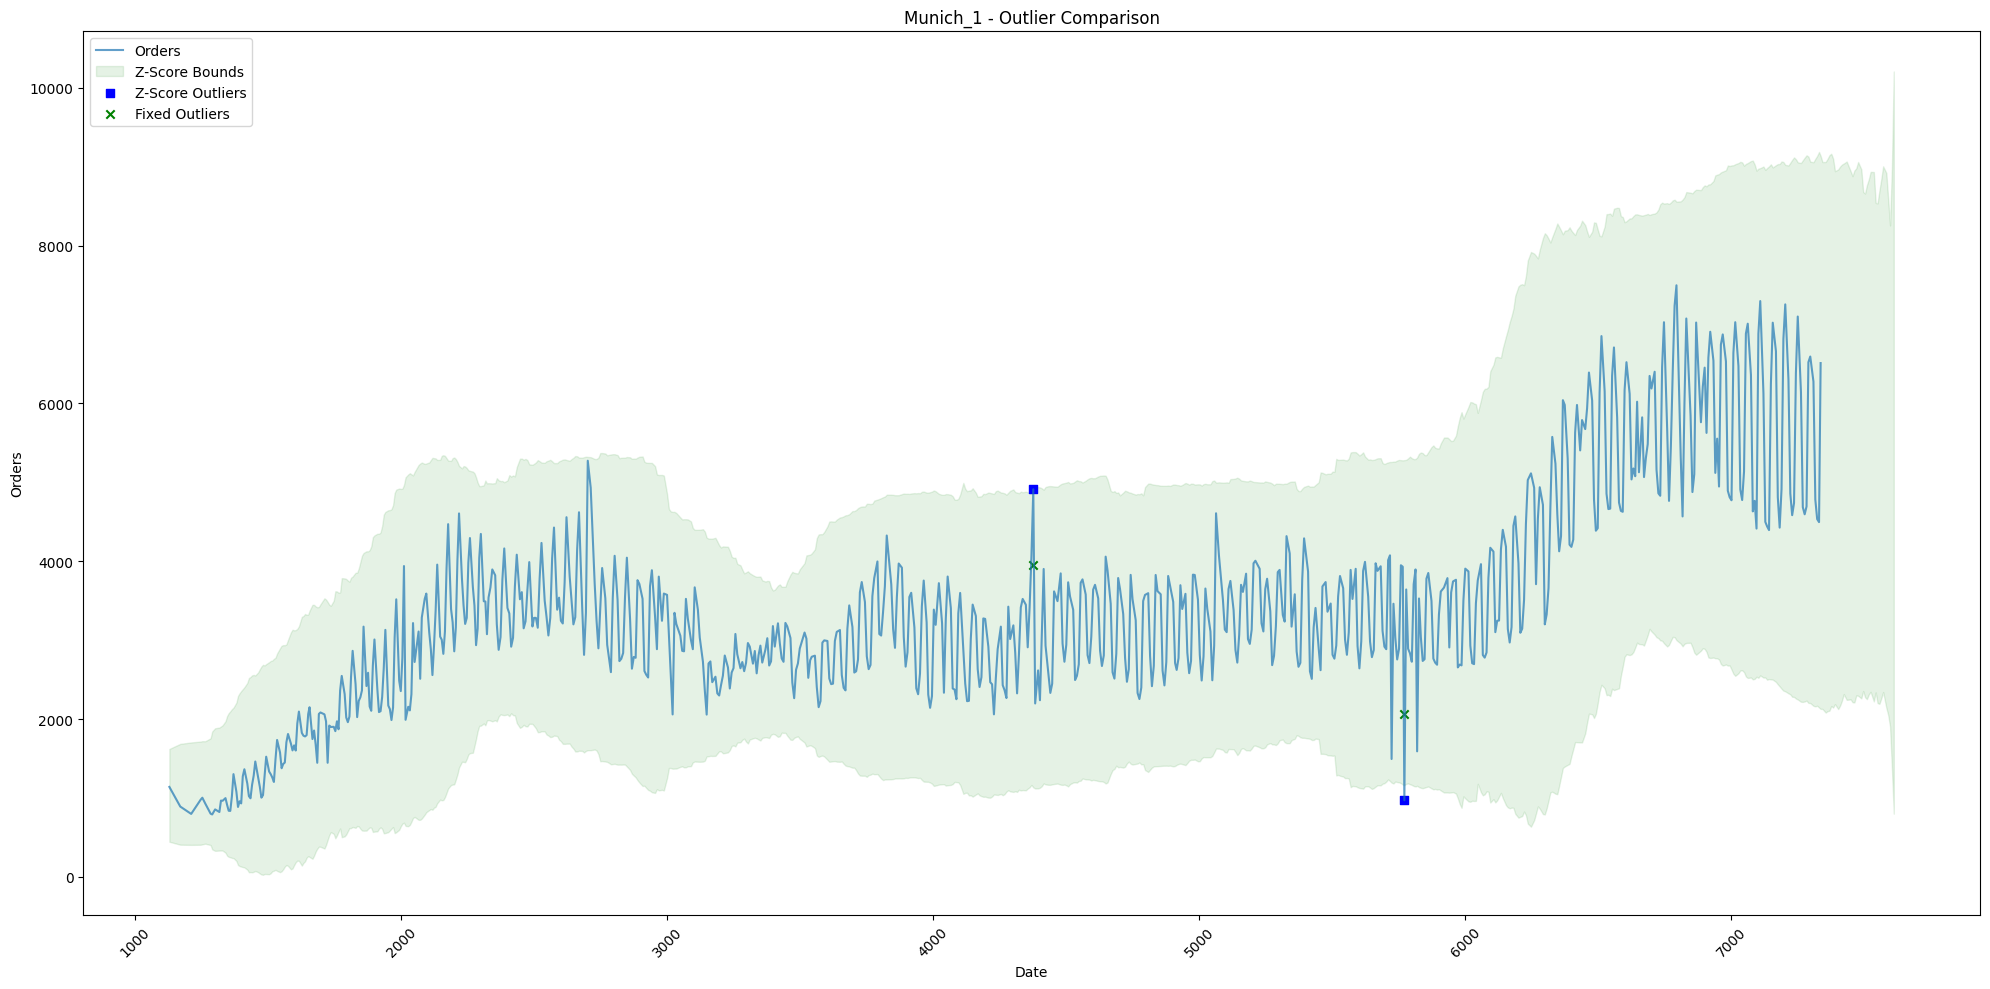


Munich_1:
Z-Score Outliers: 2
(833, 50) (833, 1)
Processed:
train data shape: (785, 50), (785,)
test data shape: (48, 50)
y nans: 0


Processing warehouse: Frankfurt_1


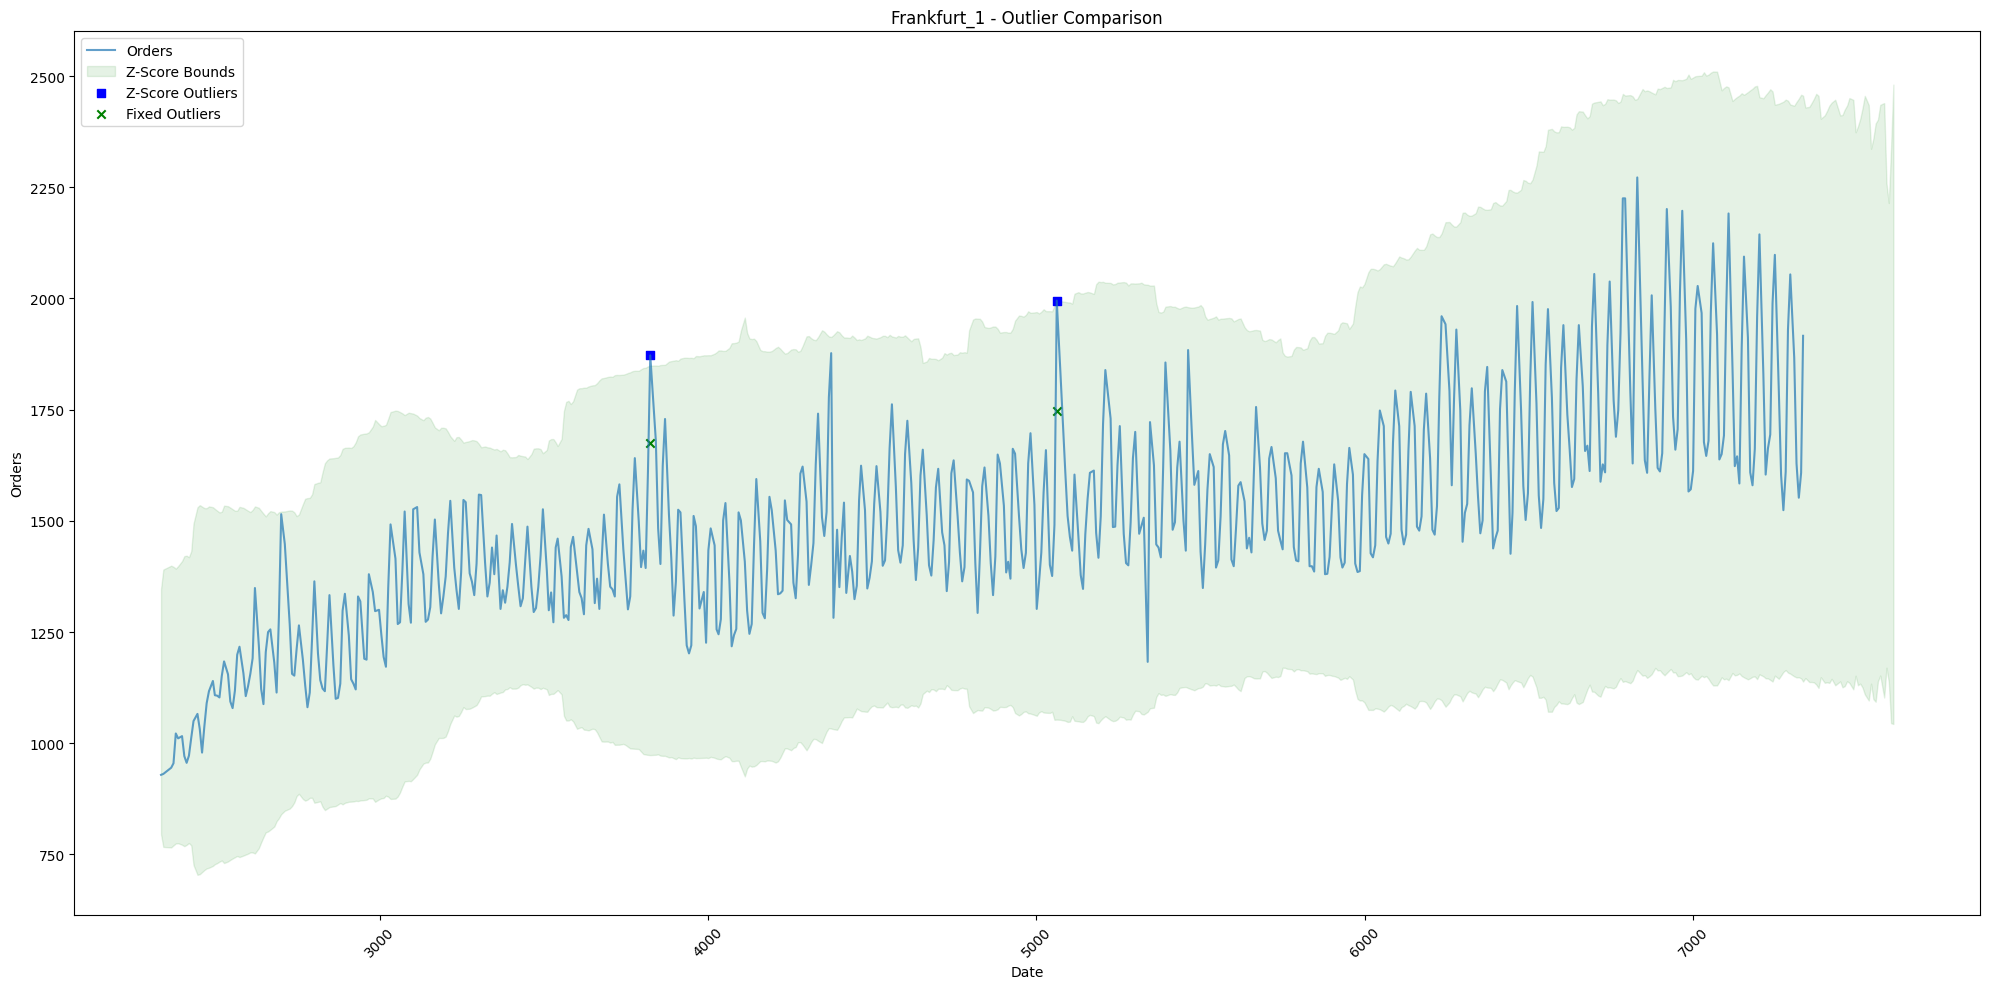


Frankfurt_1:
Z-Score Outliers: 2
(677, 48) (677, 1)
Processed:
train data shape: (629, 48), (629,)
test data shape: (48, 48)
y nans: 0




In [236]:
features = [f'orders_lag_{lag}' for lag in LAG_DAYS]
features2 = [f'orders_rolling_mean_{window}' for window in ROLLING_WINDOW]

# Get unique warehouses
warehouses = train_df['warehouse'].unique()

# Create separate dataframes for each warehouse
warehouse_dfs = {wh: train_df[train_df['warehouse'] == wh].copy() for wh in warehouses}

# Preprocess each warehouse dataframe
processed_train_data_dict = {}
processed_test_data = []

for warehouse, df in warehouse_dfs.items():
    print(f"Processing warehouse: {warehouse}")
    
    # Sort dataframe by date ascendentaly
    df = df.sort_values(by=['date'])

    # Get indices of NaN values in 'orders' column
    nan_indices = df[df['orders'].isna()].index

    # Plot outlier comparison if needed
    df = plot_outlier_comparison(df, window=70, z_threshold=3.3, weight=0.5)

    # Preprocess data
    X_processed, y_processed = preprocess_data(df, 
                                               categorical_features, 
                                               x_scaler_features, 
                                               binary_features, 
                                               redundant_features=['warehouse', 'id', 'date'], 
                                               inference=False, 
                                               fill_method='ffill')
    

    
    # Get test data using NaN indices
    test_data = X_processed.loc[nan_indices]
    
    # Convert index to integer positions for np.delete
    nan_positions = X_processed.index.get_indexer(nan_indices)
    
    # Drop NaN indices from processed data
    X_processed = X_processed.drop(nan_indices)
    y_processed = np.delete(y_processed, nan_positions)
    
    processed_test_data.append(test_data)
    processed_train_data_dict[warehouse] = (X_processed, y_processed)
    
    print(f"Processed:\ntrain data shape: {X_processed.shape}, {y_processed.shape}")
    print("test data shape:", test_data.shape)
    print(f"y nans: {sum(np.isnan(y_processed))}")
    print("\n")
    
# Combine all test data rows into a single DataFrame
processed_test_df = pd.concat(processed_test_data)

In [237]:
# Save the test dataset for future use
processed_test_df.to_csv('data/test_proc_mt.csv')

### Plot the test data
Visualise the training dataset with new features for every warehouse timeline

C:\Users\ondre\AppData\Local\Temp\ipykernel_14408\2869787637.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


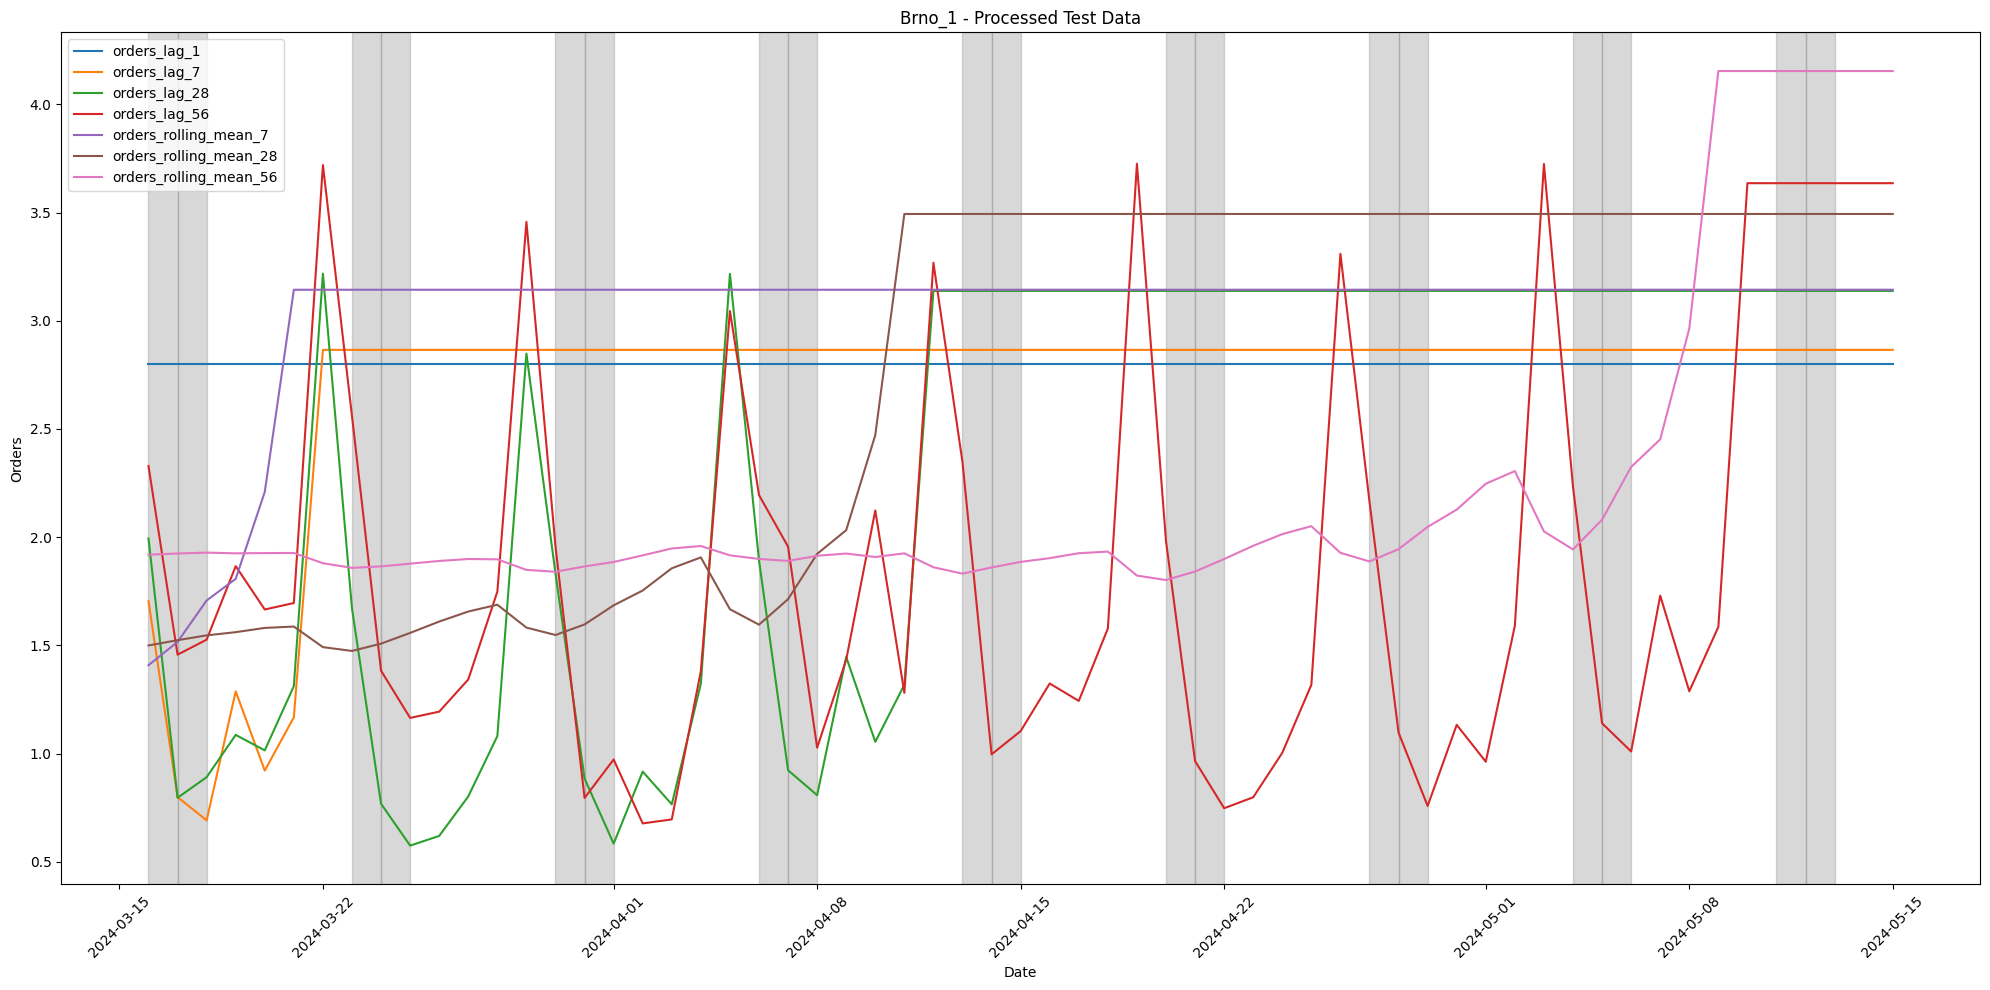

C:\Users\ondre\AppData\Local\Temp\ipykernel_14408\2869787637.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


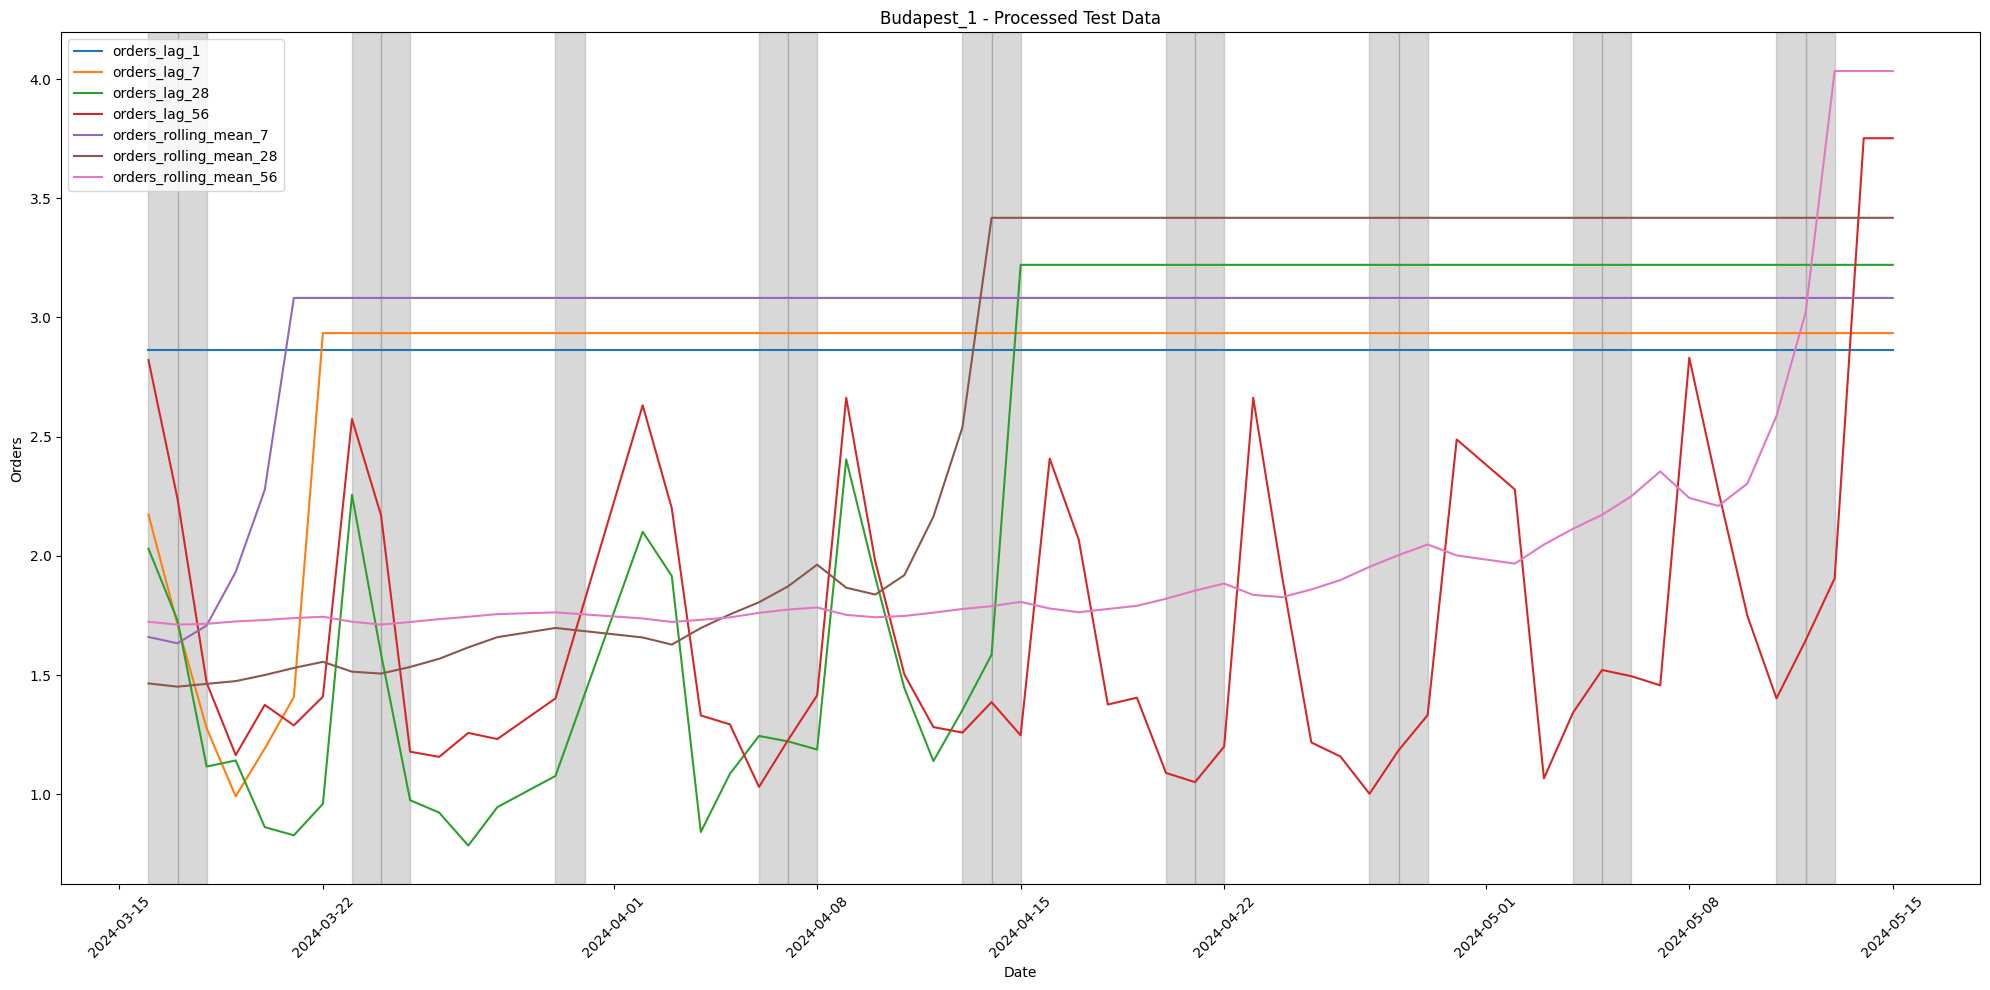

C:\Users\ondre\AppData\Local\Temp\ipykernel_14408\2869787637.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


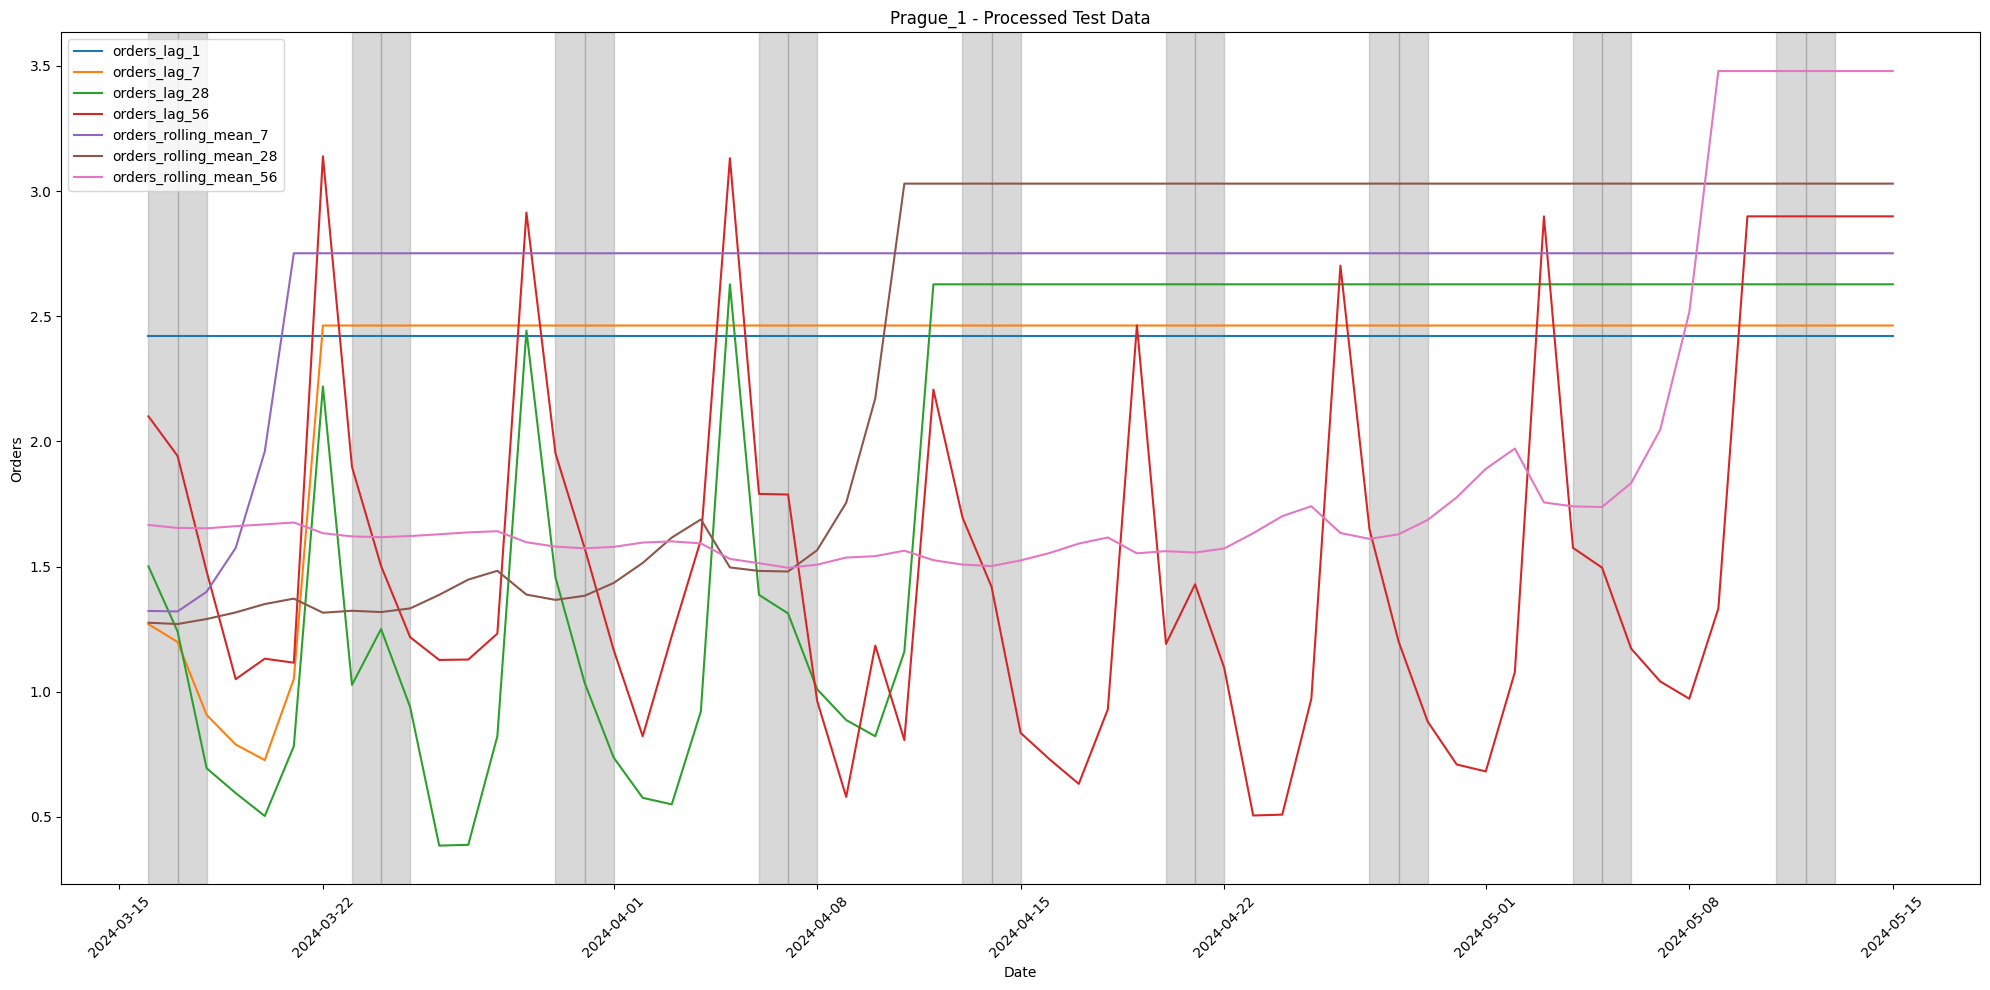

C:\Users\ondre\AppData\Local\Temp\ipykernel_14408\2869787637.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


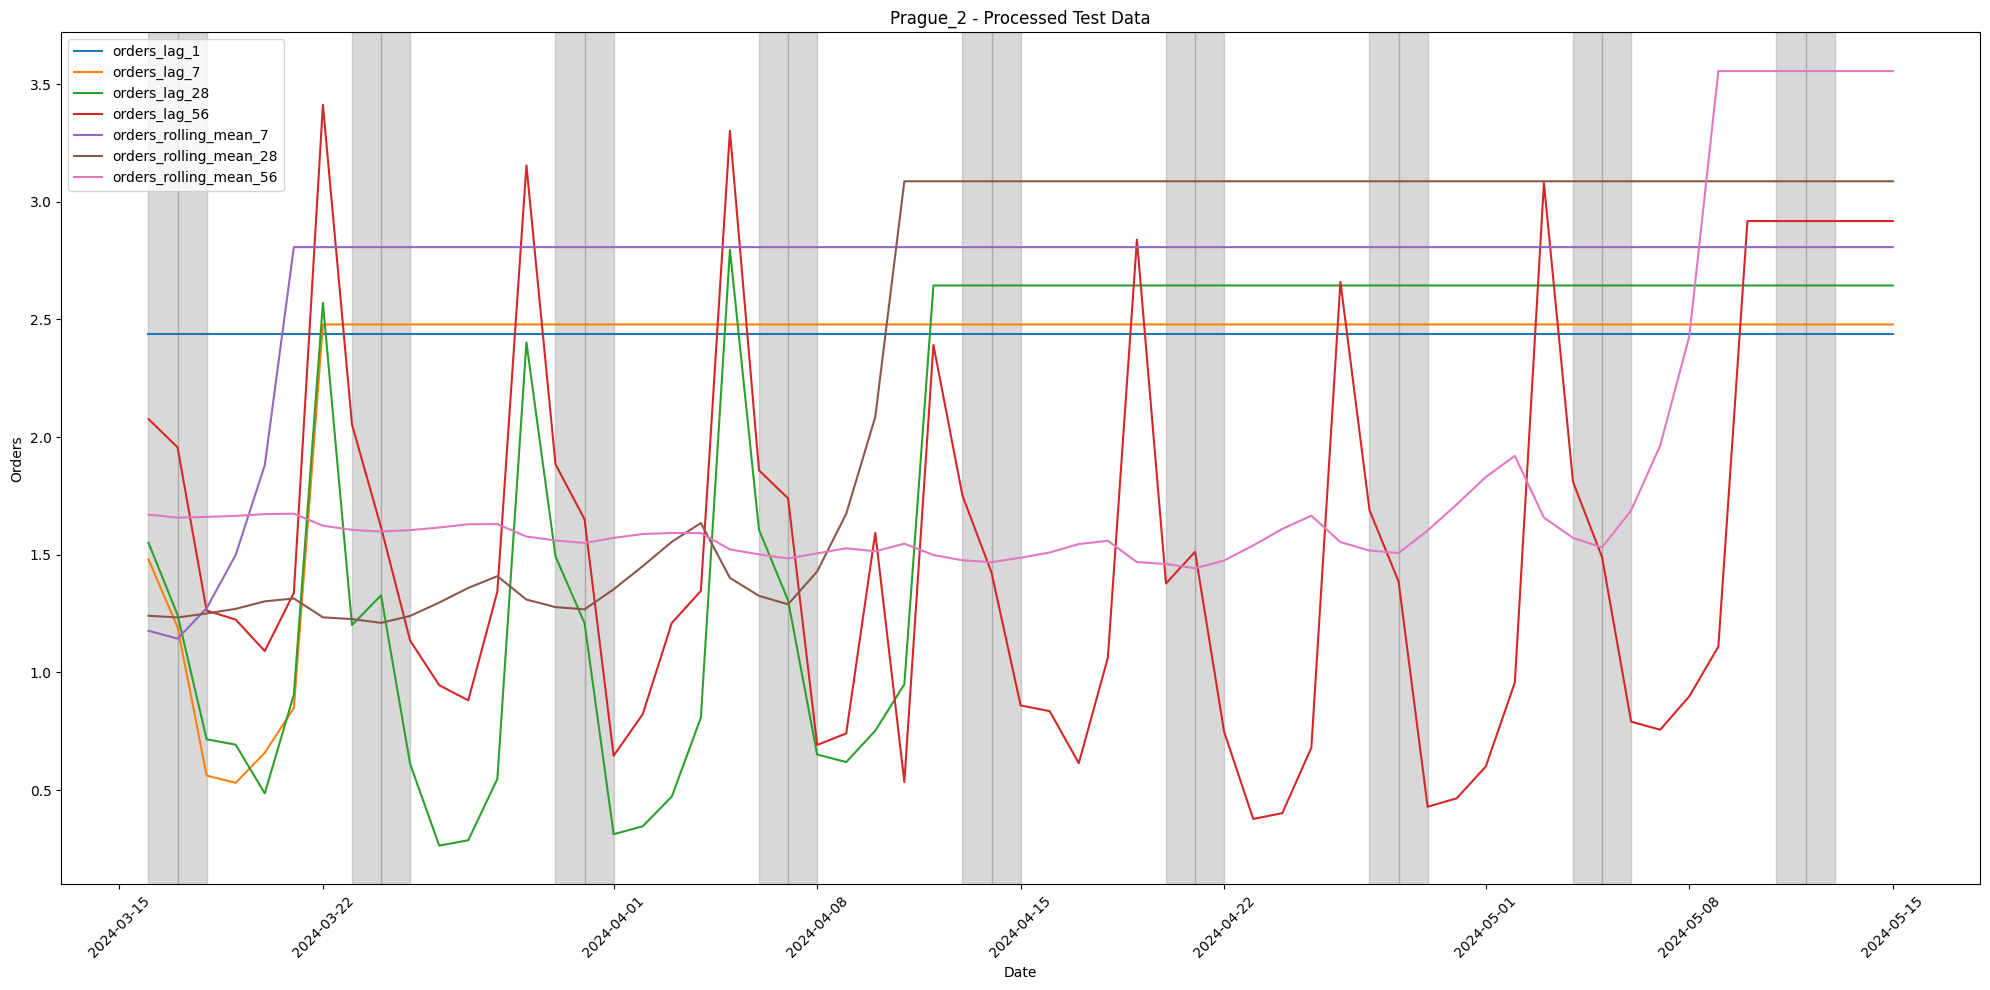

C:\Users\ondre\AppData\Local\Temp\ipykernel_14408\2869787637.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


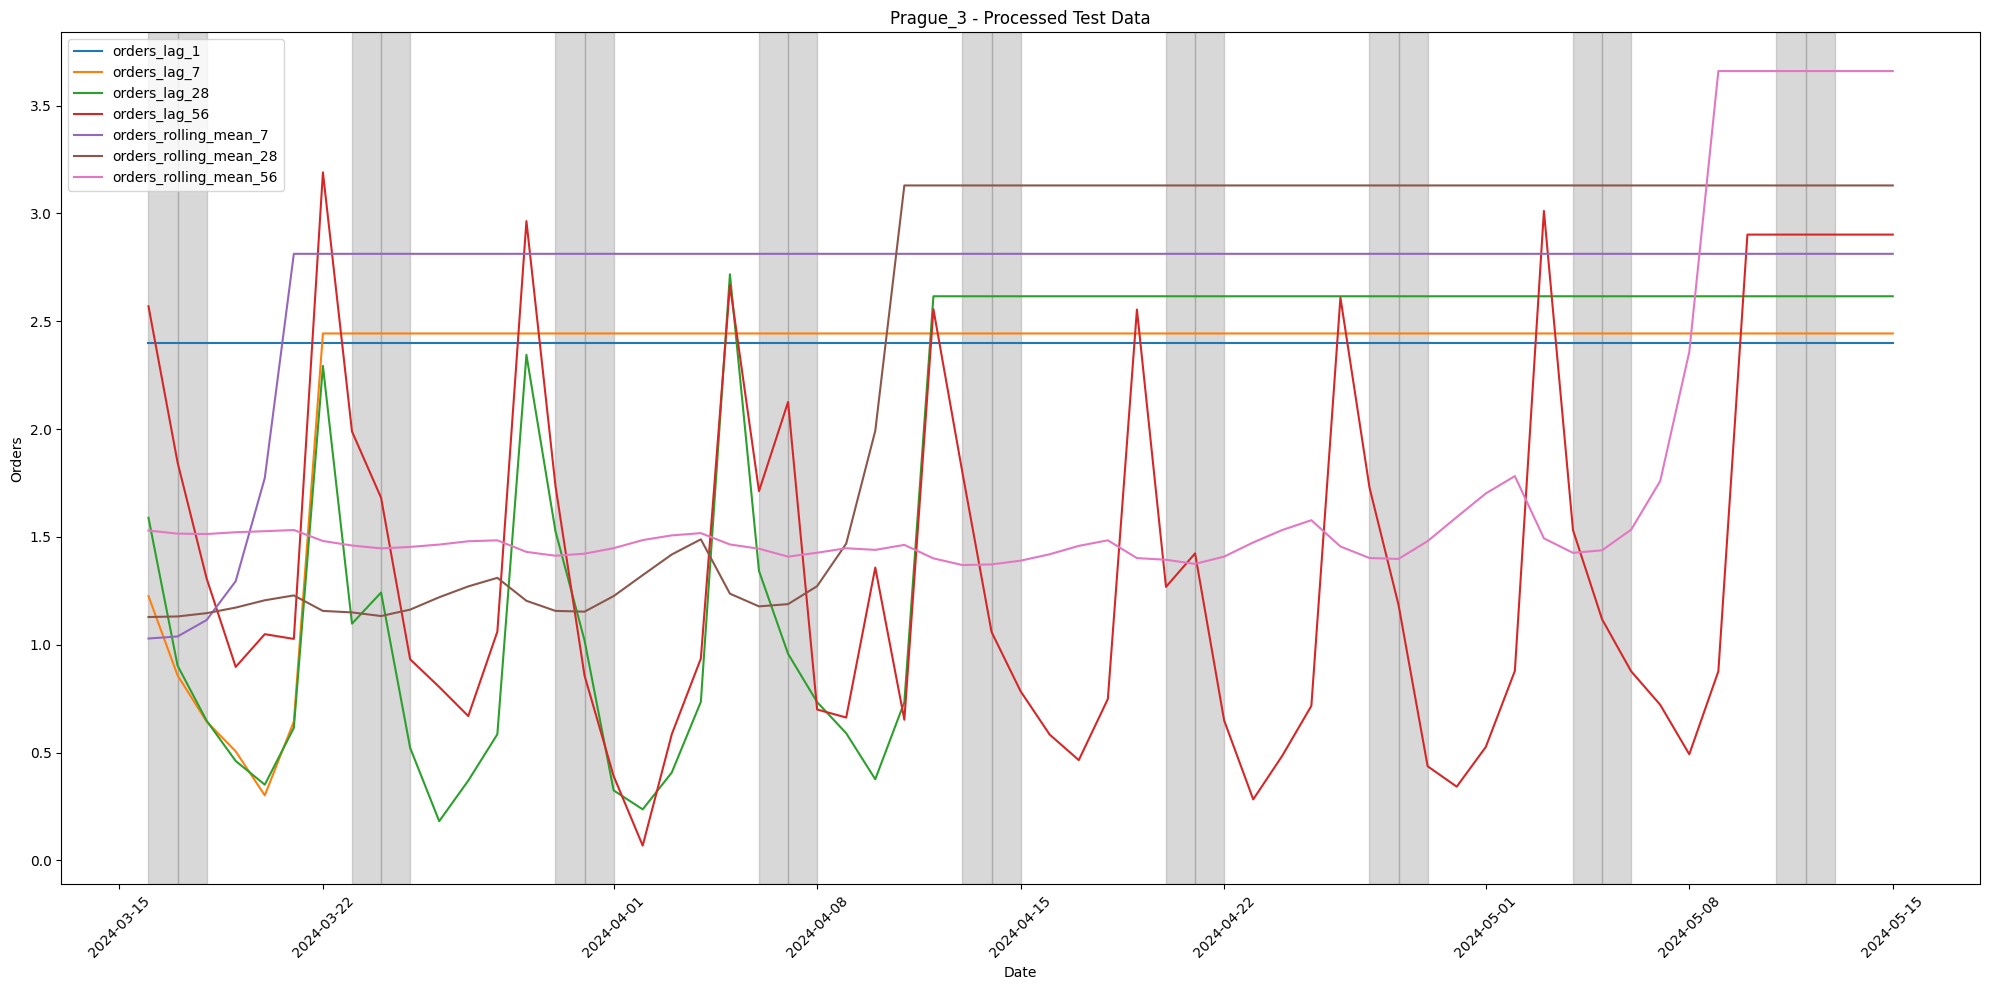

C:\Users\ondre\AppData\Local\Temp\ipykernel_14408\2869787637.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


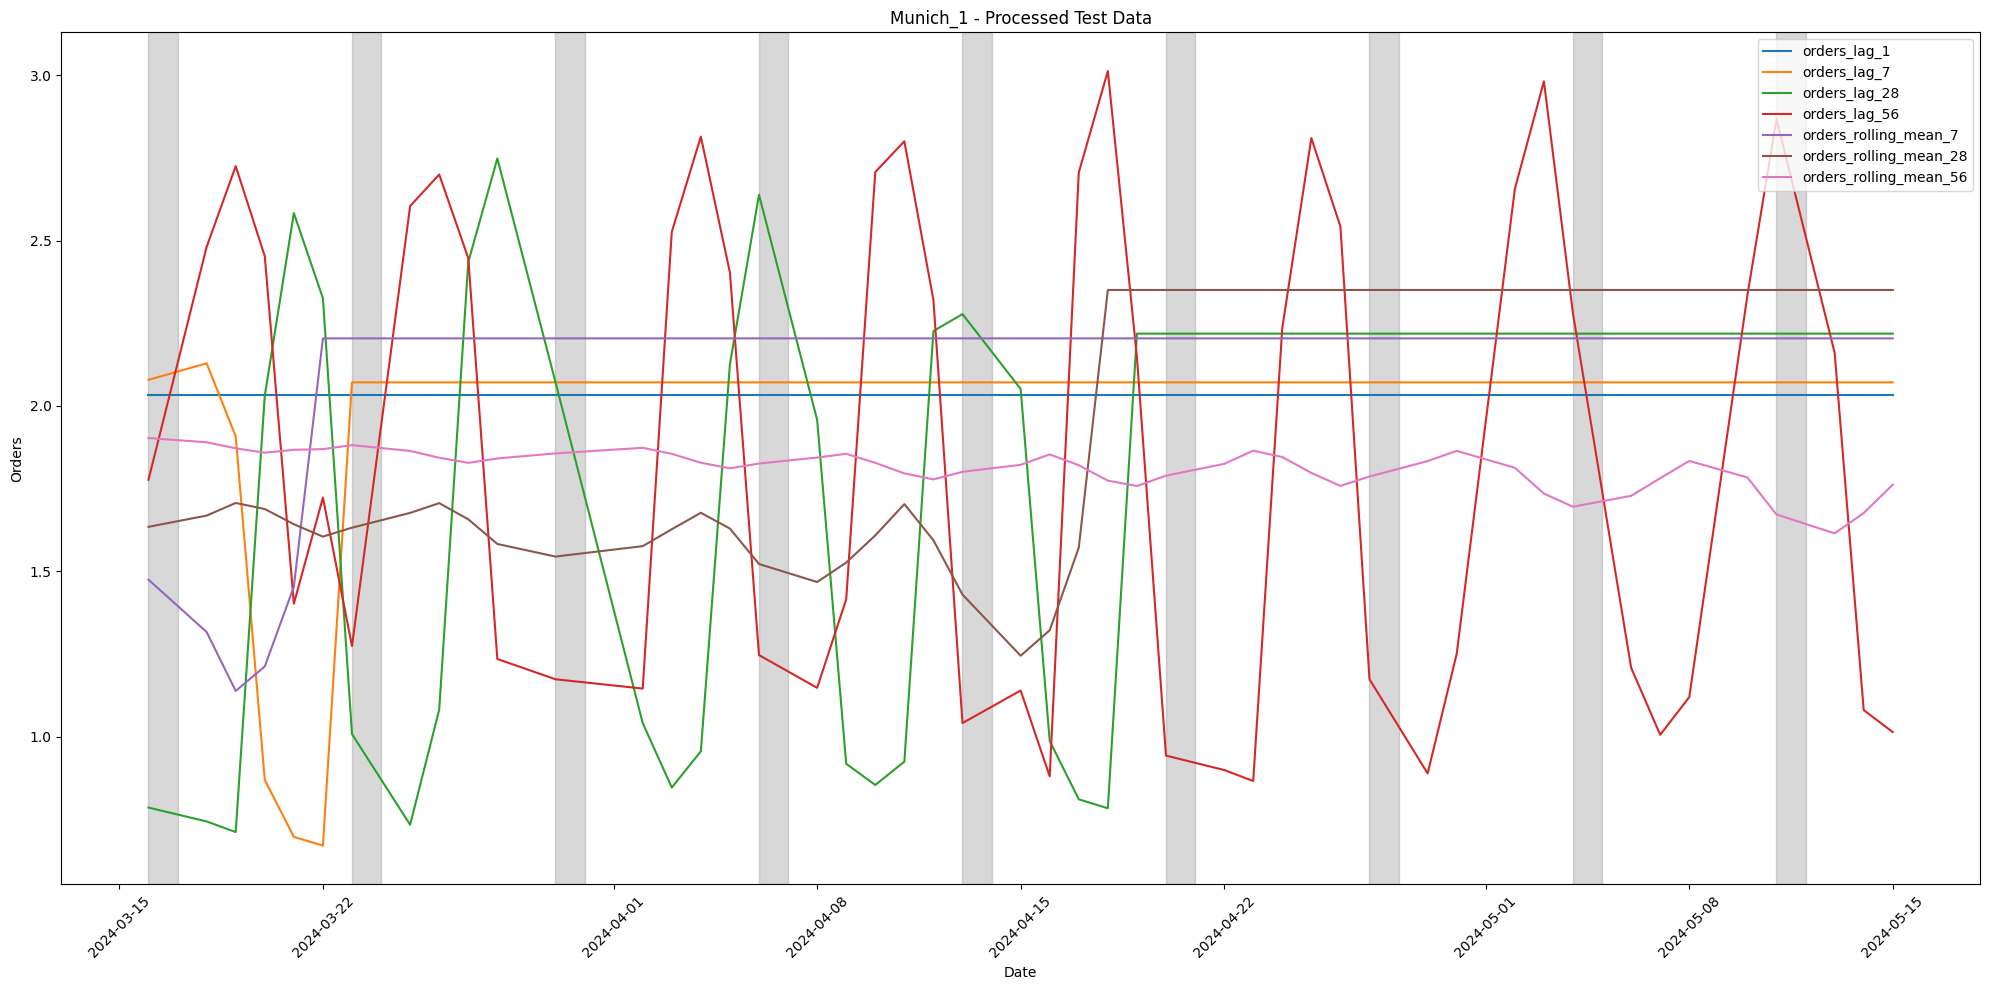

C:\Users\ondre\AppData\Local\Temp\ipykernel_14408\2869787637.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)


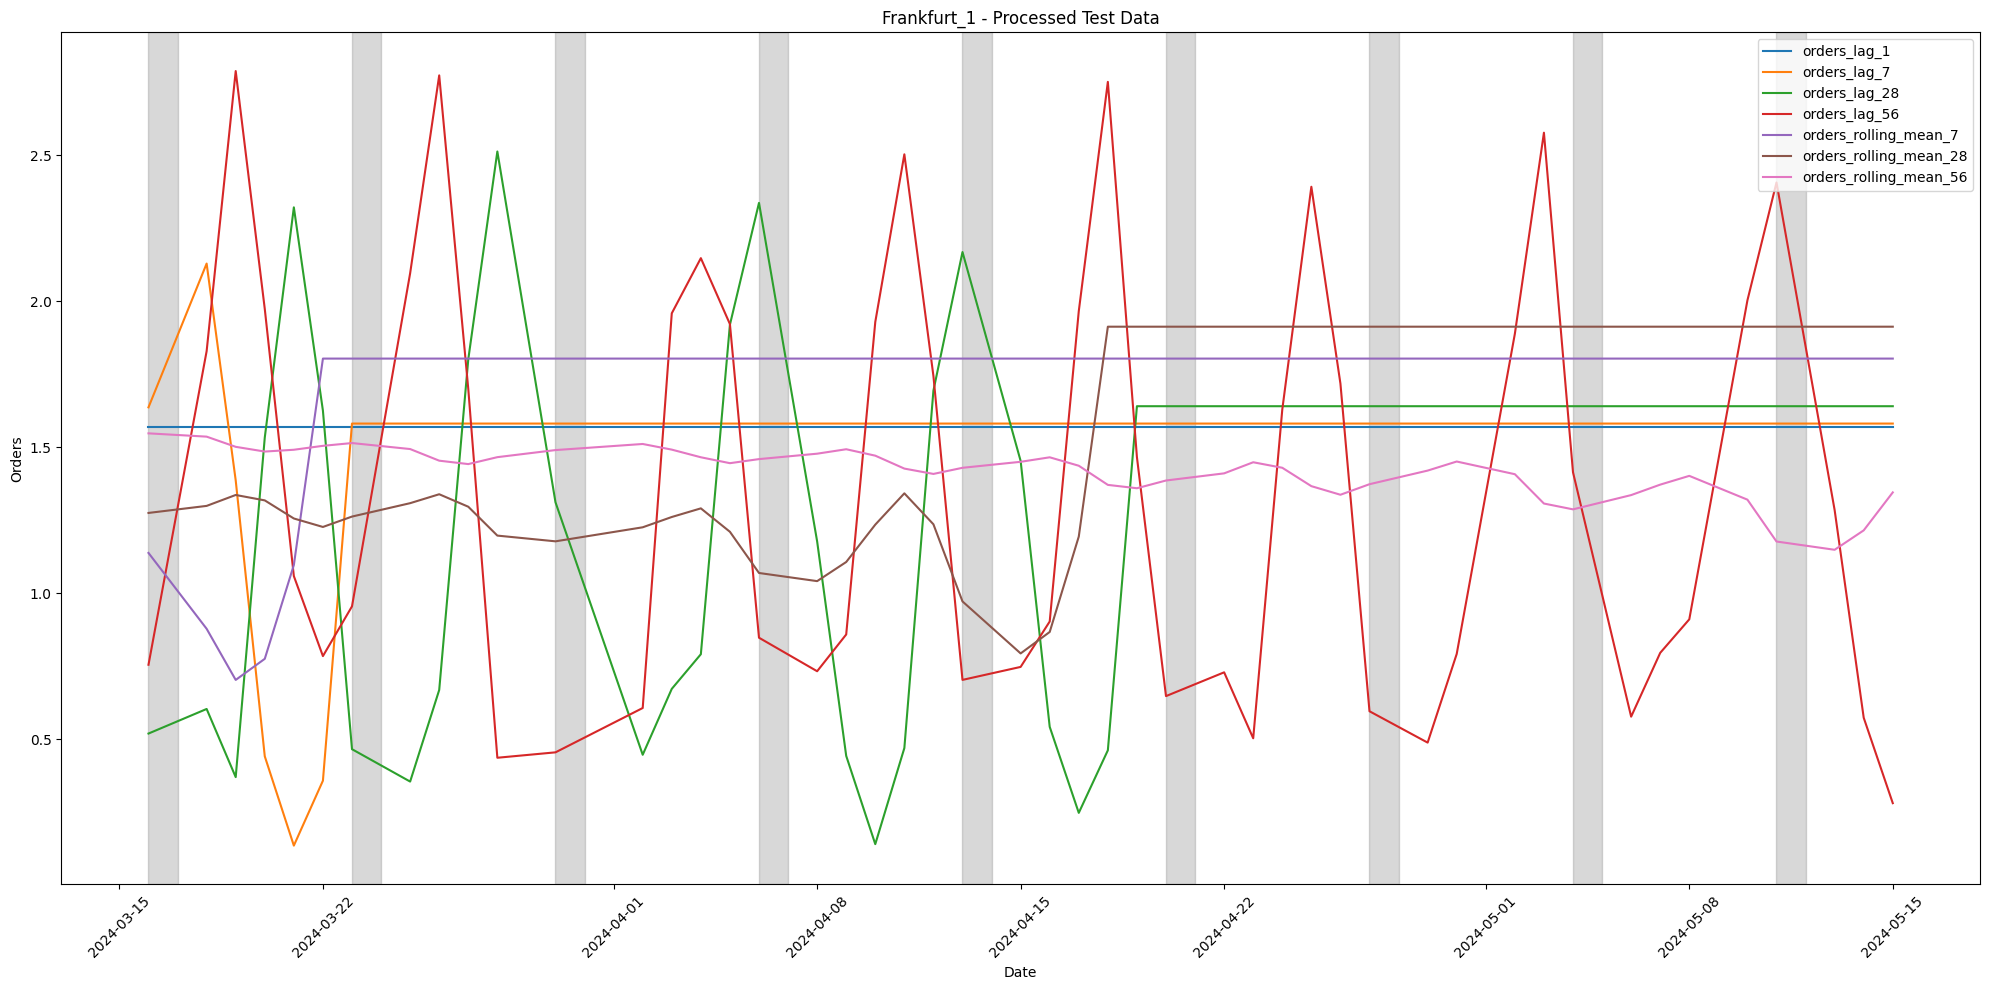

In [238]:
features = [f'orders_lag_{lag}' for lag in LAG_DAYS]
features2 = [f'orders_rolling_mean_{window}' for window in ROLLING_WINDOW]

def is_weekend(date):
    return date.weekday() >= 5

# Plot the processed test data:
for wh in processed_test_df['warehouse'].unique():
    wh_df = processed_test_df[processed_test_df['warehouse'] == wh]
    plt.figure(figsize=(20, 10))
    
    plt.plot(wh_df["date"], wh_df[features[0]], label=features[0])
    plt.plot(wh_df["date"], wh_df[features[1]], label=features[1])
    plt.plot(wh_df["date"], wh_df[features[2]], label=features[2])
    plt.plot(wh_df["date"], wh_df[features[3]], label=features[3])
    plt.plot(wh_df["date"], wh_df[features2[0]], label=features2[0])
    plt.plot(wh_df["date"], wh_df[features2[1]], label=features2[1])
    plt.plot(wh_df["date"], wh_df[features2[2]], label=features2[2])
    
    # Shade weekends
    wh_df['is_weekend'] = wh_df['date'].apply(is_weekend)
    weekends = wh_df[wh_df['is_weekend']]
    for i, row in weekends.iterrows():
        plt.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), color='gray', alpha=0.3)
    
    plt.title(f'{wh} - Processed Test Data')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Plot LAG features
Visualise LAG features of train and test back to back with the real orders

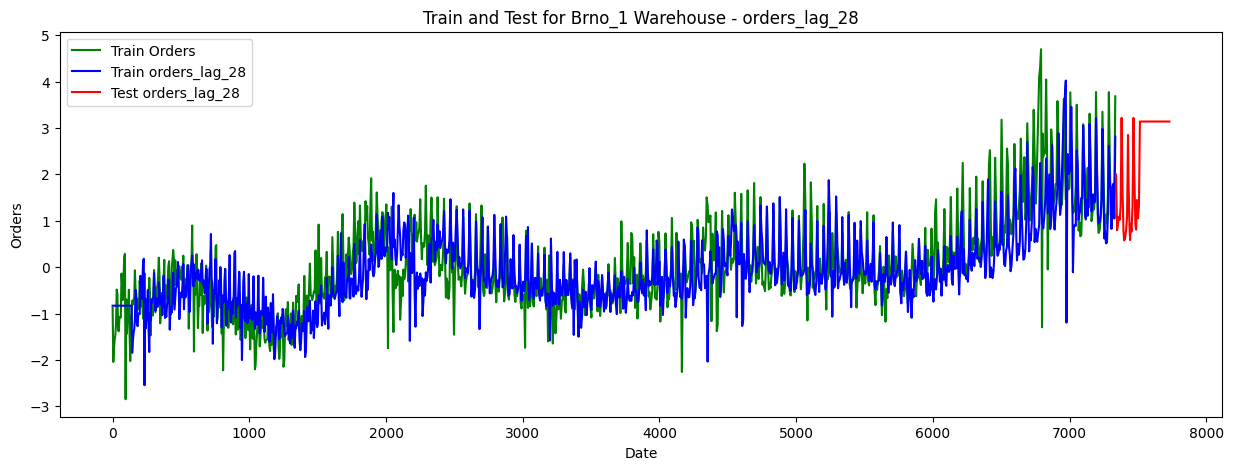

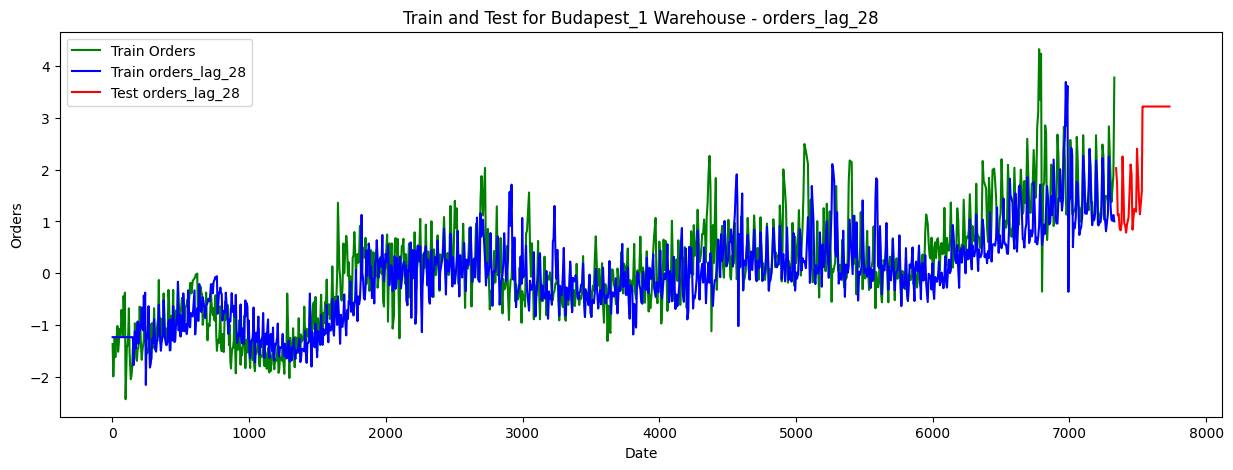

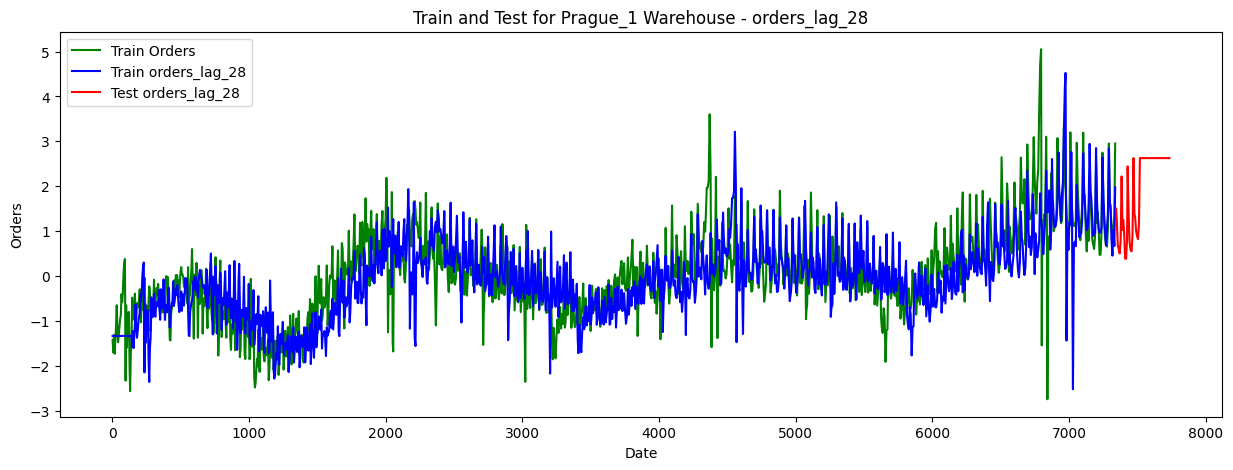

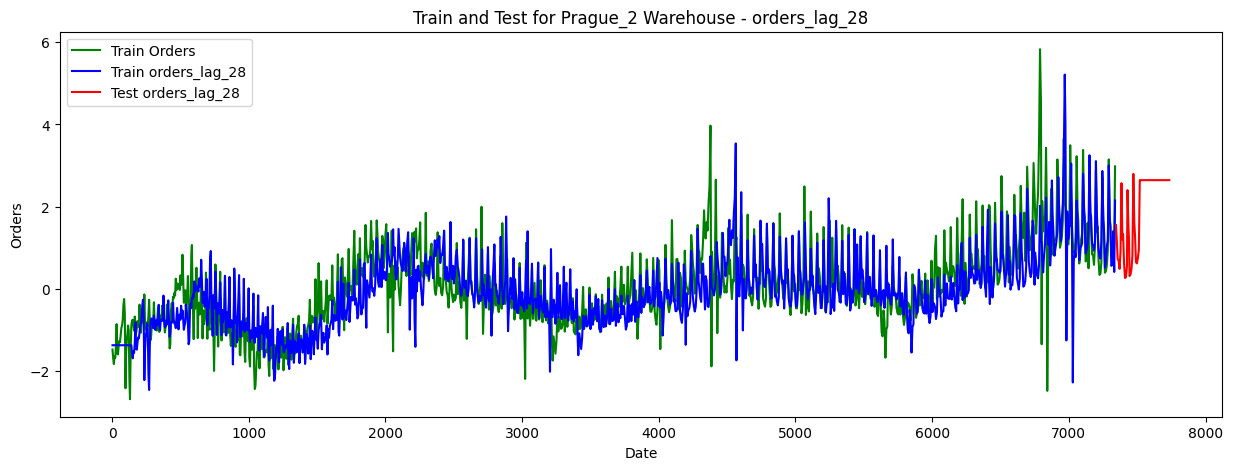

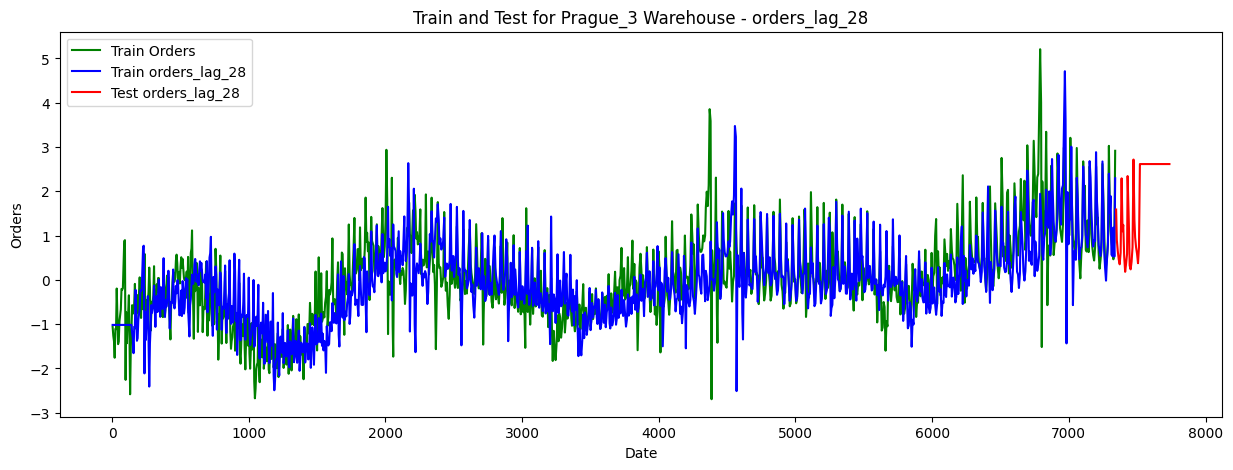

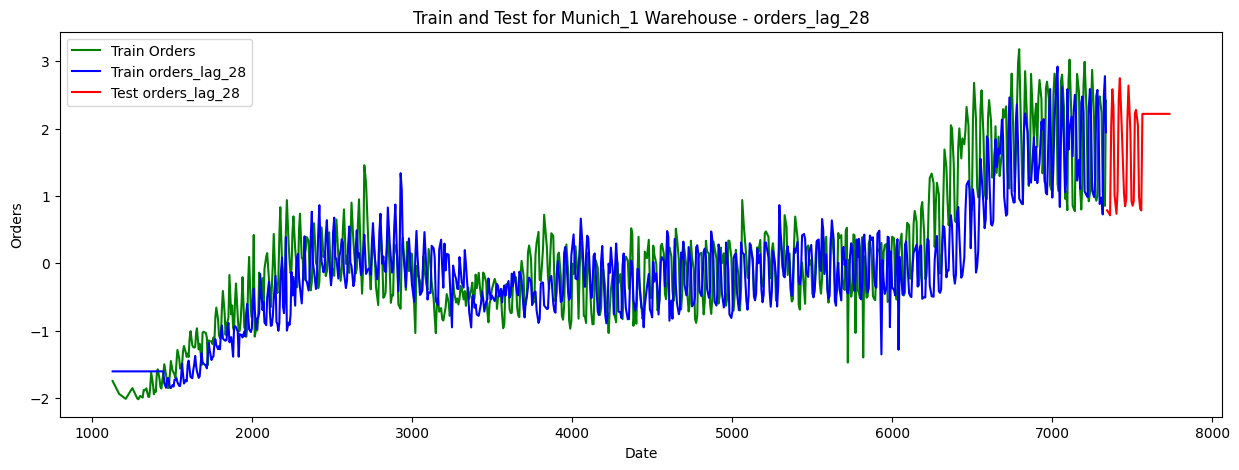

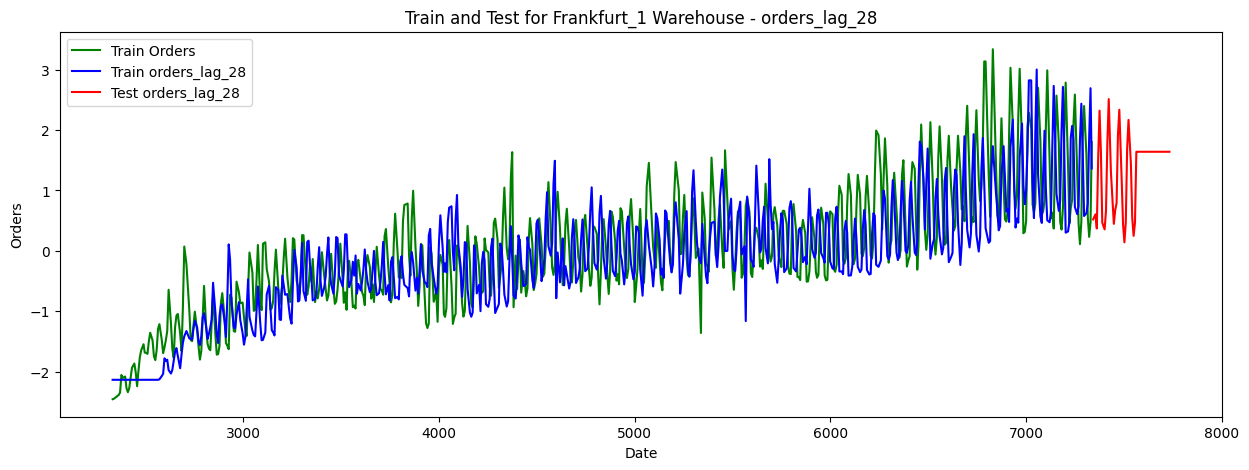

In [239]:
feature = f'orders_lag_{LAG_DAYS[2]}'  # third lag feature for test data

# Loop through the warehouse dataframes in the dictionary
for warehouse in processed_train_data_dict.keys():
    plt.figure(figsize=(15, 5))
    
    # Get train data for the warehouse
    train_orders = processed_train_data_dict[warehouse][1]  # X_processed
    train_data = processed_train_data_dict[warehouse][0]  # X_processed

    # Get test data for the warehouse
    test_data = processed_test_df[processed_test_df['warehouse'] == warehouse]
    
    # Plot the orders and the feature
    plt.plot(train_data.index, train_orders, label='Train Orders', color='green')
    plt.plot(train_data.index, train_data[feature], label=f'Train {feature}', color='blue')
    plt.plot(test_data.index, test_data[feature], label=f'Test {feature}', color='red')
    
    plt.title(f'Train and Test for {warehouse} Warehouse - {feature}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()

In [240]:
for warehouse, (X_processed, y_processed) in processed_train_data_dict.items():
    print(f"Warehouse: {warehouse}")
    print("Start Date:", X_processed["date"].min())
    print("End Date:", X_processed["date"].max())
    print()

Warehouse: Brno_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Budapest_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-14 00:00:00

Warehouse: Prague_1
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_2
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Prague_3
Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Munich_1
Start Date: 2021-07-21 00:00:00
End Date: 2024-03-15 00:00:00

Warehouse: Frankfurt_1
Start Date: 2022-02-18 00:00:00
End Date: 2024-03-15 00:00:00



In [241]:
# Review dataset before training
train_data.head()

month_cos  year_sin     month   day_cos  month_sin  days_since_start  \
2334   0.764527 -1.097205 -1.238992 -1.214560   1.089843         -1.741156   
2341   0.764527 -1.097205 -1.238992 -1.049102   1.089843         -1.736897   
2365   0.764527 -1.097205 -1.238992 -0.035490   1.089843         -1.719859   
2372   0.764527 -1.097205 -1.238992  0.253770   1.089843         -1.715600   
2379   0.764527 -1.097205 -1.238992  0.534156   1.089843         -1.711340   

       day_sin  day_of_year       day  year_cos  orders_lag_1  orders_lag_7  \
2334 -0.684585    -1.200398  0.260473 -1.229622     -2.405761     -2.337741   
2341 -0.916841    -1.190768  0.374757 -1.229622     -2.405761     -2.337741   
2365 -1.402614    -1.152248  0.831894 -1.229622     -2.397708     -2.337741   
2372 -1.388282    -1.142617  0.946178 -1.229622     -2.341340     -2.337741   
2379 -1.317353    -1.132987  1.060462 -1.229622     -2.301077     -2.337741   

      orders_lag_28  orders_lag_56  orders_lag_84  orders_lag_168  \
2334      -2.135302      -1.922141      -1.753528       -1.400234   
2341      -2.135302      -1.922141      -1.753528       -1.400234   
2365      -2.135302      -1.922141      -1.753528       -1.400234   
2372      -2.135302      -1.922141      -1.753528       -1.400234   
2379      -2.135302      -1.922141      -1.753528       -1.400234   

      orders_lag_364  orders_rolling_mean_7  orders_rolling_std_7  \
2334       -0.814916              -2.726376             -2.507677   
2341       -0.814916              -2.721786             -2.507677   
2365       -0.814916              -2.698837             -2.366845   
2372       -0.814916              -2.675888             -2.298260   
2379       -0.814916              -2.600616             -1.798718   

      orders_rolling_mean_28  orders_rolling_std_28  orders_rolling_mean_56  \
2334               -2.693206              -2.940397               -2.645248   
2341               -2.688539              -2.940397               -2.640507   
2365               -2.665205              -2.775296               -2.616802   
2372               -2.641871              -2.694891               -2.593097   
2379               -2.565334              -2.109259               -2.515343   

      orders_rolling_std_56  orders_rolling_mean_168  orders_rolling_std_168  \
2334              -3.316314                -2.524525               -4.043180   
2341              -3.316314                -2.519517               -4.043180   
2365              -3.131746                -2.494478               -3.829911   
2372              -3.041861                -2.469439               -3.726050   
2379              -2.387180                -2.387309               -2.969567   

      orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
2334                -2.684094               -4.769636            0.0   
2341                -2.678072               -4.769636            0.0   
2365                -2.647964               -4.539611            0.0   
2372                -2.617856               -4.427589            0.0   
2379                -2.519101               -3.611667            0.0   

      day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
2334            0.0            0.0            0.0            1.0   
2341            0.0            0.0            0.0            0.0   
2365            0.0            1.0            0.0            0.0   
2372            0.0            0.0            1.0            0.0   
2379            0.0            0.0            0.0            1.0   

      day_of_week_5  quarter_1  quarter_2  quarter_3  quarter_4  year_2022  \
2334            0.0        1.0        0.0        0.0        0.0        1.0   
2341            1.0        1.0        0.0        0.0        0.0        1.0   
2365            0.0        1.0        0.0        0.0        0.0        1.0   
2372            0.0        1.0        0.0        0.0        0.0        1.0   
2379            0.0        1.0        0.0   

## Training Loop
- Create time series sequences
- Create LSTM neural net model
- Plot loss function history from traing
- Training loop

In [242]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

Model from experimenting, simpler gets more constant resulets

In [243]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # TCN Layers

    #model.add(Conv1D(filters=32, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())
    #model.add(Conv1D(filters=16, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'))
    #model.add(Dropout(0.1))
    #model.add(BatchNormalization())
    
    # Bidirectional LSTM Layer

    model.add(LSTM(units=128, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    
    # Fully Connected Layer
    model.add(Dense(32, activation='relu'))
    Dropout(0.1)
    model.add(Dense(units=1))

        # Compilation
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))
    return model


In [244]:
def plot_loss(history, warehouse):
    plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    
    # Highlight the minimum validation loss
    min_val_loss = min(history.history['val_loss'])
    min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)
    plt.axvline(min_val_loss_epoch, linestyle='--', color='gray', linewidth=1)
    plt.text(min_val_loss_epoch, min_val_loss, f'Min Val Loss: {min_val_loss:.4f}', 
             verticalalignment='bottom', horizontalalignment='right', color='gray', fontsize=10)
    
    # Titles and labels
    plt.title(f'Training and Validation Loss for Warehouse: {warehouse}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Set plot styles
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'training_validation_loss_{warehouse}.png', dpi=300)
    
    # Show plot
    plt.show()

In [245]:
#print nan values for every warehouse in train dataset dict:
for warehouse in processed_train_data_dict.keys():
    print(f"Nan X values for {warehouse}: {processed_train_data_dict[warehouse][0].isna().sum().sum()}")
    print(f"nan y values for {warehouse}: {sum(np.isnan(processed_train_data_dict[warehouse][1]))}")

Nan X values for Brno_1: 0
nan y values for Brno_1: 0
Nan X values for Budapest_1: 0
nan y values for Budapest_1: 0
Nan X values for Prague_1: 0
nan y values for Prague_1: 0
Nan X values for Prague_2: 0
nan y values for Prague_2: 0
Nan X values for Prague_3: 0
nan y values for Prague_3: 0
Nan X values for Munich_1: 0
nan y values for Munich_1: 0
Nan X values for Frankfurt_1: 0
nan y values for Frankfurt_1: 0


Training loop, create sequences, train-test split, create model, use callbacks for trainig, fit the model.

Training model for warehouse: Brno_1
final shape: ((1186, 7, 48), (1186,))
Epoch 1/100
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4091
Epoch 1: val_loss improved from inf to 0.72904, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.3816 - val_loss: 0.7290
Epoch 2/100
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4670
Epoch 2: val_loss improved from 0.72904 to 0.63740, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4670 - val_loss: 0.6374
Epoch 3/100
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3719
Epoch 3: val_loss improved from 0.63740 to 0.49828, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3722 - val_loss: 0.4983
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3630
Epoch 4: val_loss improved from 0.49828 to 0.37463, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3629 - val_loss: 0.3746
Epoch 5/100
57/60 ━━━━━━━

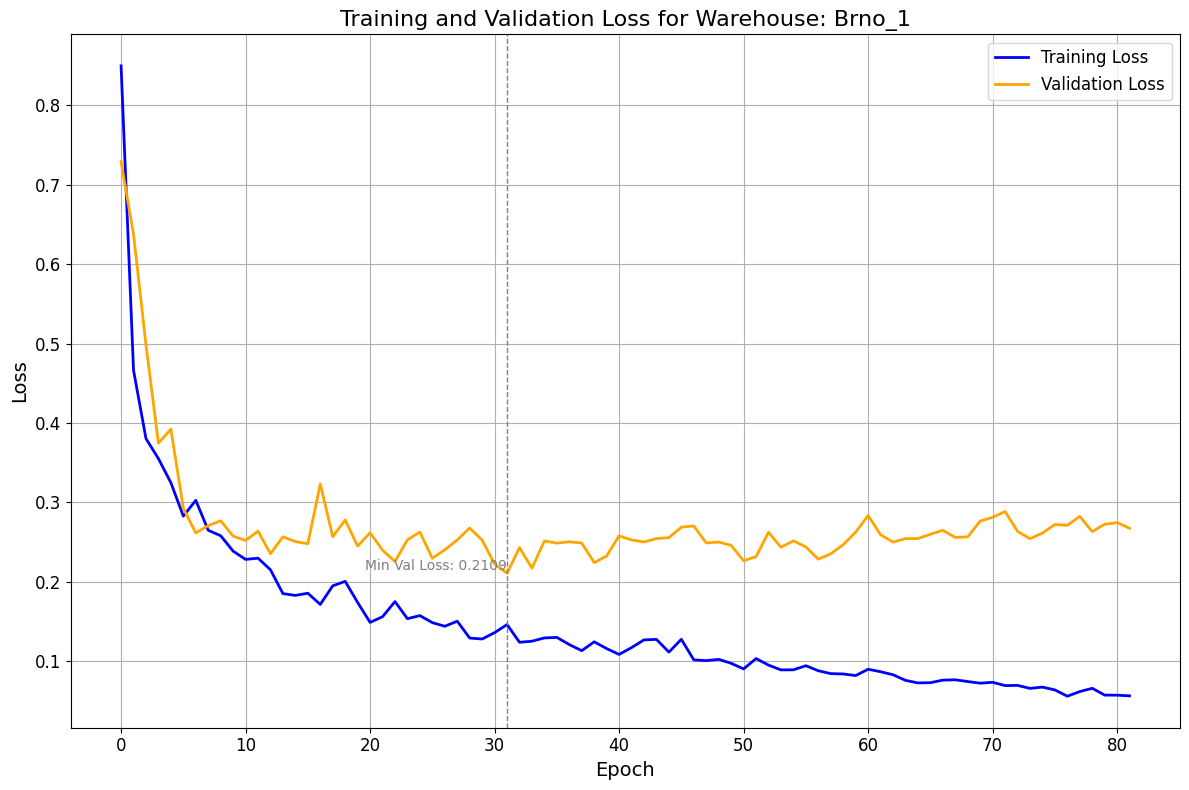

Training model for warehouse: Budapest_1
final shape: ((1147, 7, 48), (1147,))
Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2816
Epoch 1: val_loss improved from inf to 0.54275, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.2726 - val_loss: 0.5427
Epoch 2/100
46/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4014
Epoch 2: val_loss improved from 0.54275 to 0.47449, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3982 - val_loss: 0.4745
Epoch 3/100
46/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3659
Epoch 3: val_loss improved from 0.47449 to 0.34503, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3623 - val_loss: 0.3450
Epoch 4/100
46/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2981
Epoch 4: val_loss improved from 0.34503 to 0.29241, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3039 - val_loss: 0.2924
Epoc

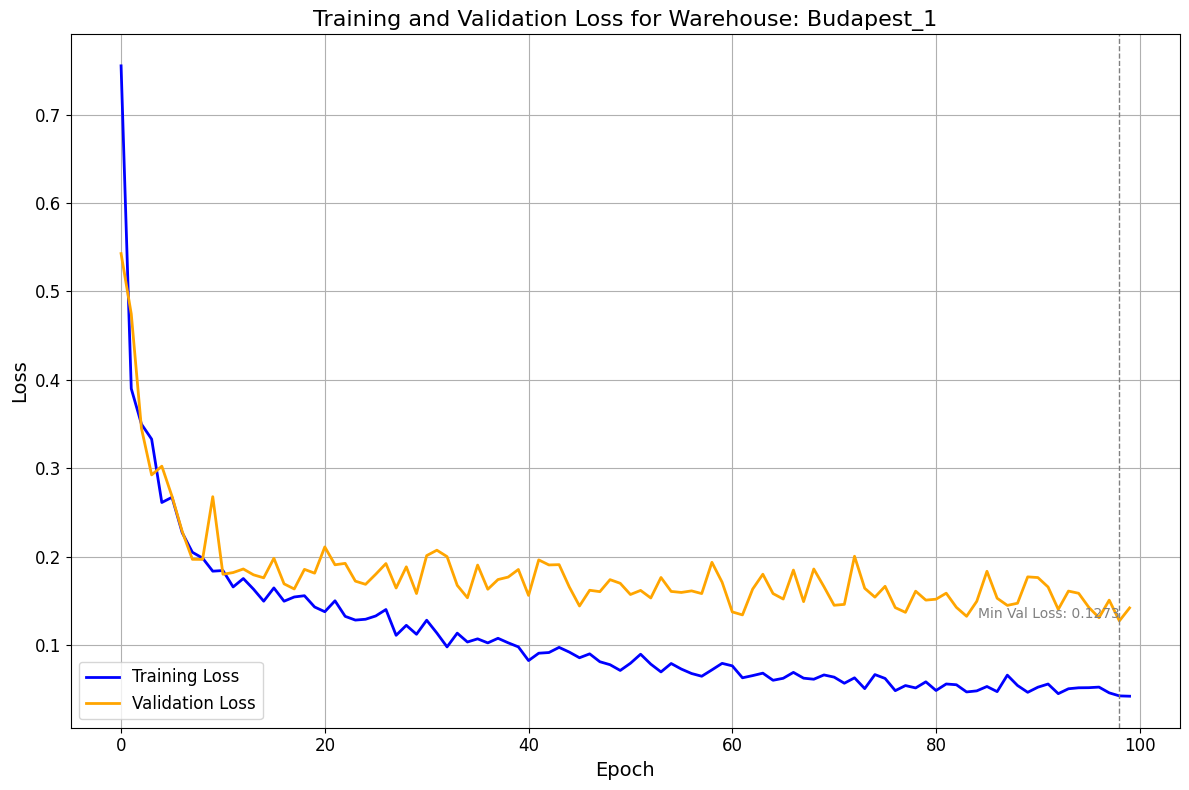

Training model for warehouse: Prague_1
final shape: ((1186, 7, 48), (1186,))
Epoch 1/100
45/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3543
Epoch 1: val_loss improved from inf to 0.56726, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.2469 - val_loss: 0.5673
Epoch 2/100
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5986
Epoch 2: val_loss improved from 0.56726 to 0.45219, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5854 - val_loss: 0.4522
Epoch 3/100
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4698
Epoch 3: val_loss improved from 0.45219 to 0.37280, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4714 - val_loss: 0.3728
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4653
Epoch 4: val_loss improved from 0.37280 to 0.34468, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4652 - val_loss: 0.3447
Epoch 5/100
46/

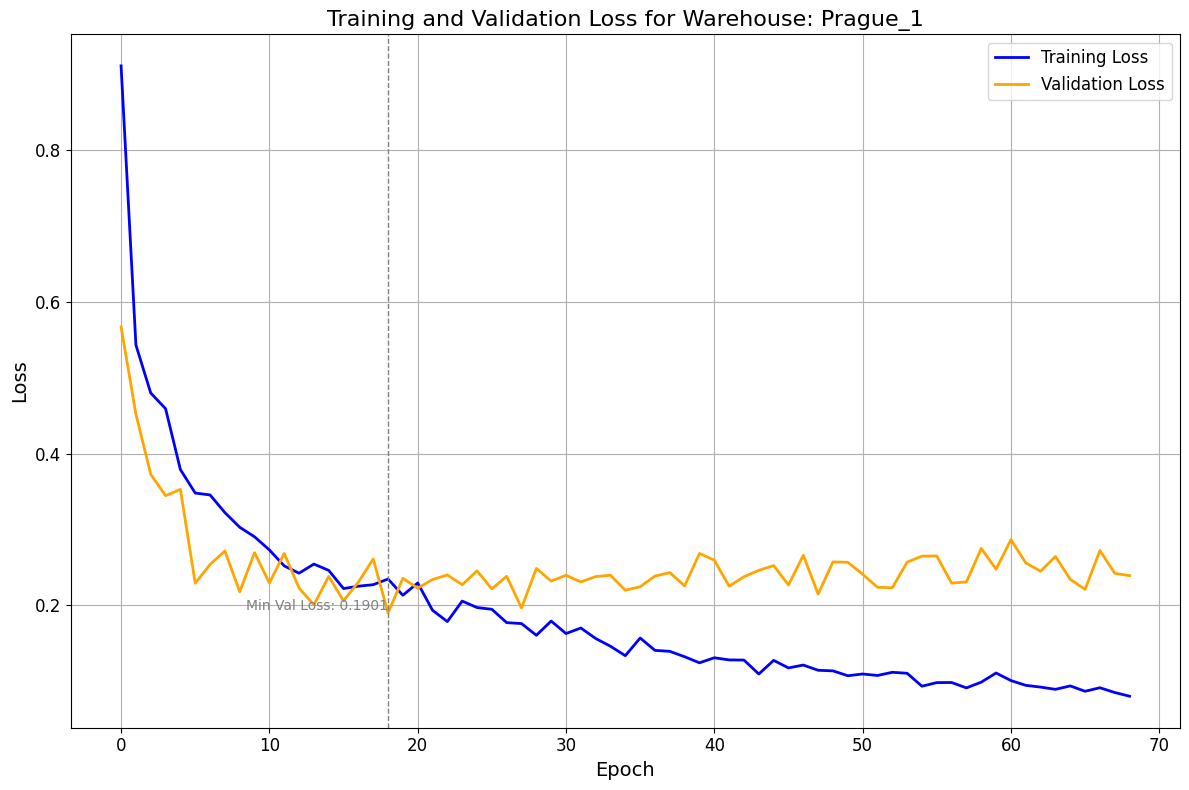

Training model for warehouse: Prague_2
final shape: ((1186, 7, 48), (1186,))
Epoch 1/100
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1892
Epoch 1: val_loss improved from inf to 0.62611, saving model to model_Prague_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1779 - val_loss: 0.6261
Epoch 2/100
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5643
Epoch 2: val_loss improved from 0.62611 to 0.52351, saving model to model_Prague_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5619 - val_loss: 0.5235
Epoch 3/100
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4044
Epoch 3: val_loss improved from 0.52351 to 0.42564, saving model to model_Prague_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4179 - val_loss: 0.4256
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3638
Epoch 4: val_loss improved from 0.42564 to 0.37344, saving model to model_Prague_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3643 - val_loss: 0.3734
Epoch 5/100
46/

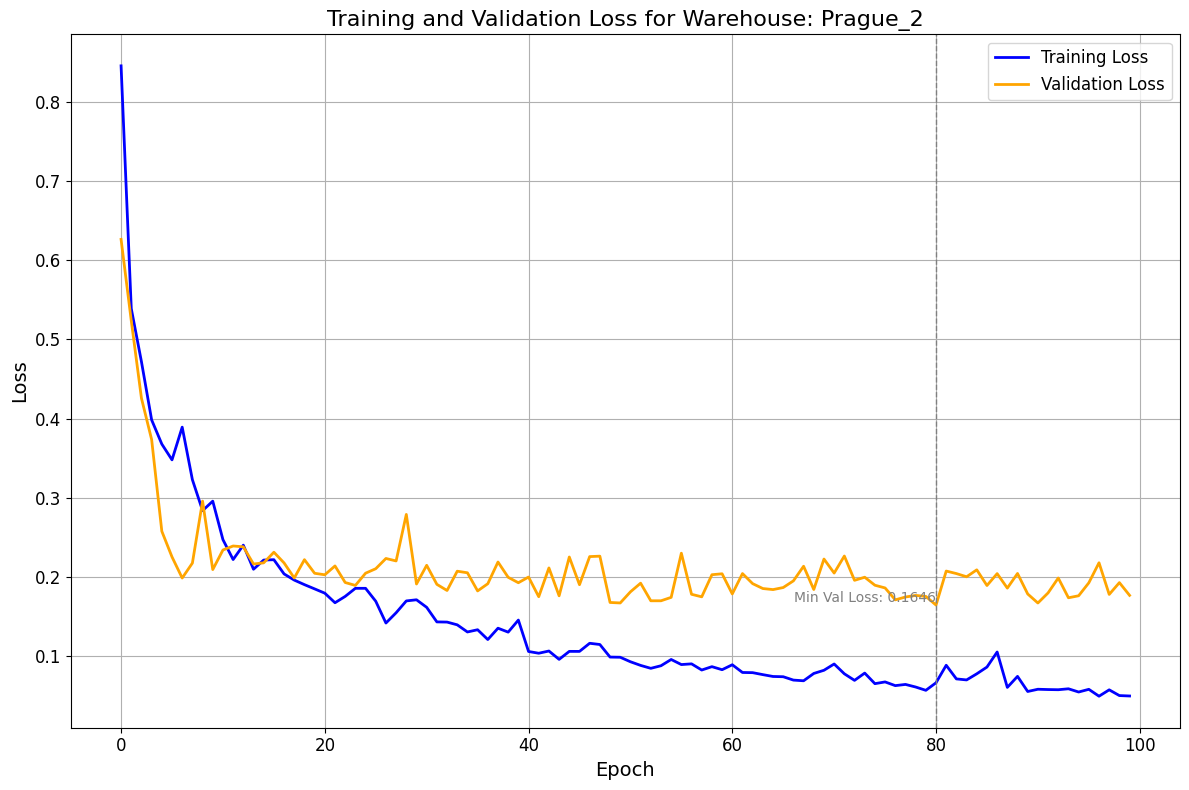

Training model for warehouse: Prague_3
final shape: ((1186, 7, 48), (1186,))
Epoch 1/100
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3237
Epoch 1: val_loss improved from inf to 0.69624, saving model to model_Prague_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.2749 - val_loss: 0.6962
Epoch 2/100
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5605
Epoch 2: val_loss improved from 0.69624 to 0.57835, saving model to model_Prague_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5576 - val_loss: 0.5784
Epoch 3/100
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3695
Epoch 3: val_loss improved from 0.57835 to 0.50188, saving model to model_Prague_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3880 - val_loss: 0.5019
Epoch 4/100
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3573
Epoch 4: val_loss improved from 0.50188 to 0.36055, saving model to model_Prague_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3733 - val_loss: 0.3606
Epoch 5/100
46/

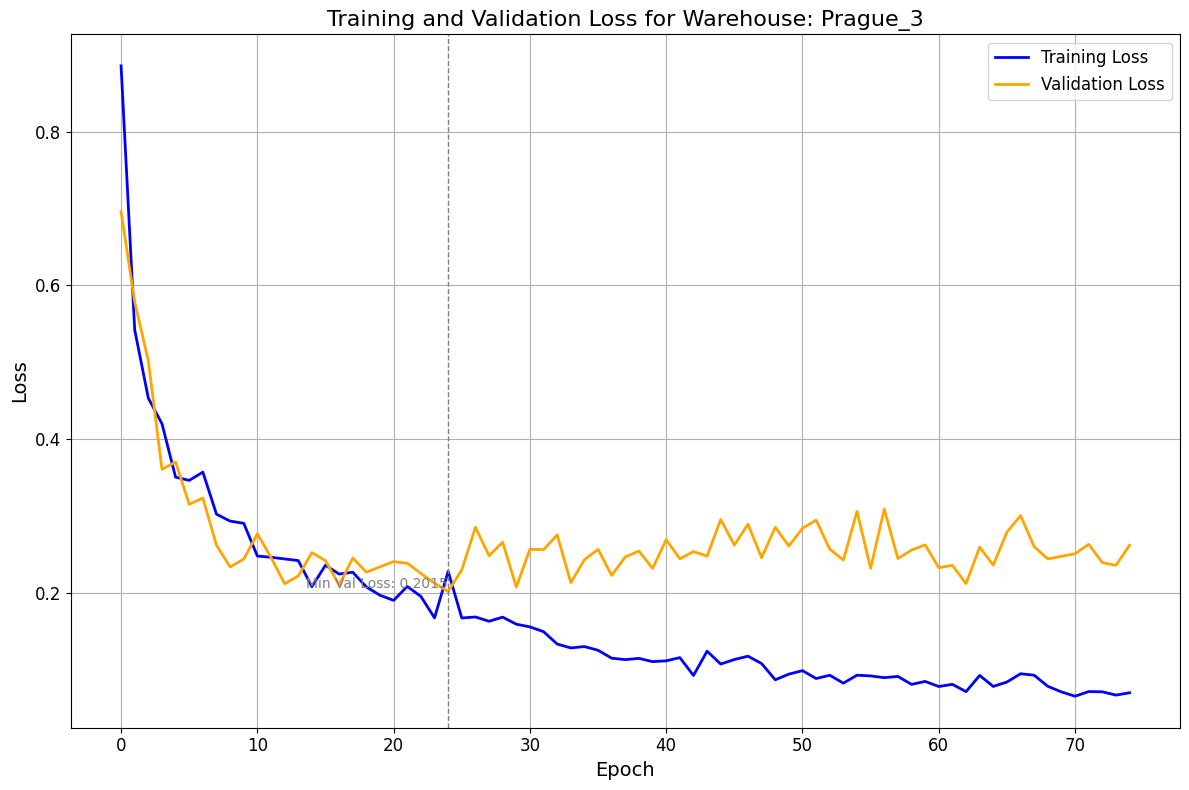

Training model for warehouse: Munich_1
final shape: ((778, 7, 47), (778,))
Epoch 1/100
30/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9782
Epoch 1: val_loss improved from inf to 0.59801, saving model to model_Munich_1.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.9137 - val_loss: 0.5980
Epoch 2/100
31/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4427
Epoch 2: val_loss improved from 0.59801 to 0.56849, saving model to model_Munich_1.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4237 - val_loss: 0.5685
Epoch 3/100
31/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2376
Epoch 3: val_loss improved from 0.56849 to 0.45890, saving model to model_Munich_1.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2389 - val_loss: 0.4589
Epoch 4/100
31/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2639
Epoch 4: val_loss did not improve from 0.45890
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2608 - val_loss: 0.4755
Epoch 5/100
30/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

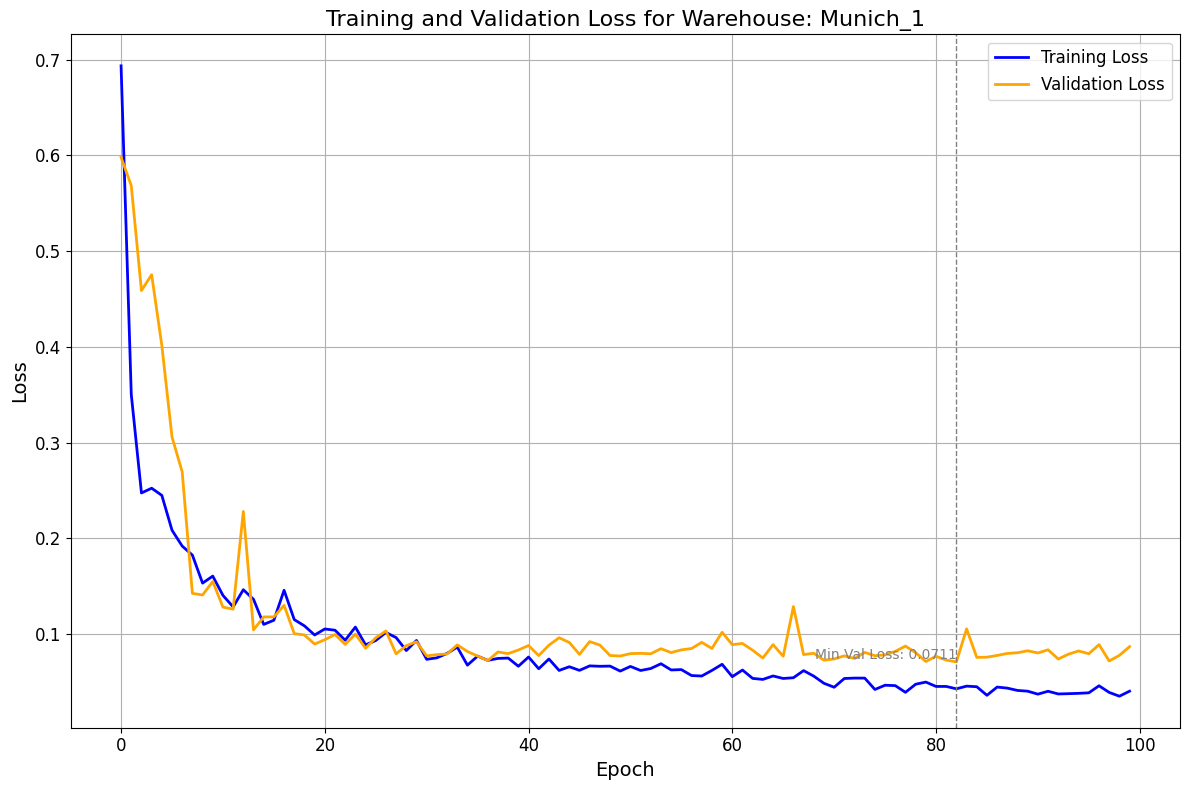

Training model for warehouse: Frankfurt_1
final shape: ((622, 7, 45), (622,))
Epoch 1/100
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0768
Epoch 1: val_loss improved from inf to 0.75052, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9885 - val_loss: 0.7505
Epoch 2/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4939
Epoch 2: val_loss improved from 0.75052 to 0.65523, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4828 - val_loss: 0.6552
Epoch 3/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2947
Epoch 3: val_loss improved from 0.65523 to 0.55316, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2957 - val_loss: 0.5532
Epoch 4/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2715
Epoch 4: val_loss improved from 0.55316 to 0.46120, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2712 - val_loss: 0.4612
E

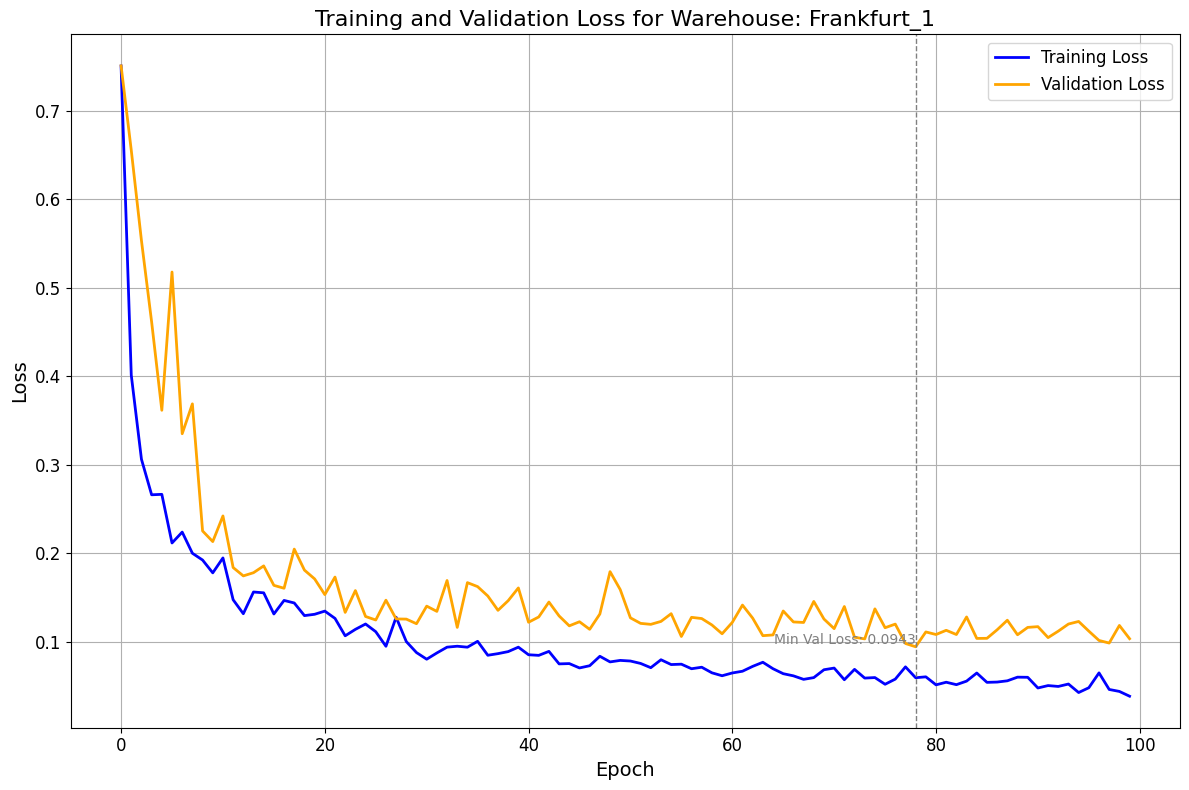

Training complete for all warehouses.


In [246]:
# Training loop
val_data = {}
training_features = {}

for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Training model for warehouse: {warehouse}")

    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse', 'date'])
    
    training_features[warehouse] = X_train_scaled.columns.tolist()

    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Compile model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    # Save the val data for each warehouse
    val_data[warehouse] = (X_val, y_val)
    
    history = model.fit(
        X_train, y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    plot_loss(history, warehouse)

print("Training complete for all warehouses.")

In [247]:
X_train_scaled.describe()

month_cos    year_sin       month     day_cos   month_sin  \
count  629.000000  629.000000  629.000000  629.000000  629.000000   
mean     0.048366   -0.131394    0.050176    0.004395   -0.077851   
std      1.014941    0.913312    1.019461    1.002373    0.993799   
min     -1.422893   -1.097205   -1.532791   -1.387080   -1.490129   
25%     -0.693753   -1.097205   -0.945192   -1.049102   -0.798827   
50%      0.035387    0.312295   -0.063794   -0.035490   -0.107526   
75%      0.764527    0.312295    0.817604    1.023223    1.089843   
max      1.493667    1.721808    1.699003    1.468447    1.275077   

       days_since_start     day_sin  day_of_year         day    year_cos  \
count        629.000000  629.000000   629.000000  629.000000  629.000000   
mean          -0.122938    0.002688     0.049715   -0.001345   -0.093420   
std            0.929567    0.999415     1.020268    1.003790    0.977108   
min           -1.741156   -1.402614    -1.653016   -1.682357   -1.229622   
25%           -0.923349   -1.019522    -0.892233   -0.882368   -1.229622   
50%           -0.131098   -0.005873     0.051522    0.031905    0.610733   
75%            0.678190    1.007776     0.927866    0.831894    0.610733   
max            1.478960    1.390868     1.842731    1.746167    1.224186   

       orders_lag_1  orders_lag_7  orders_lag_28  orders_lag_56  \
count    629.000000    629.000000     629.000000     629.000000   
mean      -0.119672     -0.115263      -0.100976      -0.104309   
std        0.935795      0.939367       0.951305       0.939174   
min       -2.405761     -2.337741      -2.135302      -1.922141   
25%       -0.698608     -0.666121      -0.601199      -0.566754   
50%       -0.187267     -0.177738      -0.119161      -0.052004   
75%        0.404599      0.421822       0.477647       0.499779   
max        3.001565      2.994766       3.002604       3.051313   

       orders_lag_84  orders_lag_168  orders_lag_364  orders_rolling_mean_7  \
count     629.000000      629.000000      629.000000             629.000000   
mean       -0.114757       -0.089518       -0.116875              -0.130610   
std         0.922376        0.969422        0.932126               0.911709   
min        -1.753528       -1.400234       -0.814916              -2.726376   
25%        -0.609492       -1.400234       -0.814916              -0.642610   
50%         0.000660        0.146282       -0.814916              -0.126586   
75%         0.487329        0.660554        0.720803               0.355998   
max         2.107139        2.133074        3.088200               2.227977   

       orders_rolling_std_7  orders_rolling_mean_28  orders_rolling_std_28  \
count            629.000000              629.000000             629.000000   
mean              -0.122595               -0.116422              -0.126473   
std                0.928508                0.935967               0.918717   
min               -2.507677               -2.693206              -2.940397   
25%               -0.727565               -0.575788              -0.649793   
50%               -0.236042               -0.048767              -0.274658   
75%                0.380025                0.256578               0.417532   
max                2.537964                1.682302               2.221094   

       orders_rolling_mean_56  orders_rolling_std_56  orders_rolling_mean_168  \
count              629.000000             629.000000               629.000000   
mean                -0.108175              -0.122601                -0.123975   
std                  0.955064               0.929956                 0.927719   
min                 -2.645248              -3.316314                -2.524525   
25%                 -0.474270              -0.577781                -0.843367   
50%                  0.049532              -0.180219                 0.066042   
75%                  0.303940               0.214841                 0.475401   
max                  1.664706     

Save all scaler features into a single json scaler config file and save the scaler config so it can be loded for inference.

In [248]:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
    'training_features': training_features,
}

joblib.dump(scaler_config, 'scaler_config_mt.joblib')

['scaler_config_mt.joblib']

## MAPE Eval

### Visualize predictions on the training data

Predicting for warehouse: Brno_1
final shape: ((1186, 7, 48), (1186,))
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


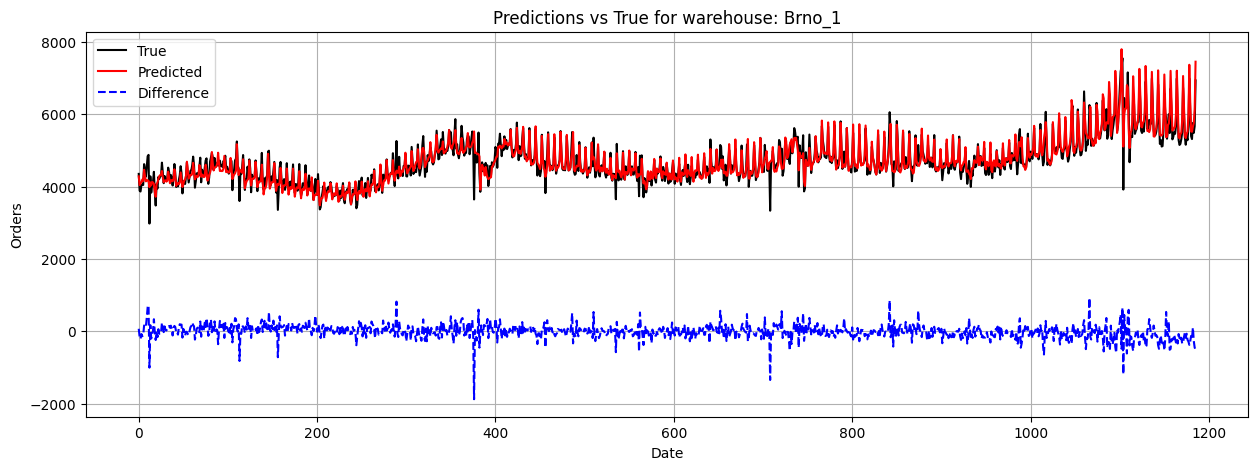


Mean Absolute Percentage Error on training data for Brno_1: 2.9626%
Predicting for warehouse: Budapest_1
final shape: ((1147, 7, 48), (1147,))
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


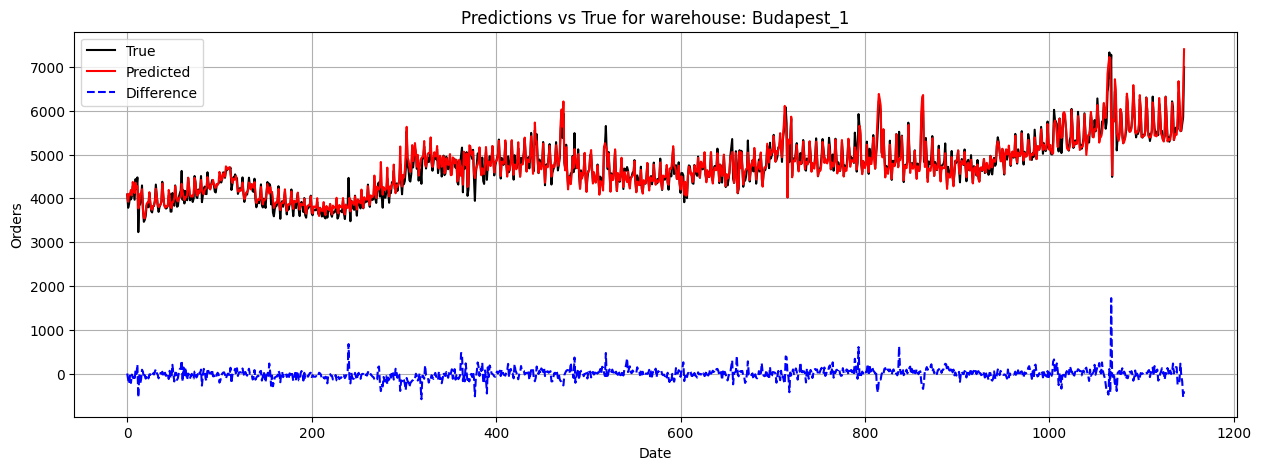


Mean Absolute Percentage Error on training data for Budapest_1: 1.8163%
Predicting for warehouse: Prague_1
final shape: ((1186, 7, 48), (1186,))
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


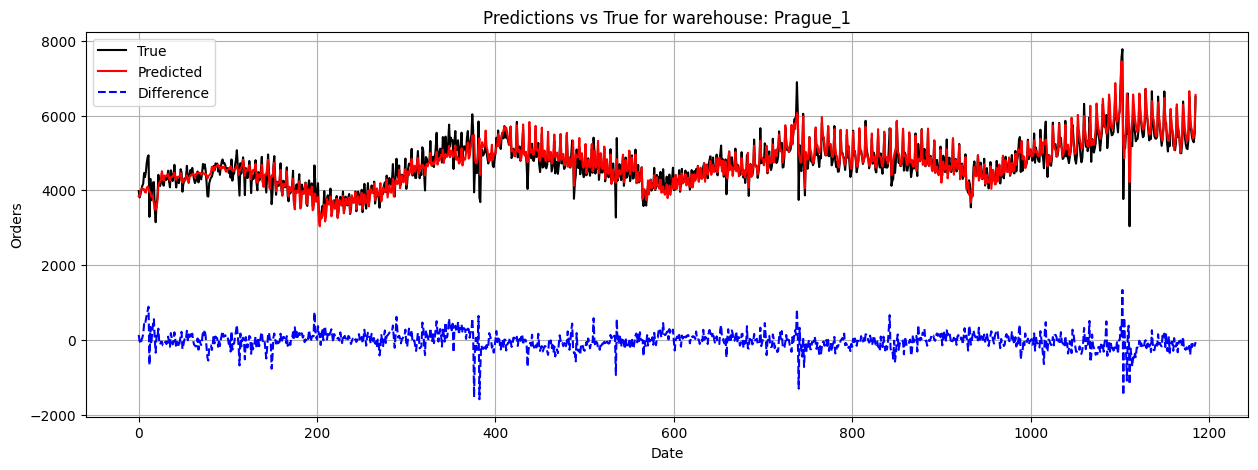


Mean Absolute Percentage Error on training data for Prague_1: 3.5165%
Predicting for warehouse: Prague_2
final shape: ((1186, 7, 48), (1186,))
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


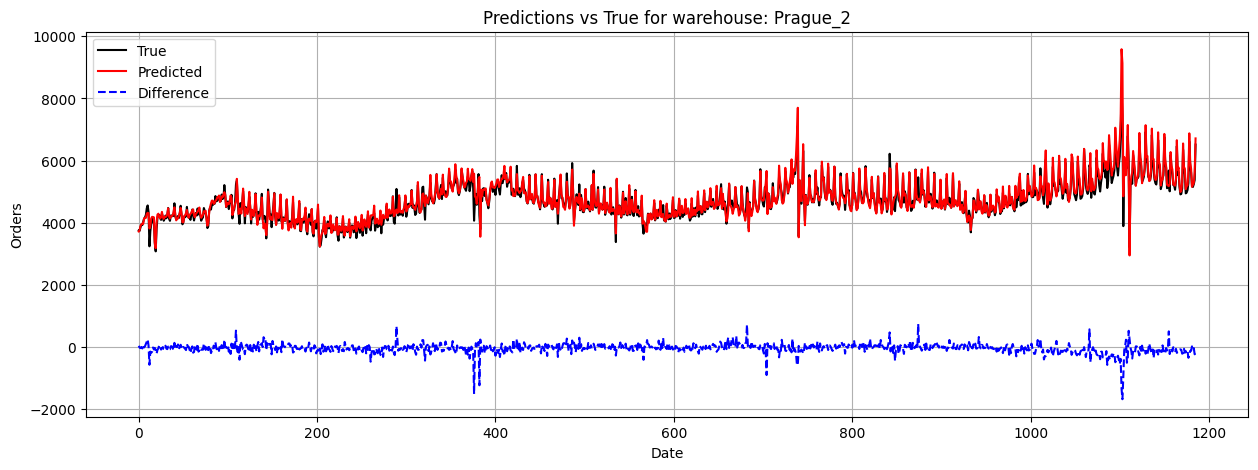


Mean Absolute Percentage Error on training data for Prague_2: 2.2375%
Predicting for warehouse: Prague_3
final shape: ((1186, 7, 48), (1186,))
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


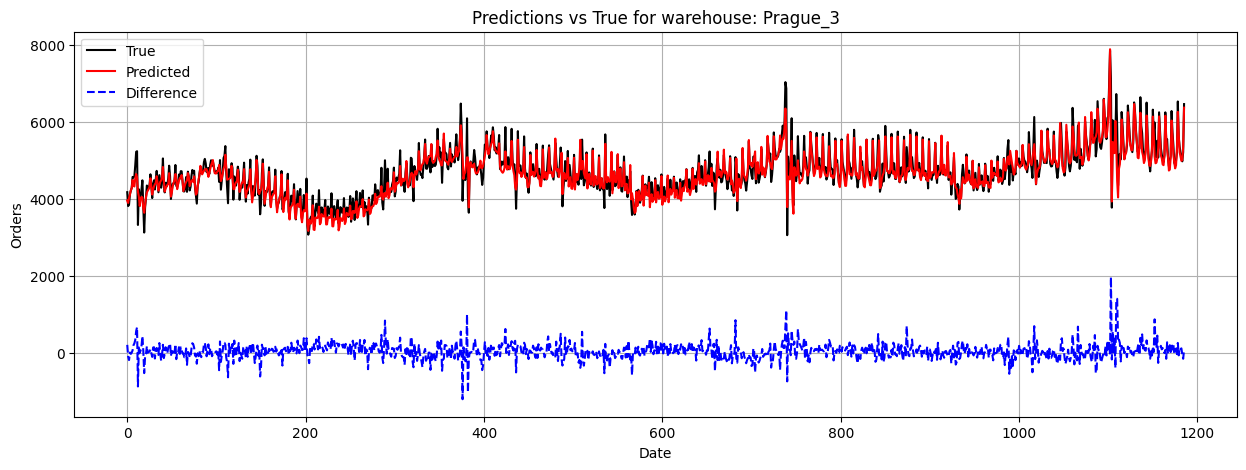


Mean Absolute Percentage Error on training data for Prague_3: 3.2344%
Predicting for warehouse: Munich_1
final shape: ((778, 7, 47), (778,))
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


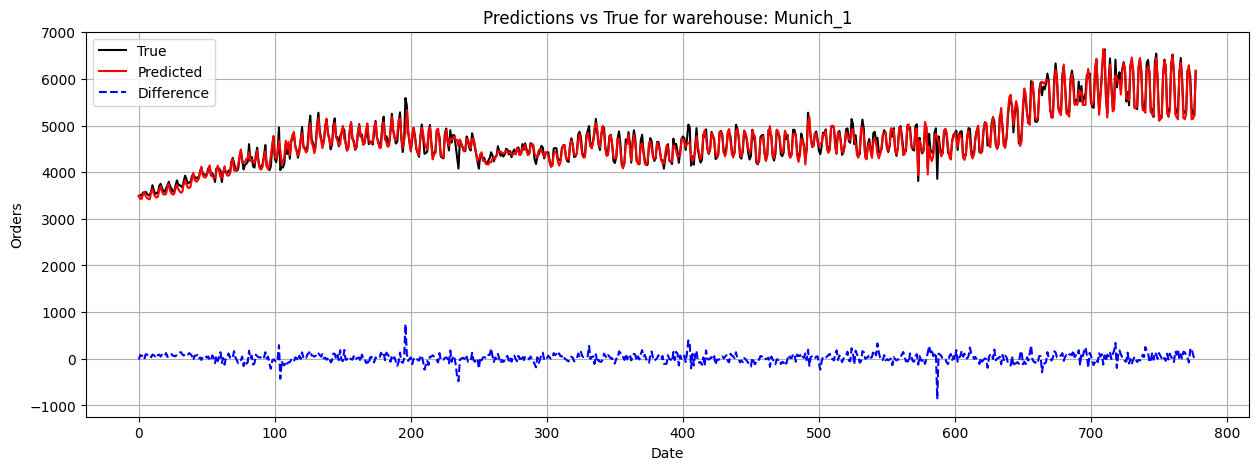


Mean Absolute Percentage Error on training data for Munich_1: 1.5530%
Predicting for warehouse: Frankfurt_1
final shape: ((622, 7, 45), (622,))
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


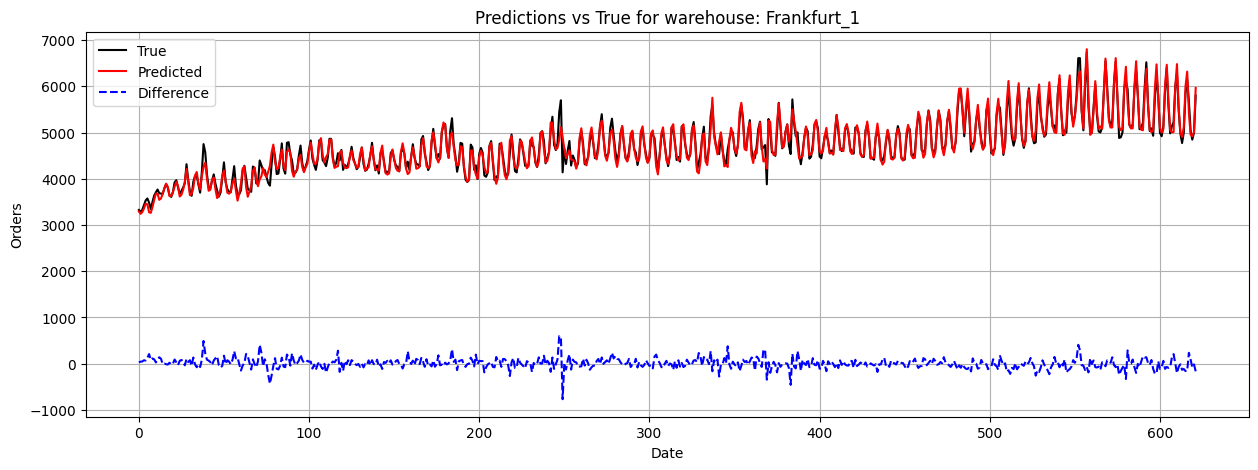


Mean Absolute Percentage Error on training data for Frankfurt_1: 1.7271%

MAPE training scores: 
Brno_1: 2.9626%
Budapest_1: 1.8163%
Prague_1: 3.5165%
Prague_2: 2.2375%
Prague_3: 3.2344%
Munich_1: 1.5530%
Frankfurt_1: 1.7271%

Mean training MAPE: 2.4353%


In [249]:
tf.keras.config.enable_unsafe_deserialization()

# Load scalers
y_scaler = joblib.load('y_scaler.joblib')

# Initialize a list to store MAPE scores
mape_scores = []

# Loop through each warehouse and calculate MAPE
for warehouse, (X_train_scaled, y_train_scaled) in processed_train_data_dict.items():
    print(f"Predicting for warehouse: {warehouse}")

    X_train_scaled = X_train_scaled.drop(columns=['id', 'warehouse', 'date'])
    # Create sequences
    X_seq, y_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=TIME_STEPS)

    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')

    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq = y_seq.reshape(-1, 1)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)

    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'\nMean Absolute Percentage Error on training data for {warehouse}: {mape:.4f}%')

# Print MAPE scores
print("\nMAPE training scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean training MAPE: {np.mean(mape_scores):.4f}%")

### Visualize predictions on the validation data

Predicting for warehouse: Brno_1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


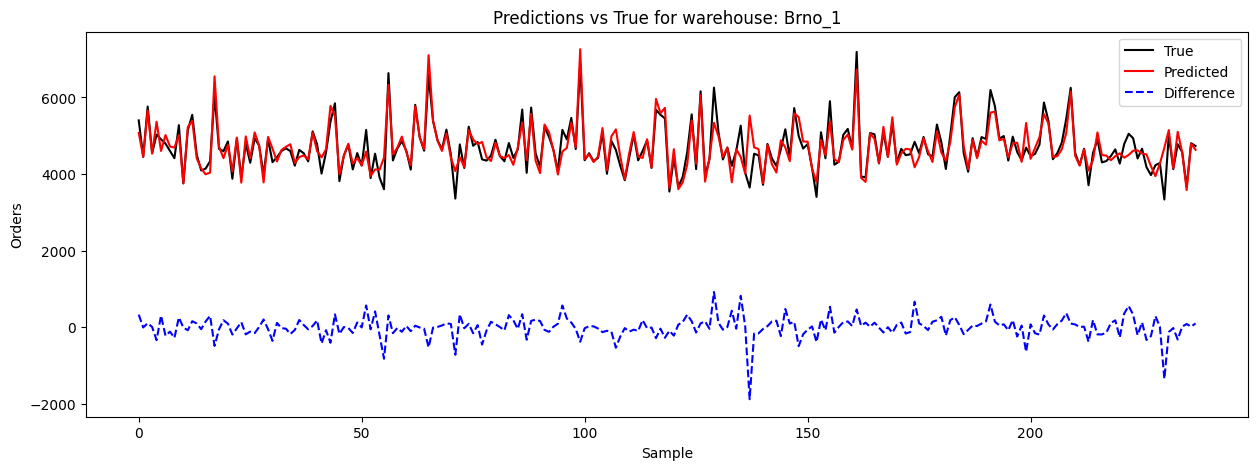


Mean Absolute Percentage Error on validation data for Brno_1: 3.9365%
Predicting for warehouse: Budapest_1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


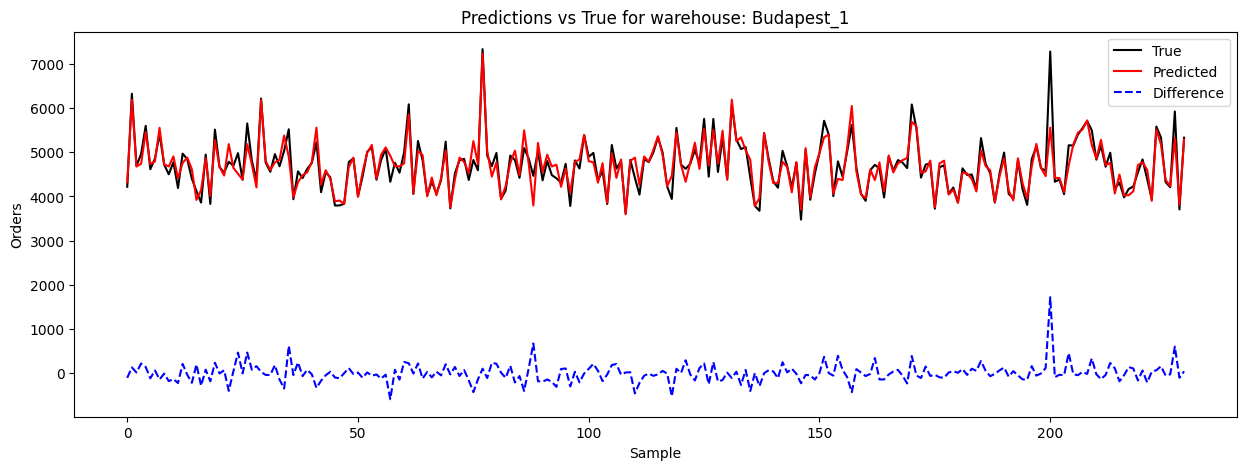


Mean Absolute Percentage Error on validation data for Budapest_1: 2.9107%
Predicting for warehouse: Prague_1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


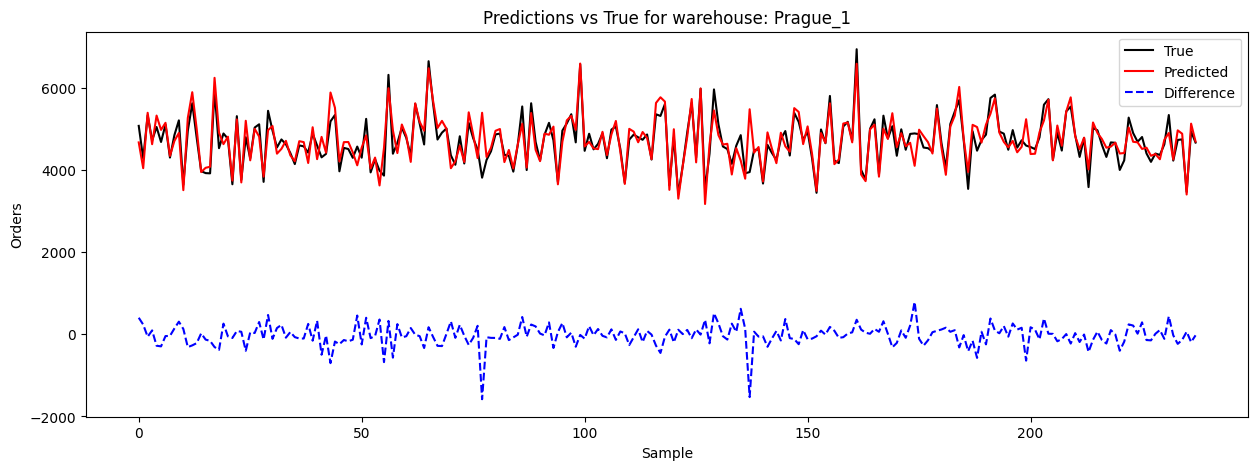


Mean Absolute Percentage Error on validation data for Prague_1: 3.9321%
Predicting for warehouse: Prague_2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


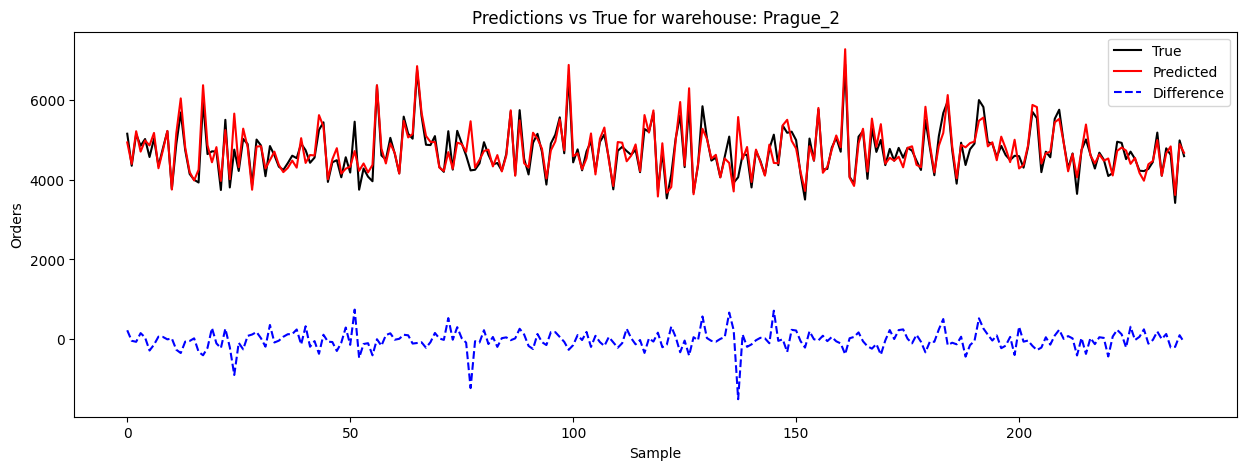


Mean Absolute Percentage Error on validation data for Prague_2: 3.5272%
Predicting for warehouse: Prague_3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


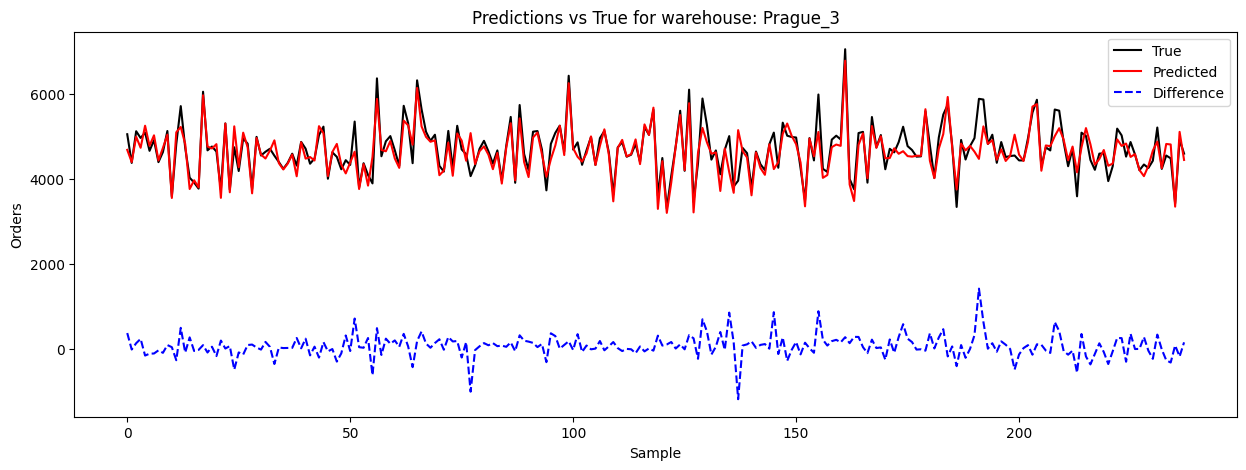


Mean Absolute Percentage Error on validation data for Prague_3: 3.8808%
Predicting for warehouse: Munich_1
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


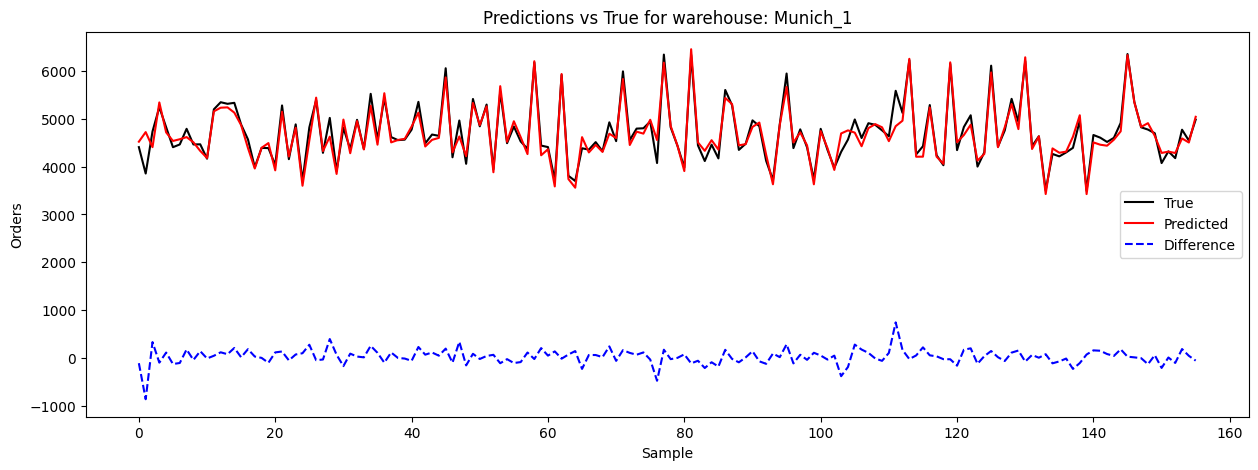


Mean Absolute Percentage Error on validation data for Munich_1: 2.4490%
Predicting for warehouse: Frankfurt_1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


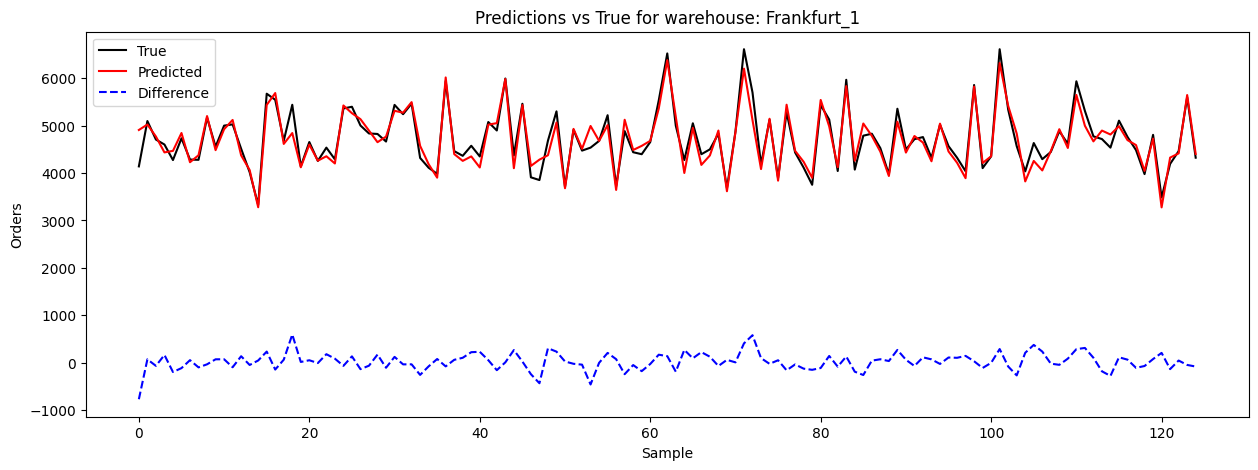


Mean Absolute Percentage Error on validation data for Frankfurt_1: 2.9532%

MAPE validation scores: 
Brno_1: 3.9365%
Budapest_1: 2.9107%
Prague_1: 3.9321%
Prague_2: 3.5272%
Prague_3: 3.8808%
Munich_1: 2.4490%
Frankfurt_1: 2.9532%

Mean validation MAPE: 3.3699%


In [250]:
mape_scores = []
y_scaler = joblib.load('y_scaler.joblib')

for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    # Load the validation data for the current warehouse
    X_val, y_val = val_data[warehouse]
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')
        # Predict
    predictions = model.predict(X_val)
    predictions = y_scaler.inverse_transform(predictions)
    y_val = y_val.reshape(-1, 1)
    y_val_unscaled = y_scaler.inverse_transform(y_val)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_val_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_val_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Sample')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error on validation data for {warehouse}: {mape:.4f}%')

print("\nMAPE validation scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean validation MAPE: {np.mean(mape_scores):.4f}%")


## Inference and visualisation on TEST data:

Here we deploy our trained models and run inference on the test data from the challenge. The test data are already preprocessed from the previous step, so we only load them and create LSTM sequences, then predict. If we wanted to take raw test data, we would only need to utilize the "process_data" function from the above section first.

This sequence function is not using the TimeseriesGenerator, because I could not figure out how to use it so it would utilize all the test data rows, there were always leftovers.
This function is creating sequences for each row and when it does not have enough data, it is padding the sequence with the first row of the sequence.

In [251]:
def create_sequences(data, max_time_steps):

    sequences = []
    for i in range(len(data)):
        seq = data.iloc[max(0, i-max_time_steps+1):i+1].values
        if len(seq) < max_time_steps:
            padding = np.tile(seq[0], (max_time_steps - len(seq), 1))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
    return np.array(sequences)


Function that that predicts the test data on multiple timelines - splitting the data for each warehouse, using multiple models.

In [252]:
def predict_multiple(data, time_steps, warehouses_trained, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouses_trained:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue

        model_data = warehouses_trained[warehouse]
        model = model_data['model']
        y_scaler = model_data['y_scaler']
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features[warehouse])

        sequences = create_sequences(wh_data, time_steps)

        # Predict on all sequences
        preds = model.predict(sequences)
        preds_rescaled = y_scaler.inverse_transform(preds)

        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)

        # Calculate the number of predictions
        num_predictions = len(preds_rescaled)

        # Assign predictions, accounting for the offset due to sequence creation
        wh_predictions[-num_predictions:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()

        wh_submission_data['predicted_orders'] = wh_predictions

        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)

    return np.array(predictions), submission_df

Load the saved models and scalers for each warehouse. This is optional and a conscious choise to use and is a part of end-to-end approach with potential deployment in mind.

In [253]:
def load_models_and_scalers(warehouses):
    warehouse_models_and_scalers = {}

    for wh in warehouses:
        try:
            model = tf.keras.models.load_model(f'model_{wh}.keras')
            x_scaler = joblib.load(f'x_scaler_{wh}.joblib')
            y_scaler = joblib.load(f'y_scaler_{wh}.joblib')
            encoder = joblib.load(f'onehot_scaler_{wh}.joblib')
            
            warehouse_models_and_scalers[wh] = {
                'model': model,
                'x_scaler': x_scaler,
                'y_scaler': y_scaler,
                'encoder': encoder
            }
        except Exception as e:
            print(f"Error loading model or scaler for warehouse {wh}: {str(e)}")

    return warehouse_models_and_scalers

Here we load the scaler configuration and other metadata from the training stage

In [254]:
scaler_config = joblib.load('scaler_config_mt.joblib') # load the scaler config

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']    # training features dictionary
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

cat_features: ['day_of_week', 'quarter', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 10


 Load the saved preprocessed training data

In [255]:
dataframe = pd.read_csv("data/test_proc_mt.csv")
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by=['date', 'warehouse'])
print(f"Rows: {len(dataframe)}")

Rows: 397


In [256]:
#id = dataframe['id']
#date = dataframe['date']
#warehouse = dataframe["warehouse"]

### Load models and predict the test dataset

In [257]:
warehouse_models = load_models_and_scalers(warehouses)
predictions, submission_df = predict_multiple(dataframe, TIME_STEPS, warehouse_models, training_features)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


In [258]:
len(submission_df.predicted_orders)

397

In [259]:
submission_df.head()

Unnamed: 0  month_cos  year_sin     month   day_cos  month_sin  \
0        7340  -0.038252  1.766768 -0.908653 -1.387317   1.305304   
1        7347  -0.038252  1.766768 -0.908653 -1.329170   1.305304   
2        7352  -0.038252  1.766768 -0.908653 -1.215256   1.305304   
3        7359  -0.038252  1.766768 -0.908653 -1.050239   1.305304   
4        7366  -0.038252  1.766768 -0.908653 -0.840874   1.305304   

   days_since_start   day_sin  day_of_year       day  year_cos  orders_lag_1  \
0          1.565646 -0.157170    -0.902247  0.041071  1.156977       2.79847   
1          1.568401 -0.435054    -0.893010  0.155017  1.156977       2.79847   
2          1.571156 -0.695753    -0.883774  0.268963  1.156977       2.79847   
3          1.573911 -0.928596    -0.874537  0.382909  1.156977       2.79847   
4          1.576666 -1.124050    -0.865300  0.496854  1.156977       2.79847   

   orders_lag_7  orders_lag_28  orders_lag_56  orders_lag_84  orders_lag_168  \
0      1.704325       1.994125       2.329156       4.574803        1.414597   
1      0.799594       0.796127       1.457496       4.983635        0.139844   
2      0.691847       0.891454       1.526692      -1.255156        0.458532   
3      1.287875       1.086690       1.866474       3.089638        0.373365   
4      0.921878       1.015195       1.666116       2.572296        0.110997   

   orders_lag_364  orders_rolling_mean_7  orders_rolling_std_7  \
0        1.638515               1.408707              1.323007   
1        0.905749               1.516446              1.543127   
2        0.707994               1.707693              1.646019   
3        0.405996               1.807825              2.360976   
4       -0.064630               2.209453              2.940191   

   orders_rolling_mean_28  orders_rolling_std_28  orders_rolling_mean_56  \
0                1.499892               1.426790                1.919344   
1                1.524362               1.465879                1.924789   
2                1.546508               1.517297                1.928924   
3                1.561365               1.590333                1.925633   
4                1.581005               1.660625                1.926773   

   orders_rolling_std_56  orders_rolling_mean_168  orders_rolling_std_168  \
0               1.462482                 2.360898                2.229205   
1               1.502446                 2.375799                2.196112   
2               1.545293                 2.388738                2.175940   
3               1.590253                 2.402410                2.151349   
4               1.637740                 2.418037                2.113464   

   orders_rolling_mean_364  orders_rolling_std_364  day_of_week_0  \
0                 2.124645                2.472037            0.0   
1                 2.128082                2.479054            0.0   
2                 2.132353                2.484712            1.0   
3                 2.137894                2.487702            0.0   
4                 2.145414                2.485126            0.0   

   day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  day_of_week_5  \
0            0.0            0.0            0.0            0.0            1.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            1.0            0.0            0.0            0.0            0.0   
4            0.0            1.0            0.0            0.0            0.0   

   day_of_week_6  quarter_1  quarter_2  quarter_3  quarter_4  year_2020  \
0            0.0        1.0        0.0        0.0        0.0        0.0   
1            1.0        1.0        0.0        0.0        0.0        0.0   
2            0.0        1.0        0.0        0.0        0.0        0.0   
3            0.0        1.0        0.0        0.0        0.0        0.0   
4            0.0        1.0        0.0

### Visualise the test data predictions
Visualise the predictions for 2 months of the test data with the actual data from previous year to see how the predictions fit.

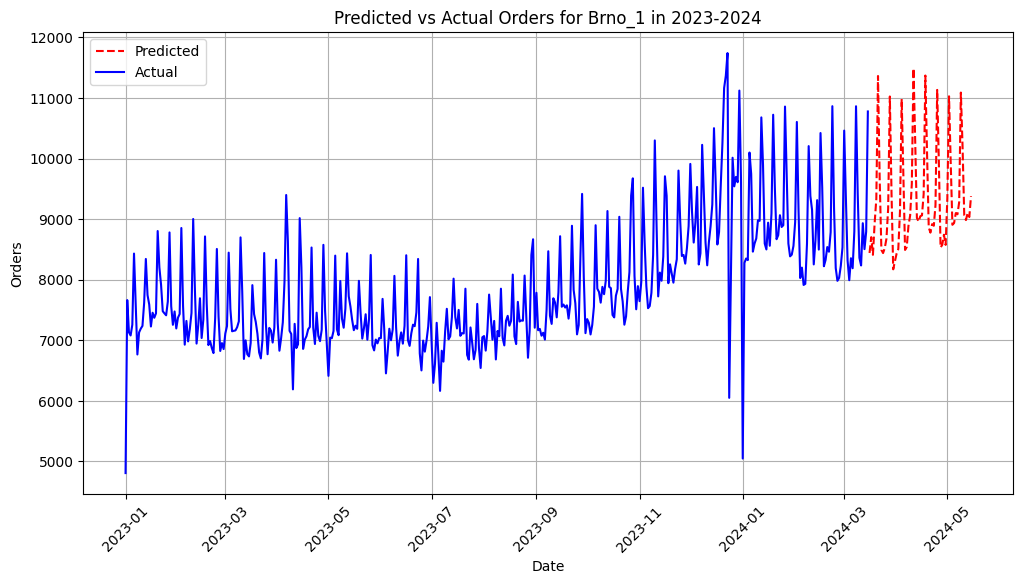

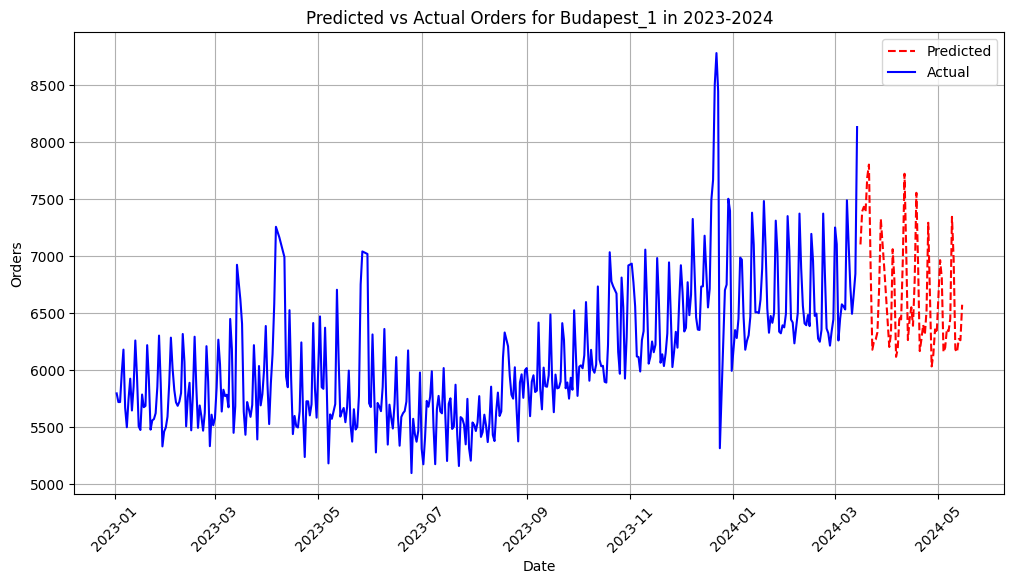

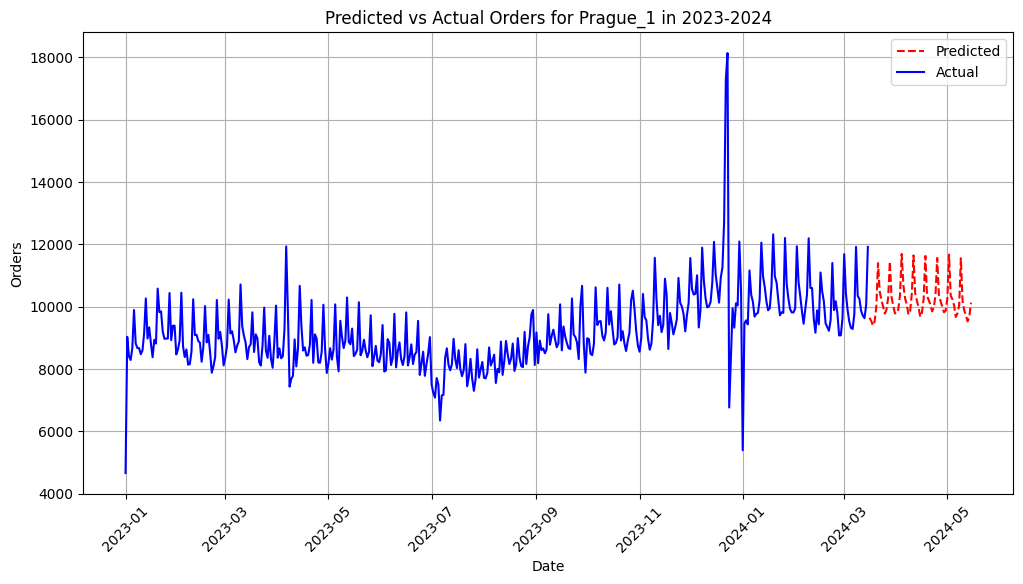

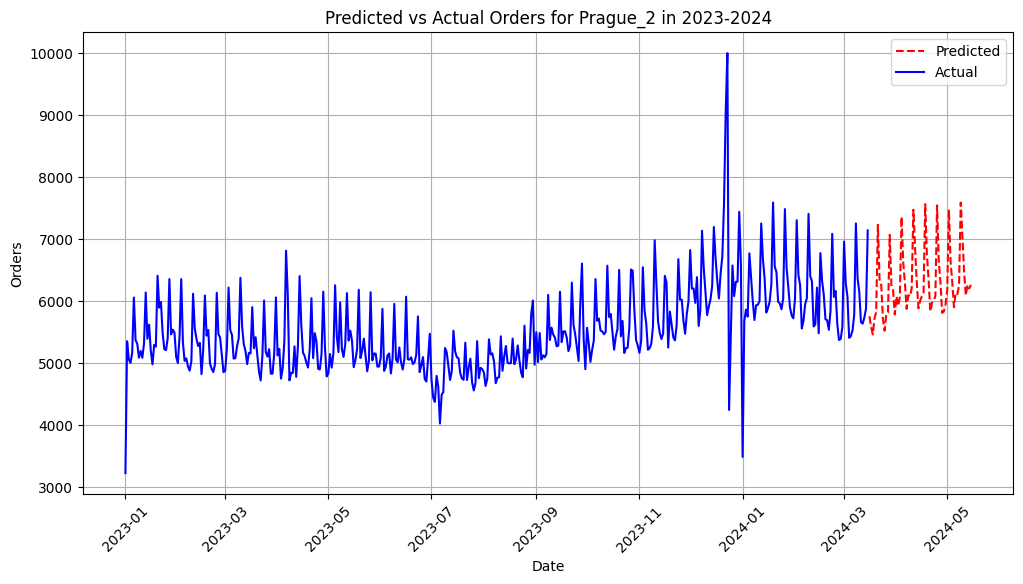

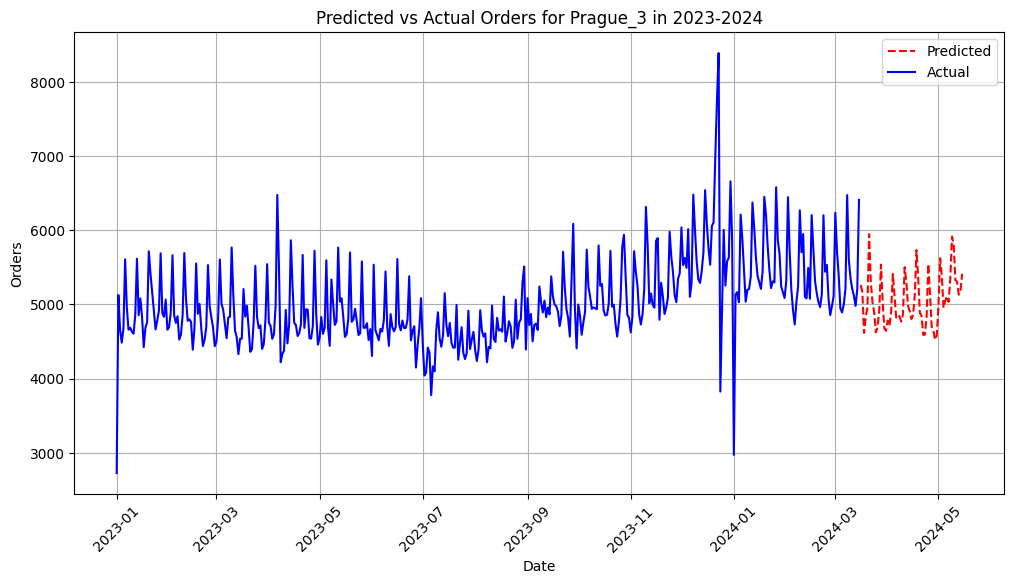

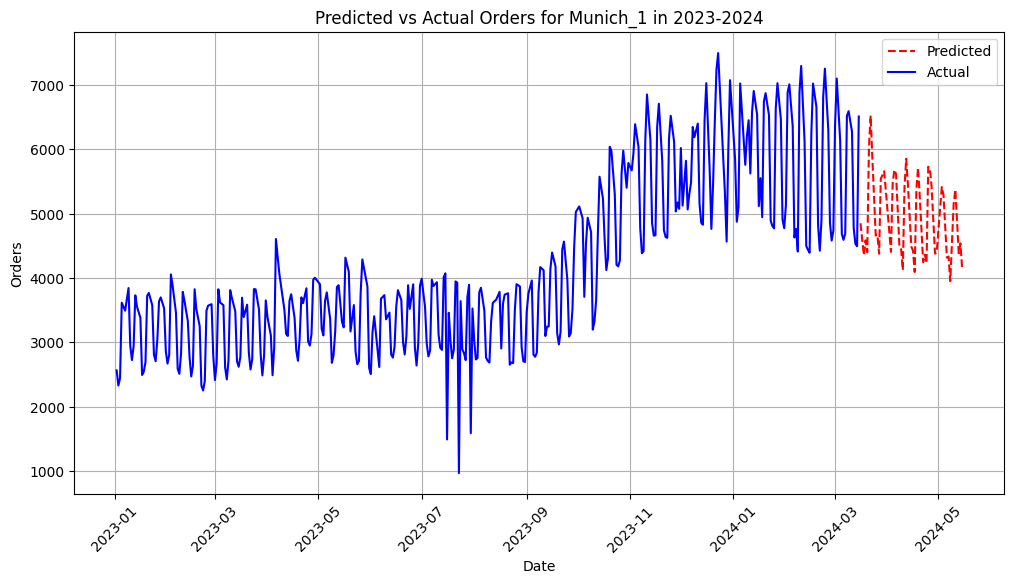

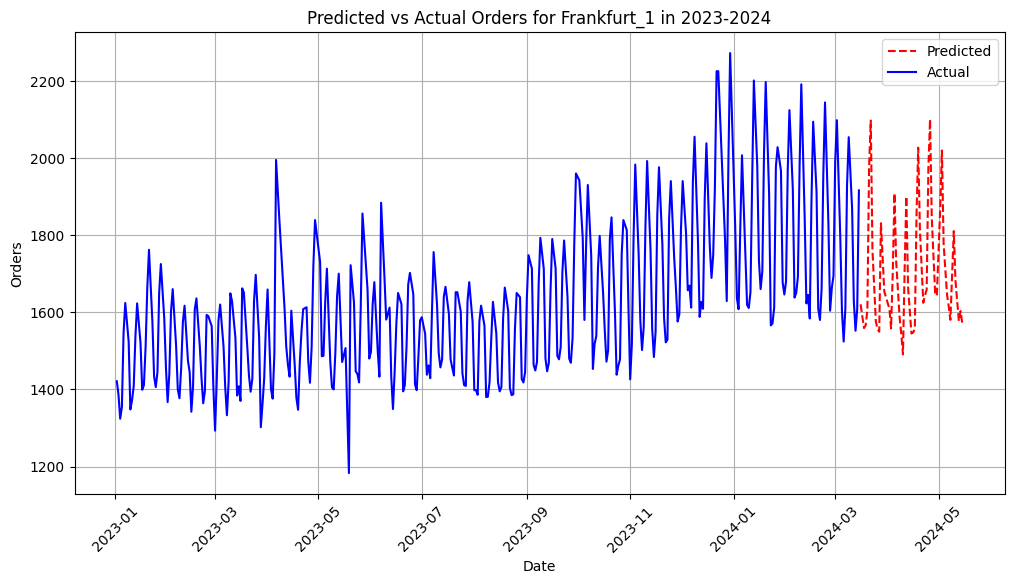

Predictions complete. Submission file and plots created.


In [260]:
# Plot predictions for each warehouse
train_df_raw = pd.read_csv("data/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]

for wh in warehouses:

    wh_df_pred = submission_df[submission_df['warehouse'] == wh]
    wh_df_pred = wh_df_pred.sort_values(by=['date'])
    wh_df_last_year = last_year_data[last_year_data['warehouse'] == wh]
    wh_df_last_year = wh_df_last_year.sort_values(by=['date'])
    
    # Plot data (training data from 2023)

    plt.figure(figsize=(12, 6))
    
    plt.plot(wh_df_pred.date, wh_df_pred['predicted_orders'], label='Predicted',  linestyle='--', color='red')

    plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

    plt.title(f'Predicted vs Actual Orders for {wh} in 2023-2024')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()

print("Predictions complete. Submission file and plots created.")